In [ ]:
!pip install -U transformers==4.39.3 peft==0.9.0 datasets nltk rouge_score bitsandbytes accelerate

!git clone https://github.com/facebookresearch/SpinQuant.git
!pip install git+https://github.com/Dao-AILab/fast-hadamard-transform.git

import sys
sys.path.append("/content/SpinQuant")

# Test import
from fast_hadamard_transform import hadamard_transform
from utils.hadamard_utils import random_hadamard_matrix

from train_utils.main import prepare_model
import os, json, shutil, time, torch, gc, requests
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import Dataset, concatenate_datasets, load_dataset
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import (
    AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,
    AutoConfig, AdamW, get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from torch import amp as torch_amp
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from huggingface_hub import snapshot_download
from torch.nn.utils import prune
from copy import deepcopy
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score
from tqdm import tqdm
from google.colab import runtime

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c35b67720d27a815da36a0566ec02808e78e1b48c9cab5d1c8a546412a4b11c6
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.0
    U

In [ ]:
# 🔧 Model + Tokenizer setup
hf_token = ""
# Llama
model_id = "meta-llama/Llama-3.2-1B-Instruct"
model_dir = "/content/Llama-3.2-1B-Instruct"
# Mistral
# model_id = "mistralai/Mistral-7B-Instruct-v0.3"
# model_dir = "/content/Mistral-7B-Instruct"
# Gemma
# model_id = "google/gemma-3-1b-it"
# model_dir = "/content/gemma-3-1b-it"

# Download model
from huggingface_hub import snapshot_download
snapshot_download(repo_id=model_id, token=hf_token, local_dir=model_dir)

# # Patch config for Llama
config_path = os.path.join(model_dir, "config.json")
with open(config_path, "r") as f:
    config = json.load(f)
config["rope_scaling"] = {"type": "dynamic", "factor": 1.1}
with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

base_model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    token=hf_token,
    trust_remote_code=True,
    torch_dtype=torch.float16
).to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_dir, token=hf_token)

# ✅ Ensure tokenizer uses correct padding token
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Reuse eos if no pad_token

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/41.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

original/consolidated.00.pth:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

LICENSE.txt:   0%|          | 0.00/7.71k [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/6.02k [00:00<?, ?B/s]

params.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Alpaca dataset
alpaca = load_dataset("tatsu-lab/alpaca")

def format_alpaca(example):
    if example["input"]:
        prompt = f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:\n"
    else:
        prompt = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return {"prompt": prompt, "response": example["output"]}

formatted_alpaca = alpaca["train"].map(format_alpaca)

# Dolly dataset
dolly = load_dataset("databricks/databricks-dolly-15k")

def format_dolly(example):
    if example["context"]:
        prompt = f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['context']}\n\n### Response:\n"
    else:
        prompt = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return {"prompt": prompt, "response": example["response"]}

formatted_dolly = dolly["train"].map(format_dolly)

# Agent dataset
agent = load_dataset("THUDM/AgentInstruct")

def format_agent(example):
    conv = example["conversations"]
    user_msgs = [c["value"] for c in conv if c["from"] in ["human", "user"]]
    asst_msgs = [c["value"] for c in conv if c["from"] in ["gpt", "assistant"]]
    if not user_msgs or not asst_msgs:
        return None
    prompt = f"### Instruction:\n{user_msgs[-1]}\n\n### Response:\n"
    return {"prompt": prompt, "response": asst_msgs[-1]}

formatted_agent = [ds.map(format_agent).filter(lambda x: x is not None) for ds in agent.values()]
merged_agent = concatenate_datasets(formatted_agent)
# print("AgentInstruct merged size:", len(merged_agent))
# print(merged_agent[0])

def build_dataloader(dataset, tokenizer, max_len=512, batch_size=2):
    prompts = list(dataset["prompt"])
    responses = list(dataset["response"])
    full_texts = [p + r for p, r in zip(prompts, responses)]

    # Tokenize
    encodings = tokenizer(
        full_texts,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
        add_special_tokens=False
    )

    input_ids = encodings["input_ids"]
    labels = input_ids.clone()

    # Mask prompt part in labels
    for i, prompt in enumerate(prompts):
        prompt_ids = tokenizer(
            prompt,
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
            add_special_tokens=False
        )["input_ids"][0]
        prompt_len = (prompt_ids != tokenizer.pad_token_id).sum().item()
        labels[i][:prompt_len] = -100

    # Split train/val
    ds = TensorDataset(input_ids, labels)
    train_len = int(0.98 * len(ds))
    train_ds, val_ds = random_split(ds, [train_len, len(ds) - train_len])

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size)
    )

train_alpaca, val_alpaca = build_dataloader(formatted_alpaca, tokenizer)
train_dolly, val_dolly   = build_dataloader(formatted_dolly, tokenizer)
train_agent, val_agent = build_dataloader(merged_agent, tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-971539c34fcc7500.parquet:   0%|          | 0.00/118k [00:00<?, ?B/s]

(…)-00000-of-00001-916a87c4725da8c0.parquet:   0%|          | 0.00/273k [00:00<?, ?B/s]

(…)-00000-of-00001-302ad687bb3817a4.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

(…)-00000-of-00001-9f2ae60445e11b4e.parquet:   0%|          | 0.00/443k [00:00<?, ?B/s]

(…)-00000-of-00001-9e159f6d0557d229.parquet:   0%|          | 0.00/212k [00:00<?, ?B/s]

(…)-00000-of-00001-fc25d47330eea0fc.parquet:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

Generating os split:   0%|          | 0/195 [00:00<?, ? examples/s]

Generating db split:   0%|          | 0/538 [00:00<?, ? examples/s]

Generating alfworld split:   0%|          | 0/336 [00:00<?, ? examples/s]

Generating webshop split:   0%|          | 0/351 [00:00<?, ? examples/s]

Generating kg split:   0%|          | 0/324 [00:00<?, ? examples/s]

Generating mind2web split:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

Filter:   0%|          | 0/195 [00:00<?, ? examples/s]

Map:   0%|          | 0/538 [00:00<?, ? examples/s]

Filter:   0%|          | 0/538 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Filter:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/351 [00:00<?, ? examples/s]

Filter:   0%|          | 0/351 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Filter:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Filter:   0%|          | 0/122 [00:00<?, ? examples/s]

In [ ]:
class DummyArgs:
    def __init__(
        self,
        w_bits,
        a_bits,
        v_bits,
        k_bits,
        # Weight quantization options
        w_asym=False,
        w_clip=False,
        w_groupsize=-1,
        # Activation quantization options
        a_groupsize=-1,
        a_asym=False,
        a_clip_ratio=1.0,
        # Key quantization options
        k_asym=False,
        k_clip_ratio=1.0,
        k_groupsize=-1,
        # Value quantization options
        v_asym=False,
        v_clip_ratio=1.0,
        v_groupsize=-1,
        # Other flags
        int8_down_proj=False,
        fp32_had=False,
        k_pre_rope=False,
        seed=42,
    ):
        # W, A, K, V bits
        self.w_bits = w_bits
        self.a_bits = a_bits
        self.v_bits = v_bits
        self.k_bits = k_bits

        # W
        self.w_asym = w_asym
        self.w_clip = w_clip
        self.w_groupsize = w_groupsize

        # A
        self.a_groupsize = a_groupsize
        self.a_asym = a_asym
        self.a_clip_ratio = a_clip_ratio

        # K
        self.k_asym = k_asym
        self.k_clip_ratio = k_clip_ratio
        self.k_groupsize = k_groupsize

        # V
        self.v_asym = v_asym
        self.v_clip_ratio = v_clip_ratio
        self.v_groupsize = v_groupsize

        # Other
        self.int8_down_proj = int8_down_proj
        self.fp32_had = fp32_had
        self.k_pre_rope = k_pre_rope
        self.seed = seed

def spinquant_approx(model, bits=4):
    """
    SpinQuant with Hadamard rotations + quantization.
    Applies the same bit-width to weights, activations, keys, and values.
    """
    assert bits in (4, 8), "SpinQuant only supports 4-bit or 8-bit quantization."

    # Full quantization (W, A, K, V all at 'bits')
    args = DummyArgs(
        w_bits=bits,
        a_bits=bits,
        v_bits=bits,
        k_bits=bits,
    )

    # ----- 1) Add Hadamard rotations -----
    hidden_size = model.config.hidden_size
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads

    # Global R1
    R1 = random_hadamard_matrix(hidden_size, "cuda")
    model.R1 = torch.nn.Parameter(R1, requires_grad=False)

    # Per-layer R2
    for i in range(num_layers):
        head_dim = hidden_size // num_heads
        R2 = random_hadamard_matrix(head_dim, "cuda")
        model.model.layers[i].self_attn.R2 = torch.nn.Parameter(R2, requires_grad=False)

    # ----- 2) Apply SpinQuant quantization -----
    model = prepare_model(args, model)

    # ----- 3) Ensure everything is on the same device -----
    device = next(model.parameters()).device
    model = model.to(device)

    print(f"[SpinQuant] Applied {bits}-bit quantization (W, A, K, V) with Hadamard rotations.")
    return model

def stochastic_linear(x, weight, bias=None, noise_std=0.01):
    noise = torch.randn_like(x) * noise_std
    return F.linear(x + noise, weight, bias)

def quantize_tensor_int8(tensor, bits=8):
    qmax = 2 ** (bits - 1) - 1  # e.g., 127 for 8-bit
    scale = qmax / tensor.abs().max()
    return torch.clamp((tensor * scale).round(), -qmax, qmax) / scale

def quantize_tensor_int4(tensor, bits=4):
    qmax = 2 ** (bits - 1) - 1
    max_val = tensor.abs().max()

    if max_val == 0 or torch.isnan(max_val) or torch.isinf(max_val): # Avoid division by zero
        return tensor.clone()

    scale = qmax / max_val
    return torch.clamp((tensor * scale).round(), -qmax, qmax) / scale

# def quantize_tensor_nf4(tensor, chunk_size=2**20):

#     # Official NF4 codebook (Dettmers et al. 2022)
#     nf4 = torch.tensor([
#         -1.0000, -0.6962, -0.5250, -0.3947,
#         -0.2844, -0.1848, -0.0910,  0.0000,
#          0.0910,  0.1848,  0.2844,  0.3947,
#          0.5250,  0.6962,  0.8682,  1.0000
#     ], device=tensor.device, dtype=torch.float32)

#     flat = tensor.view(-1)
#     out = torch.empty_like(flat)

#     for start in range(0, flat.numel(), chunk_size):
#         end = min(start + chunk_size, flat.numel())
#         chunk = flat[start:end].unsqueeze(1)  # [chunk, 1]
#         d = torch.abs(chunk - nf4)           # [chunk, 16]
#         idx = d.argmin(dim=1)                # nearest codebook entry
#         out[start:end] = nf4[idx]

#     return out.view(tensor.shape)

def quantize_tensor_nf4(tensor, block_size=64, chunk_size=2**20):
    """
    NF4 quantization with blockwise normalization (bitsandbytes-style).
    - Splits tensor into blocks along the last dimension.
    - Each block normalized to [-1, 1] range before NF4 quantization.
    - Uses fixed 16-value NF4 codebook (Dettmers et al. 2022).
    """
    # Official NF4 codebook
    nf4 = torch.tensor([
    -1.0000, -0.6962, -0.5251, -0.3949,
    -0.2844, -0.1848, -0.0911,  0.0000,
     0.0911,  0.1848,  0.2844,  0.3949,
     0.5251,  0.6962,  0.8682,  1.0000
    ], device=tensor.device, dtype=torch.float32)

    shape = tensor.shape
    tensor = tensor.view(-1, shape[-1])  # flatten all but last dim
    out = torch.empty_like(tensor)

    for row in range(tensor.size(0)):
        row_data = tensor[row]

        for start in range(0, row_data.size(0), block_size):
            end = min(start + block_size, row_data.size(0))
            block = row_data[start:end]

            # normalize block
            max_val = block.abs().max()
            if max_val < 1e-8:  # avoid div by 0
                out[row, start:end] = block
                continue
            block_norm = block / max_val

            # nearest neighbor quantization
            d = torch.abs(block_norm.unsqueeze(1) - nf4)  # [block_size, 16]
            idx = d.argmin(dim=1)
            q_block = nf4[idx] * max_val  # de-normalize

            out[row, start:end] = q_block

    return out.view(shape)

def quantize_model_weights(model, method="int8"):
    for _, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if method == "int4":
                module.weight.data = quantize_tensor_int4(module.weight.data)
                if module.bias is not None:
                    module.bias.data = quantize_tensor_int4(module.bias.data)
            elif method == "nf4":
                module.weight.data = quantize_tensor_nf4(module.weight.data)
                if module.bias is not None:
                    module.bias.data = quantize_tensor_nf4(module.bias.data)
            else:  # default to int8
                module.weight.data = quantize_tensor_int8(module.weight.data, bits=8)
                if module.bias is not None:
                    module.bias.data = quantize_tensor_int8(module.bias.data, bits=8)

def patch_model(model, config):
    # Apply techniques inside each MLP
    for layer in model.modules():
        if hasattr(layer, "mlp"):
            gate = layer.mlp.gate_proj

            if config.get("prune"):
                prune.l1_unstructured(gate, name="weight", amount=0.05)

            if config.get("stochastic"):
                new = nn.Linear(gate.in_features, gate.out_features, bias=(gate.bias is not None)).to(gate.weight.device, dtype=gate.weight.dtype)
                new.weight.data.copy_(gate.weight.data)
                if gate.bias is not None:
                    new.bias.data.copy_(gate.bias.data)
                new.forward = lambda x, w=new.weight, b=new.bias: stochastic_linear(x, w, b, noise_std=0.01)
                layer.mlp.gate_proj = new

        if config.get("memory_approx") and hasattr(layer, "self_attn"):
            drop_p = 0.05
            orig = layer.self_attn.forward

            def wrapped_forward(*args, orig=orig, drop_p=drop_p, **kw):
                out = orig(*args, **kw)

                def mask_fn(t):
                    if not torch.is_floating_point(t): # Generate mask in same dtype and device to avoid Na
                        return t
                    mask = (torch.rand_like(t) > drop_p)
                    return t * mask

                if isinstance(out, tuple):
                    if isinstance(out[0], torch.Tensor) and out[0].numel() > 0:
                        return (mask_fn(out[0]),) + out[1:]
                    return out
                elif isinstance(out, torch.Tensor) and out.numel() > 0:
                    return mask_fn(out)
                return out

            layer.self_attn.forward = wrapped_forward

    if config.get("spinquant"):
        spinquantize(model,
                    dataloader=calib_dl,
                    nsteps=500,          # adjust calibration steps
                    lr=1e-3,             # learning rate for rotations
                    bits=4,              # or 8
                    block_size=64,
                    quantize_activations=True,
                    quantize_kv_cache=True)

    if config.get("lora"):
        lora_cfg = LoraConfig(
            r=8, lora_alpha=16, lora_dropout=0.05, bias="none",
            target_modules=["q_proj", "v_proj"],
            task_type=TaskType.CAUSAL_LM)
        model = get_peft_model(model, lora_cfg)
        model.print_trainable_parameters()

    return model

def evaluate_metrics(model, tokenizer, val_dl):
    model.eval()
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()

    prompts, preds, refs = [], [], []
    bleu_scores, rouge_l_scores, f1_scores = [], [], []
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    smooth_fn = SmoothingFunction().method4

    # Ensure tokenizer is configured for decoder-only generation
    tokenizer.padding_side = "left"
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Extract only the response part from a "### Response:" formatted string
    def extract_response(text: str) -> str:
        return text.split("### Response:")[-1].strip() if "### Response:" in text else text.strip()

    with torch.no_grad():
        for input_ids, labels in tqdm(val_dl, desc="🔍 Evaluating"):
            input_ids, labels = input_ids.cuda(), labels.cuda()
            attention_mask = (input_ids != tokenizer.pad_token_id).long()

            # Decode prompts (for debug printing)
            prompt_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

            # Decode references (mask -100 to pad)
            ref_labels = labels.clone()
            ref_labels[ref_labels == -100] = tokenizer.pad_token_id
            ref_texts = tokenizer.batch_decode(ref_labels, skip_special_tokens=True)

            tokenizer.eos_token = "<|eot_id|>"
            tokenizer.eos_token_id = tokenizer.convert_tokens_to_ids("<|eot_id|>")


            # 🚫 Random generation (sampling) + EOS stop
            gen_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=128,
                do_sample=True,              # random
                top_p=0.9,
                temperature=0.6,
                eos_token_id=tokenizer.eos_token_id or tokenizer.convert_tokens_to_ids("<|eot_id|>"),
                pad_token_id=tokenizer.pad_token_id
            )

            # Safe decoding: no special tokens in output
            pred_texts = [tokenizer.decode(g, skip_special_tokens=True).strip() for g in gen_ids]

            # Compare only the response segments
            for prompt, pred, ref in zip(prompt_texts, pred_texts, ref_texts):
                pred_resp = extract_response(pred)
                ref_resp  = extract_response(ref)

                prompts.append(prompt)
                preds.append(pred_resp)
                refs.append(ref_resp)

                pred_tokens = tokenizer.tokenize(pred_resp)
                ref_tokens  = tokenizer.tokenize(ref_resp)

                # BLEU
                bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth_fn)
                bleu_scores.append(bleu)

                # ROUGE-L
                rouge_l = scorer.score(ref_resp, pred_resp)["rougeL"].fmeasure
                rouge_l_scores.append(rouge_l)

                # F1 (token overlap)
                common = set(pred_tokens) & set(ref_tokens)
                prec = len(common) / len(pred_tokens) if pred_tokens else 0.0
                rec  = len(common) / len(ref_tokens)  if ref_tokens  else 0.0
                f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
                f1_scores.append(f1)

    # Debug: first 2 items
    n_show = min(2, len(refs))
    if n_show > 0:
        print("\n🧪 DEBUG: First Samples")
        for i in range(n_show):
            print(f"\n📜 Prompt {i+1}:\n{prompts[i]}")
            print(f"🔸 Prediction {i+1}:\n{preds[i]}")
            print(f"✅ Reference {i+1}:\n{refs[i]}")

    return {
        "BLEU": round(np.mean(bleu_scores), 4) if bleu_scores else 0.0,
        "ROUGE-L": round(np.mean(rouge_l_scores), 4) if rouge_l_scores else 0.0,
        "F1": round(np.mean(f1_scores), 4) if f1_scores else 0.0,
        "Time (s)": round(time.time() - start_time, 2),
        "Memory (MB)": round(torch.cuda.max_memory_allocated() / 1e6, 2)
    }

def train_model(model, train_dl, epochs=3, accumulation_steps=2, lr=1e-5):
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_dl) // accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),
        num_training_steps=num_training_steps
    )

    scaler = torch_amp.GradScaler(enabled=False)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    history = []

    for epoch in range(epochs):
        print(f"\n🚀 Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        total_tokens = 0
        optimizer.zero_grad()

        # tqdm for batch progress
        progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch+1}")

        for step, (xb, yb) in progress_bar:
            xb, yb = xb.cuda(), yb.cuda()

            with torch_amp.autocast('cuda'):
                outputs = model(xb)
                logits = outputs.logits
                valid_tokens = (yb != -100).sum().item()
                if valid_tokens == 0:
                    continue
                loss = loss_fn(logits.view(-1, logits.size(-1)), yb.view(-1))

            if torch.isnan(loss) or torch.isinf(loss):
                print("⚠️ NaN/Inf loss detected — skipping batch.")
                optimizer.zero_grad()
                continue

            total_loss += loss.item() * valid_tokens
            total_tokens += valid_tokens

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dl):
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            # Update tqdm bar postfix with current loss
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / total_tokens
        perplexity = np.exp(avg_loss)
        print(f"✅ Epoch {epoch + 1} Avg Loss: {avg_loss:.4f} | Perplexity: {perplexity:.2f}")
        history.append({"Epoch": epoch + 1, "Loss": avg_loss, "Perplexity": perplexity})

    return history

def report(model, train_dl, val_dl, tokenizer, epochs=3, variant_name=""):
    # Train → collect loss & perplexity per epoch
    train_history = train_model(model, train_dl, epochs=epochs)

    # Evaluate once
    eval_metrics = evaluate_metrics(model, tokenizer, val_dl)
    eval_metrics["Variant"] = variant_name

    # Merge final results
    df = pd.DataFrame(train_history)
    df["Variant"] = variant_name

    print("\n📊 Final Evaluation Metrics:", eval_metrics)

    # Plot training history
    plt.figure(figsize=(10,5))
    plt.plot(df["Epoch"], df["Loss"], label="Loss", marker="o")
    plt.plot(df["Epoch"], df["Perplexity"], label="Perplexity", marker="s")
    plt.xlabel("Epoch")
    plt.title(f"Training Curve ({variant_name})")
    plt.legend()
    plt.show()

    return df, eval_metrics


In [ ]:
results = []
train_dl, val_dl = train_alpaca, val_alpaca
name = "Alpaca"
# train_dl, val_dl = train_dolly, val_dolly
# name = "Dolly"
# train_dl, val_dl = train_agent, val_agent
# name = "Agent"

In [ ]:
print(f"\n  Evaluating Base Model")
metrics = evaluate_metrics(base_model, tokenizer, val_dl)
metrics["Variant"] = "Base Model"
print(metrics)


  Evaluating Base Model


🔍 Evaluating: 100%|██████████| 521/521 [20:07<00:00,  2.32s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Create a task list of 5 steps to monetize a blog

### Response:
Task List for Monetizing a Blog: 
1. Determine the target audience and what types of content you want to focus on. 
2. Develop an engaged audience by utilizing email marketing and social media.
3. Research and select an appropriate monetization program.
4. Implement the chosen monetization program into your blog.
5. Monitor statistics and optimize for success.
🔸 Prediction 1:
Task List for Monetizing a Blog: 
1. Determine the target audience and what types of content you want to focus on. 
2. Develop an engaged audience by utilizing email marketing and social media.
3. Research and select an appropriate monetization program.
4. Implement the chosen monetization program into your blog.
5. Monitor statistics and optimize for success.
✅ Reference 1:
Task List for Monetizing a Blog: 
1. Determine the target audience and what types of content you want to focus on. 
2. Develo

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Training LoRA model on Alpaca dataset
trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.06889230774326355

🚀 Epoch 1/10


Epoch 1: 100%|██████████| 25481/25481 [35:58<00:00, 11.81it/s, loss=0.0065]


✅ Epoch 1 Avg Loss: 0.3723 | Perplexity: 1.45

🚀 Epoch 2/10


Epoch 2: 100%|██████████| 25481/25481 [35:52<00:00, 11.84it/s, loss=0.0569]


✅ Epoch 2 Avg Loss: 0.0234 | Perplexity: 1.02

🚀 Epoch 3/10


Epoch 3: 100%|██████████| 25481/25481 [35:59<00:00, 11.80it/s, loss=0.4491]


✅ Epoch 3 Avg Loss: 0.2608 | Perplexity: 1.30

🚀 Epoch 4/10


Epoch 4: 100%|██████████| 25481/25481 [35:58<00:00, 11.81it/s, loss=0.3219]


✅ Epoch 4 Avg Loss: 0.4038 | Perplexity: 1.50

🚀 Epoch 5/10


Epoch 5: 100%|██████████| 25481/25481 [36:01<00:00, 11.79it/s, loss=0.3735]


✅ Epoch 5 Avg Loss: 0.4177 | Perplexity: 1.52

🚀 Epoch 6/10


Epoch 6: 100%|██████████| 25481/25481 [36:00<00:00, 11.79it/s, loss=0.2827]


✅ Epoch 6 Avg Loss: 0.4161 | Perplexity: 1.52

🚀 Epoch 7/10


Epoch 7: 100%|██████████| 25481/25481 [35:53<00:00, 11.83it/s, loss=0.6141]


✅ Epoch 7 Avg Loss: 0.4062 | Perplexity: 1.50

🚀 Epoch 8/10


Epoch 8: 100%|██████████| 25481/25481 [35:57<00:00, 11.81it/s, loss=0.3058]


✅ Epoch 8 Avg Loss: 0.3970 | Perplexity: 1.49

🚀 Epoch 9/10


Epoch 9: 100%|██████████| 25481/25481 [36:09<00:00, 11.75it/s, loss=0.3766]


✅ Epoch 9 Avg Loss: 0.3870 | Perplexity: 1.47

🚀 Epoch 10/10


Epoch 10: 100%|██████████| 25481/25481 [36:10<00:00, 11.74it/s, loss=0.2864]


✅ Epoch 10 Avg Loss: 0.3798 | Perplexity: 1.46


🔍 Evaluating: 100%|██████████| 521/521 [34:45<00:00,  4.00s/it]



🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Generate a fake email address based on the given criteria.

### Input:
Username: silverqueen
Domain: @example.com

### Response:
silverqueen@example.com
🔸 Prediction 1:
silverqueen@example.com:::::
::
:
:
:
:
:
:
:
 :
:
:
:

:

:
K F D D F F F F:
:
:
:
:
::
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
 F F F::
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
::::::    ::
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
:
 F F F F F D F F F F R F F F F
✅ Reference 1:
silverqueen@example.com

📜 Prompt 2:
### Instruction:
Write a short review of this movie.

### Input:
The movie "Sonic the Hedgehog"

### Response:
Sonic the Hedgehog is a fun and entertaining movie for children and adults alike. The characters are likable and the plot is exciting. Plus, the soundtrack is awesome and the special effects are impressive. Overall, this is a great movie for a family night or for anyone who loves Sonic.
🔸 Prediction 2:
Sonic the Hedgehog is a fun and entertaining mov

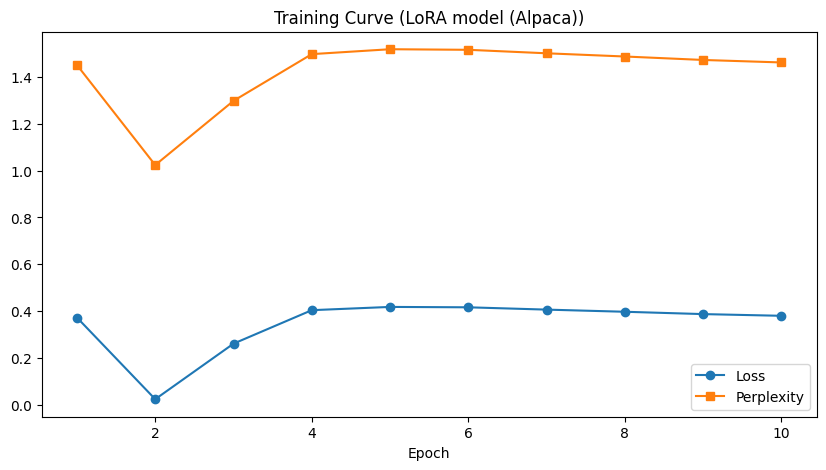

In [ ]:
model_lora = deepcopy(base_model)
print(f"\n Training LoRA model on {name} dataset")
model_lora = patch_model(model_lora, config={"lora": True})
df_lora, lora_eval = report(model_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"LoRA model ({name})")


 Training Pruned model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/1


Epoch 1: 100%|██████████| 25481/25481 [40:48<00:00, 10.41it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.0659 | Perplexity: 1.07


🔍 Evaluating: 100%|██████████| 521/521 [30:12<00:00,  3.48s/it]



🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Explain how increasing the habit of reading can improve a person's life

### Response:
Reading books can have a profound effect on a person's life. It can help broaden one's perspectives, expand their knowledge and vocabulary, and develop creativity and empathy. Reading offers an opportunity to experience new worlds, explore ideas and cultures, and even escape from reality. In addition, reading can improve a person’s communication skills, as well as their understanding of different concepts. It can also improve their memory, concentration, and problem-solving skills. Overall, reading can open up new opportunities in life, foster a greater appreciation for reading, and enhance critical thinking and reasoning abilities.
🔸 Prediction 1:
Reading books can have a profound effect on a person's life. It can help broaden one's perspectives, expand their knowledge and vocabulary, and develop creativity and empathy. Reading offers an opportun

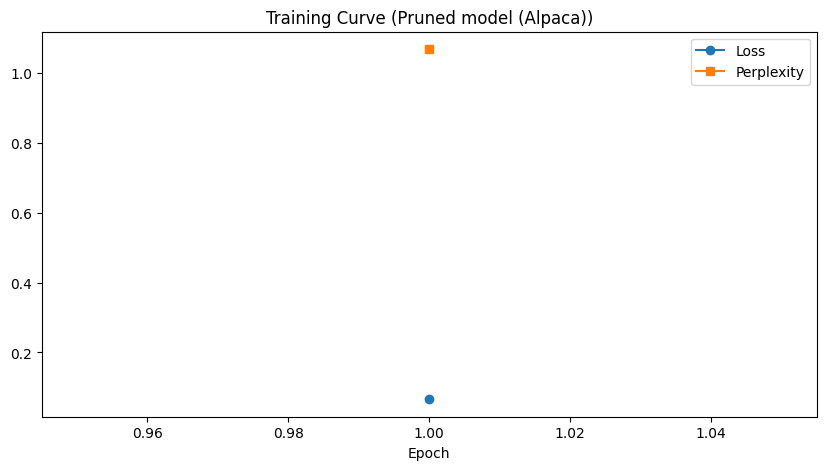

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/1


Epoch 1: 100%|██████████| 25481/25481 [40:48<00:00, 10.41it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.0041 | Perplexity: 1.00


🔍 Evaluating: 100%|██████████| 521/521 [30:00<00:00,  3.46s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Explain how increasing the habit of reading can improve a person's life

### Response:
Reading books can have a profound effect on a person's life. It can help broaden one's perspectives, expand their knowledge and vocabulary, and develop creativity and empathy. Reading offers an opportunity to experience new worlds, explore ideas and cultures, and even escape from reality. In addition, reading can improve a person’s communication skills, as well as their understanding of different concepts. It can also improve their memory, concentration, and problem-solving skills. Overall, reading can open up new opportunities in life, foster a greater appreciation for reading, and enhance critical thinking and reasoning abilities.
🔸 Prediction 1:
Reading books can have a profound effect on a person's life. It can help broaden one's perspectives, expand their knowledge and vocabulary, and develop creativity and empathy. Reading offers an opportun

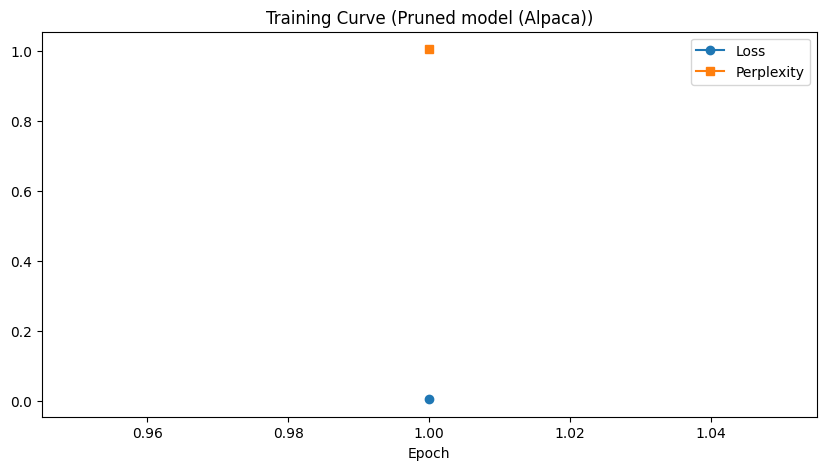

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/1


Epoch 1:   2%|▏         | 396/25481 [00:38<40:17, 10.37it/s, loss=0.0000]

In [ ]:
model_pruned = deepcopy(base_model)
print(f"\n Training Pruned model on {name} dataset")
model_pruned = patch_model(model_pruned, config={"prune": True})
df_pruned, pruned_eval = report(model_pruned, train_dl, val_dl, tokenizer, epochs=1, variant_name=f"Pruned model ({name})")
model_pruned = patch_model(model_pruned, config={"prune": True})
df_pruned, pruned_eval = report(model_pruned, train_dl, val_dl, tokenizer, epochs=1, variant_name=f"Pruned model ({name})")
model_pruned = patch_model(model_pruned, config={"prune": True})
df_pruned, pruned_eval = report(model_pruned, train_dl, val_dl, tokenizer, epochs=1, variant_name=f"Pruned model ({name})")
model_pruned = patch_model(model_pruned, config={"prune": True})
df_pruned, pruned_eval = report(model_pruned, train_dl, val_dl, tokenizer, epochs=1, variant_name=f"Pruned model ({name})")
model_pruned = patch_model(model_pruned, config={"prune": True})
df_pruned, pruned_eval = report(model_pruned, train_dl, val_dl, tokenizer, epochs=1, variant_name=f"Pruned model ({name})")


 Training Stochastic model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/10


Epoch 1: 100%|██████████| 25481/25481 [43:23<00:00,  9.79it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.1057 | Perplexity: 1.11

🚀 Epoch 2/10


Epoch 2: 100%|██████████| 25481/25481 [43:24<00:00,  9.78it/s, loss=0.0000]


✅ Epoch 2 Avg Loss: 0.0054 | Perplexity: 1.01

🚀 Epoch 3/10


Epoch 3: 100%|██████████| 25481/25481 [43:16<00:00,  9.81it/s, loss=0.0000]


✅ Epoch 3 Avg Loss: 0.0036 | Perplexity: 1.00

🚀 Epoch 4/10


Epoch 4: 100%|██████████| 25481/25481 [43:21<00:00,  9.80it/s, loss=0.0000]


✅ Epoch 4 Avg Loss: 0.0009 | Perplexity: 1.00

🚀 Epoch 5/10


Epoch 5: 100%|██████████| 25481/25481 [43:22<00:00,  9.79it/s, loss=0.0000]


✅ Epoch 5 Avg Loss: 0.0004 | Perplexity: 1.00

🚀 Epoch 6/10


Epoch 6: 100%|██████████| 25481/25481 [43:20<00:00,  9.80it/s, loss=0.0000]


✅ Epoch 6 Avg Loss: 0.0005 | Perplexity: 1.00

🚀 Epoch 7/10


Epoch 7: 100%|██████████| 25481/25481 [43:19<00:00,  9.80it/s, loss=0.0000]


✅ Epoch 7 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 8/10


Epoch 8: 100%|██████████| 25481/25481 [43:19<00:00,  9.80it/s, loss=0.0000]


✅ Epoch 8 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 9/10


Epoch 9: 100%|██████████| 25481/25481 [43:18<00:00,  9.81it/s, loss=0.0000]


✅ Epoch 9 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 10/10


Epoch 10: 100%|██████████| 25481/25481 [43:20<00:00,  9.80it/s, loss=0.0000]


✅ Epoch 10 Avg Loss: 0.0000 | Perplexity: 1.00


🔍 Evaluating: 100%|██████████| 521/521 [30:33<00:00,  3.52s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Using the given sentence, construct a valid English sentence.

### Input:
Dogs of many

### Response:
Dogs of many different breeds can be found around the world.
🔸 Prediction 1:
Dogs of many different breeds can be found around the world.................................................................................................................................
✅ Reference 1:
Dogs of many different breeds can be found around the world.

📜 Prompt 2:
### Instruction:
Rewrite the following poem without changing its meaning: 

The sun goes down and the moon comes up
It's a never-ending cycle for sure

### Response:
As the sun sets, the moon arises
In a perpetual sequence for certain.
🔸 Prediction 2:
As the sun sets, the moon arises
In a perpetual sequence for certain.................................................................................................................................
✅ Reference 2:
As the sun sets, the moo

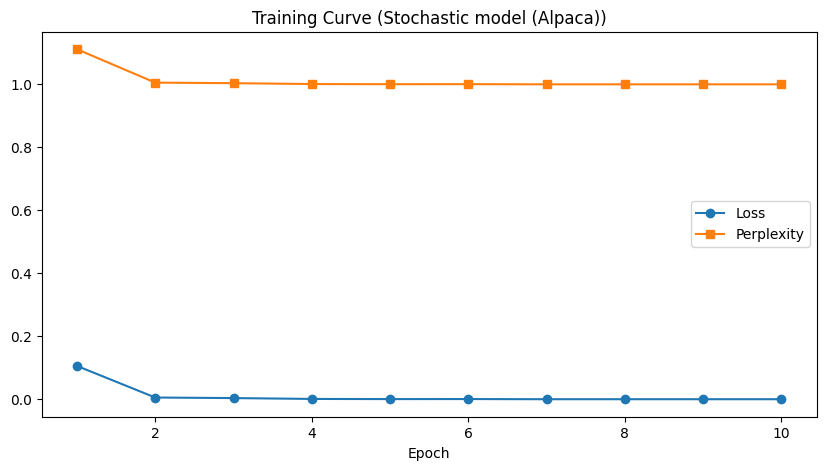

In [ ]:
model_stochastic = deepcopy(base_model)
print(f"\n Training Stochastic model on {name} dataset")
model_stochastic = patch_model(model_stochastic, config={"stochastic": True})
df_stochastic, stochastic_eval = report(model_stochastic, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Stochastic model ({name})")


 Training Memory Approximate model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/10


Epoch 1: 100%|██████████| 25481/25481 [43:42<00:00,  9.71it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.0163 | Perplexity: 1.02

🚀 Epoch 2/10


Epoch 2: 100%|██████████| 25481/25481 [43:41<00:00,  9.72it/s, loss=0.0000]


✅ Epoch 2 Avg Loss: 0.0010 | Perplexity: 1.00

🚀 Epoch 3/10


Epoch 3: 100%|██████████| 25481/25481 [43:43<00:00,  9.71it/s, loss=0.0000]


✅ Epoch 3 Avg Loss: 0.0011 | Perplexity: 1.00

🚀 Epoch 4/10


Epoch 4: 100%|██████████| 25481/25481 [43:52<00:00,  9.68it/s, loss=0.0000]


✅ Epoch 4 Avg Loss: 0.0002 | Perplexity: 1.00

🚀 Epoch 5/10


Epoch 5: 100%|██████████| 25481/25481 [43:36<00:00,  9.74it/s, loss=0.0000]


✅ Epoch 5 Avg Loss: 0.0001 | Perplexity: 1.00

🚀 Epoch 6/10


Epoch 6: 100%|██████████| 25481/25481 [43:36<00:00,  9.74it/s, loss=0.0000]


✅ Epoch 6 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 7/10


Epoch 7: 100%|██████████| 25481/25481 [43:40<00:00,  9.72it/s, loss=0.0000]


✅ Epoch 7 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 8/10


Epoch 8: 100%|██████████| 25481/25481 [43:38<00:00,  9.73it/s, loss=0.0000]


✅ Epoch 8 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 9/10


Epoch 9: 100%|██████████| 25481/25481 [43:33<00:00,  9.75it/s, loss=0.0000]


✅ Epoch 9 Avg Loss: 0.0000 | Perplexity: 1.00

🚀 Epoch 10/10


Epoch 10: 100%|██████████| 25481/25481 [43:30<00:00,  9.76it/s, loss=0.0000]


✅ Epoch 10 Avg Loss: 0.0000 | Perplexity: 1.00


🔍 Evaluating: 100%|██████████| 521/521 [30:39<00:00,  3.53s/it]



🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
How would you rate the following restaurant on a scale of 1 to 5 stars?

### Input:
The Boathouse Seafood Restaurant

### Response:
I would rate the Boathouse Seafood Restaurant 4 stars. They have excellent seafood dishes and a friendly staff. The atmosphere is also great.
🔸 Prediction 1:
I would rate the Boathouse Seafood Restaurant 4 stars. They have excellent seafood dishes and a friendly staff. The atmosphere is also great.................................................................................................................................
✅ Reference 1:
I would rate the Boathouse Seafood Restaurant 4 stars. They have excellent seafood dishes and a friendly staff. The atmosphere is also great.

📜 Prompt 2:
### Instruction:
Generate a slogan for an online platform aiming to provide pragmatic resources to developers.

### Response:
"Real-world solutions for real-world developers - Bringing clarity, efficiency and product

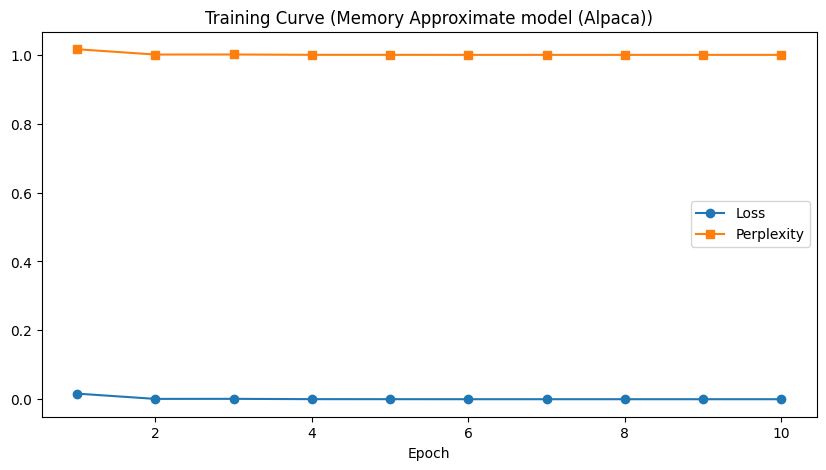

In [ ]:
model_memapprox = deepcopy(base_model)
print(f"\n Training Memory Approximate model on {name} dataset")
model_memapprox = patch_model(model_memapprox, config={"memory_approx": True})
df_memapprox, memapprox_eval = report(model_memapprox, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Memory Approximate model ({name})")


 Training Int8 Quantized model on Alpaca dataset

🚀 Epoch 1/5


Epoch 1: 100%|██████████| 25481/25481 [43:01<00:00,  9.87it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.1052 | Perplexity: 1.11

🚀 Epoch 2/5


Epoch 2: 100%|██████████| 25481/25481 [43:05<00:00,  9.86it/s, loss=0.0000]


✅ Epoch 2 Avg Loss: 0.0015 | Perplexity: 1.00

🚀 Epoch 3/5


Epoch 3: 100%|██████████| 25481/25481 [43:02<00:00,  9.87it/s, loss=0.0000]


✅ Epoch 3 Avg Loss: 0.0004 | Perplexity: 1.00

🚀 Epoch 4/5


Epoch 4: 100%|██████████| 25481/25481 [43:02<00:00,  9.87it/s, loss=0.0000]


✅ Epoch 4 Avg Loss: 0.0001 | Perplexity: 1.00

🚀 Epoch 5/5


Epoch 5: 100%|██████████| 25481/25481 [43:03<00:00,  9.86it/s, loss=0.0000]


✅ Epoch 5 Avg Loss: 0.0000 | Perplexity: 1.00


🔍 Evaluating: 100%|██████████| 521/521 [29:28<00:00,  3.39s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
How would you rate the following restaurant on a scale of 1 to 5 stars?

### Input:
The Boathouse Seafood Restaurant

### Response:
I would rate the Boathouse Seafood Restaurant 4 stars. They have excellent seafood dishes and a friendly staff. The atmosphere is also great.
🔸 Prediction 1:
I would rate the Boathouse Seafood Restaurant 4 stars. They have excellent seafood dishes and a friendly staff. The atmosphere is also great.................................................................................................................................
✅ Reference 1:
I would rate the Boathouse Seafood Restaurant 4 stars. They have excellent seafood dishes and a friendly staff. The atmosphere is also great.

📜 Prompt 2:
### Instruction:
Generate a slogan for an online platform aiming to provide pragmatic resources to developers.

### Response:
"Real-world solutions for real-world developers - Bringing clarity, efficiency and product

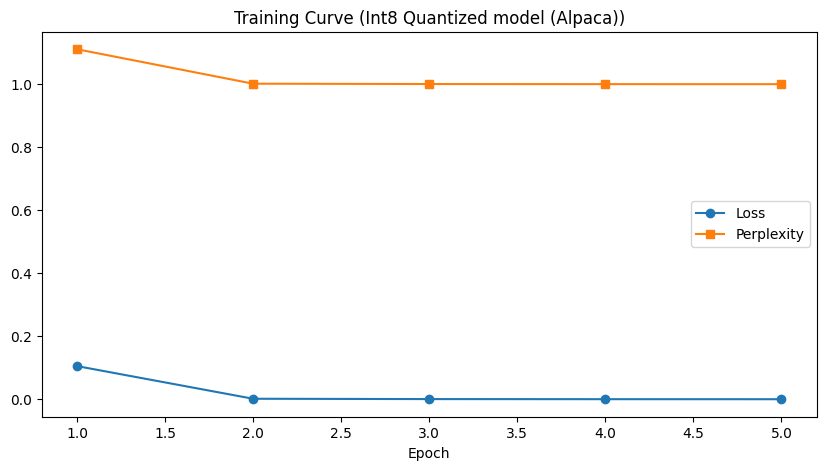

In [ ]:
model_int8 = deepcopy(base_model)
print(f"\n Training Int8 Quantized model on {name} dataset")
quantize_model_weights(model_int8, method="int8")
df_int8, int8_eval = report(model_int8, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Int8 Quantized model ({name})")


 Training Int4 Quantized model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/5


Epoch 1: 100%|██████████| 25481/25481 [42:36<00:00,  9.97it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.1286 | Perplexity: 1.14

🚀 Epoch 2/5


Epoch 2: 100%|██████████| 25481/25481 [42:34<00:00,  9.97it/s, loss=0.0000]


✅ Epoch 2 Avg Loss: 0.0031 | Perplexity: 1.00

🚀 Epoch 3/5


Epoch 3: 100%|██████████| 25481/25481 [42:39<00:00,  9.96it/s, loss=0.0000]


✅ Epoch 3 Avg Loss: 0.0024 | Perplexity: 1.00

🚀 Epoch 4/5


Epoch 4: 100%|██████████| 25481/25481 [42:40<00:00,  9.95it/s, loss=0.0000]


✅ Epoch 4 Avg Loss: 0.0005 | Perplexity: 1.00

🚀 Epoch 5/5


Epoch 5: 100%|██████████| 25481/25481 [42:33<00:00,  9.98it/s, loss=0.0000]


✅ Epoch 5 Avg Loss: 0.0000 | Perplexity: 1.00


🔍 Evaluating: 100%|██████████| 521/521 [29:30<00:00,  3.40s/it]



🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Identify what is wrong with the given list and provide the correct order.

### Input:
3, 4, 1, 6, 8

### Response:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.
🔸 Prediction 1:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.................................................................................................................................
✅ Reference 1:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.

📜 Prompt 2:
### Instruction:
Describe the protagonist's struggle in "The Great Gatsby"

### Response:
The protagonist of The Great Gatsby, Jay Gatsby, is a self-made man from humble beginnings who is obsessed with recapturing the love of his life, Daisy Buchanan. Throughout the novel, Gatsby faces many obstacles in his quest, including Daisy's blatant disregard f

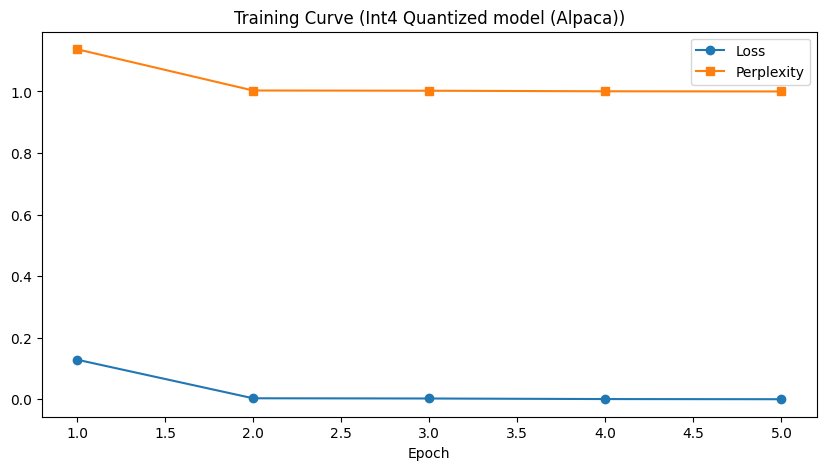

In [ ]:
model_int4 = deepcopy(base_model)
print(f"\n Training Int4 Quantized model on {name} dataset")
quantize_model_weights(model_int4, method="int4")
df_int4, int4_eval = report(model_int4, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Int4 Quantized model ({name})")


 Training NF4 Quantized model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Epoch 1/5


Epoch 1: 100%|██████████| 25481/25481 [42:41<00:00,  9.95it/s, loss=0.0000]


✅ Epoch 1 Avg Loss: 0.0605 | Perplexity: 1.06

🚀 Epoch 2/5


Epoch 2: 100%|██████████| 25481/25481 [42:45<00:00,  9.93it/s, loss=0.0000]


✅ Epoch 2 Avg Loss: 0.0052 | Perplexity: 1.01

🚀 Epoch 3/5


Epoch 3: 100%|██████████| 25481/25481 [42:38<00:00,  9.96it/s, loss=0.0000]


✅ Epoch 3 Avg Loss: 0.0023 | Perplexity: 1.00

🚀 Epoch 4/5


Epoch 4: 100%|██████████| 25481/25481 [42:37<00:00,  9.96it/s, loss=0.0000]


✅ Epoch 4 Avg Loss: 0.0004 | Perplexity: 1.00

🚀 Epoch 5/5


Epoch 5: 100%|██████████| 25481/25481 [42:43<00:00,  9.94it/s, loss=0.0000]


✅ Epoch 5 Avg Loss: 0.0000 | Perplexity: 1.00


🔍 Evaluating: 100%|██████████| 521/521 [29:23<00:00,  3.38s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Identify what is wrong with the given list and provide the correct order.

### Input:
3, 4, 1, 6, 8

### Response:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.
🔸 Prediction 1:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.................................................................................................................................
✅ Reference 1:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.

📜 Prompt 2:
### Instruction:
Describe the protagonist's struggle in "The Great Gatsby"

### Response:
The protagonist of The Great Gatsby, Jay Gatsby, is a self-made man from humble beginnings who is obsessed with recapturing the love of his life, Daisy Buchanan. Throughout the novel, Gatsby faces many obstacles in his quest, including Daisy's blatant disregard f

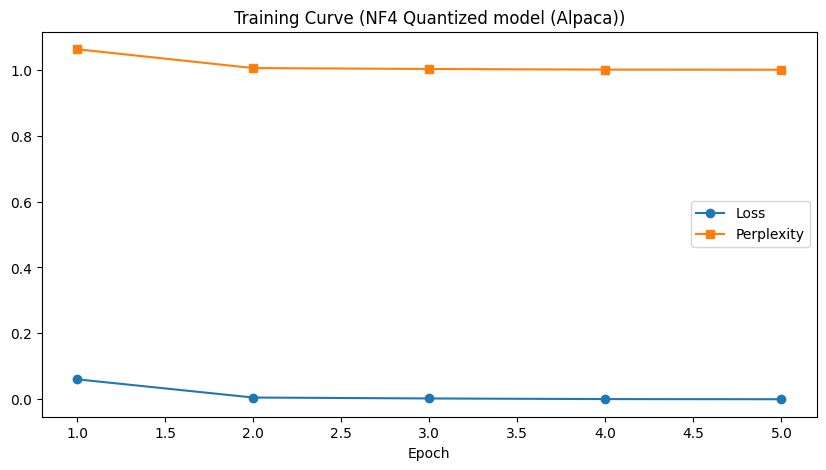

In [ ]:
model_nf4 = deepcopy(base_model)
print(f"\n Training NF4 Quantized model on {name} dataset")
quantize_model_weights(model_nf4, method="nf4")
df_nf4, nf4_eval = report(model_nf4, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"NF4 Quantized model ({name})")

In [ ]:
model_spin = deepcopy(base_model)
print(f"\n Training SpinQuant model on {name} dataset")
model_spin = spinquant_approx(model_spin, bits=4)
df_spin, spin_eval = report(model_spin, train_dl, val_dl, tokenizer, epochs=1, variant_name=f"SpinQuant model ({name})")


 Training SpinQuant model on Alpaca dataset


Applying R4 rotation to W_down: 100%|██████████| 16/16 [00:00<00:00, 184.22layer/s]
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4225: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
The cos_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
The sin_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
Inserting weight quantizer: 100%|██████████| 16/16 [00:01<00:00,  9.60it/s]
/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

[SpinQuant] Applied 4-bit quantization (W, A, K, V) with Hadamard rotations.

🚀 Epoch 1/1


Epoch 1: 100%|██████████| 25481/25481 [1:48:46<00:00,  3.90it/s, loss=0.0001]


✅ Epoch 1 Avg Loss: 0.0532 | Perplexity: 1.05


🔍 Evaluating:  71%|███████   | 368/521 [1:37:27<40:30, 15.88s/it]


 Training Pruned LoRA model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.06889230774326355

🚀 Epoch 1/10


Epoch 1: 100%|██████████| 25481/25481 [37:50<00:00, 11.22it/s, loss=0.0025]


✅ Epoch 1 Avg Loss: 0.4203 | Perplexity: 1.52

🚀 Epoch 2/10


Epoch 2: 100%|██████████| 25481/25481 [38:09<00:00, 11.13it/s, loss=0.0156]


✅ Epoch 2 Avg Loss: 0.0644 | Perplexity: 1.07

🚀 Epoch 3/10


Epoch 3: 100%|██████████| 25481/25481 [38:11<00:00, 11.12it/s, loss=0.0453]


✅ Epoch 3 Avg Loss: 0.0443 | Perplexity: 1.05

🚀 Epoch 4/10


Epoch 4: 100%|██████████| 25481/25481 [37:57<00:00, 11.19it/s, loss=0.1154]


✅ Epoch 4 Avg Loss: 0.1691 | Perplexity: 1.18

🚀 Epoch 5/10


Epoch 5: 100%|██████████| 25481/25481 [38:08<00:00, 11.13it/s, loss=0.0450]


✅ Epoch 5 Avg Loss: 0.1240 | Perplexity: 1.13

🚀 Epoch 6/10


Epoch 6: 100%|██████████| 25481/25481 [37:59<00:00, 11.18it/s, loss=0.0512]


✅ Epoch 6 Avg Loss: 0.1174 | Perplexity: 1.12

🚀 Epoch 7/10


Epoch 7: 100%|██████████| 25481/25481 [38:03<00:00, 11.16it/s, loss=0.0148]


✅ Epoch 7 Avg Loss: 0.1182 | Perplexity: 1.13

🚀 Epoch 8/10


Epoch 8: 100%|██████████| 25481/25481 [37:56<00:00, 11.20it/s, loss=0.0285]


✅ Epoch 8 Avg Loss: 0.1066 | Perplexity: 1.11

🚀 Epoch 9/10


Epoch 9: 100%|██████████| 25481/25481 [38:31<00:00, 11.02it/s, loss=0.0942]


✅ Epoch 9 Avg Loss: 0.0931 | Perplexity: 1.10

🚀 Epoch 10/10


Epoch 10: 100%|██████████| 25481/25481 [37:54<00:00, 11.20it/s, loss=0.0521]


✅ Epoch 10 Avg Loss: 0.0830 | Perplexity: 1.09


🔍 Evaluating: 100%|██████████| 521/521 [35:51<00:00,  4.13s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Identify what is wrong with the given list and provide the correct order.

### Input:
3, 4, 1, 6, 8

### Response:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.
🔸 Prediction 1:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.----S- S-------------------------------------------------------------------,,----------,,----------------------------------------
✅ Reference 1:
The items in the list are not arranged in numerical order. The correct order should be 1, 3, 4, 6, 8.

📜 Prompt 2:
### Instruction:
Describe the protagonist's struggle in "The Great Gatsby"

### Response:
The protagonist of The Great Gatsby, Jay Gatsby, is a self-made man from humble beginnings who is obsessed with recapturing the love of his life, Daisy Buchanan. Throughout the novel, Gatsby faces many obstacles in his quest, including Daisy's blatant disregard 

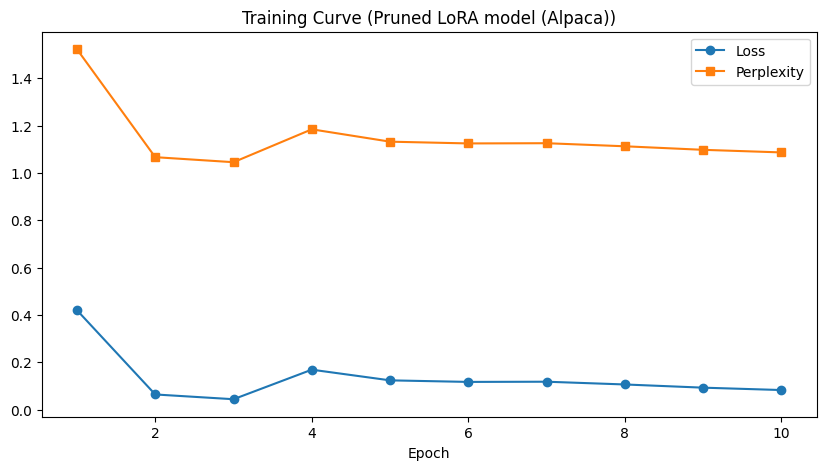

In [ ]:
model_pruned_lora = deepcopy(base_model)
print(f"\n Training Pruned LoRA model on {name} dataset")
model_pruned_lora = patch_model(model_pruned_lora, config={"prune": True})
model_pruned_lora = patch_model(model_pruned_lora, config={"lora": True})
df_pruned_lora, pruned_lora_eval = report(model_pruned_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Pruned LoRA model ({name})")

In [ ]:
model_actquant_lora = deepcopy(base_model)
print(f"\n Training Activation Quantized LoRA model on {name} dataset")
model_actquant_lora = patch_model(model_actquant_lora, config={"activation_quant": True})
model_actquant_lora = patch_model(model_actquant_lora, config={"lora": True})
df_actquant, actquant_eval = report(model_actquant_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Activation Quantized LoRA model ({name})")


 Training Activation Quantized LoRA model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.06889230774326355

🚀 Epoch 1/3


Epoch 1: 100%|██████████| 25481/25481 [44:26<00:00,  9.56it/s, loss=0.0054]


✅ Epoch 1 Avg Loss: 0.2105 | Perplexity: 1.23

🚀 Epoch 2/3


Epoch 2:  65%|██████▌   | 16597/25481 [29:00<10:31, 14.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16603/25481 [29:00<08:02, 18.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16609/25481 [29:01<07:18, 20.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16612/25481 [29:01<07:09, 20.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16618/25481 [29:01<06:56, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16624/25481 [29:01<06:50, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16627/25481 [29:01<06:49, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16633/25481 [29:02<06:48, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16639/25481 [29:02<06:51, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16642/25481 [29:02<06:51, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16648/25481 [29:02<06:48, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16654/25481 [29:03<06:49, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16657/25481 [29:03<06:49, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16663/25481 [29:03<06:49, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16669/25481 [29:03<06:48, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16672/25481 [29:04<06:47, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16678/25481 [29:04<06:46, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16684/25481 [29:04<06:45, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  65%|██████▌   | 16687/25481 [29:04<06:45, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16693/25481 [29:05<06:43, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16699/25481 [29:05<06:42, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16702/25481 [29:05<06:44, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16708/25481 [29:05<06:44, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16714/25481 [29:06<06:46, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16717/25481 [29:06<06:48, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16723/25481 [29:06<06:45, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16729/25481 [29:06<06:49, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16732/25481 [29:06<06:48, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16738/25481 [29:07<06:47, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16744/25481 [29:07<06:46, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16747/25481 [29:07<06:46, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16753/25481 [29:07<06:47, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16759/25481 [29:08<06:46, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16762/25481 [29:08<06:46, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16768/25481 [29:08<06:45, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16774/25481 [29:08<06:47, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16777/25481 [29:08<06:44, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16783/25481 [29:09<06:40, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16789/25481 [29:09<06:35, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16792/25481 [29:09<06:36, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16798/25481 [29:09<06:37, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16804/25481 [29:10<06:40, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16807/25481 [29:10<06:41, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16813/25481 [29:10<06:42, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16819/25481 [29:10<06:41, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16822/25481 [29:11<06:41, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16828/25481 [29:11<06:40, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16834/25481 [29:11<06:42, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16837/25481 [29:11<06:44, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16843/25481 [29:12<06:44, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16849/25481 [29:12<06:44, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16852/25481 [29:12<06:45, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16858/25481 [29:12<06:41, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16864/25481 [29:12<06:39, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16867/25481 [29:13<06:38, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16873/25481 [29:13<06:40, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▌   | 16879/25481 [29:13<06:35, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16882/25481 [29:13<06:40, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16888/25481 [29:14<06:38, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16894/25481 [29:14<06:34, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16897/25481 [29:14<06:34, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16903/25481 [29:14<06:38, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16909/25481 [29:15<06:41, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16912/25481 [29:15<06:40, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16918/25481 [29:15<06:39, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16924/25481 [29:15<06:38, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16927/25481 [29:15<06:39, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16933/25481 [29:16<06:41, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16939/25481 [29:16<06:41, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  66%|██████▋   | 16942/25481 [29:16<06:44, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16948/25481 [29:16<06:46, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16954/25481 [29:17<06:42, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16957/25481 [29:17<06:42, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16963/25481 [29:17<06:40, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16969/25481 [29:17<06:37, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16972/25481 [29:18<06:35, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16978/25481 [29:18<06:30, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16984/25481 [29:18<06:33, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16987/25481 [29:18<06:34, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16993/25481 [29:19<06:38, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 16999/25481 [29:19<06:30, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17002/25481 [29:19<06:28, 21.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17008/25481 [29:19<06:29, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17014/25481 [29:19<06:31, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17017/25481 [29:20<06:36, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17023/25481 [29:20<06:32, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17029/25481 [29:20<06:29, 21.71it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17032/25481 [29:20<06:26, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17038/25481 [29:21<06:20, 22.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17044/25481 [29:21<06:18, 22.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17047/25481 [29:21<06:18, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17053/25481 [29:21<06:18, 22.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17059/25481 [29:22<06:15, 22.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17062/25481 [29:22<06:15, 22.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17068/25481 [29:22<06:16, 22.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17074/25481 [29:22<06:20, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17077/25481 [29:22<06:23, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17083/25481 [29:23<06:21, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17089/25481 [29:23<06:18, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17092/25481 [29:23<06:17, 22.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17098/25481 [29:23<06:20, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17104/25481 [29:24<06:19, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17107/25481 [29:24<06:21, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17113/25481 [29:24<06:27, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17119/25481 [29:24<06:24, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17122/25481 [29:24<06:26, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17128/25481 [29:25<06:28, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17134/25481 [29:25<06:29, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17137/25481 [29:25<06:29, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17143/25481 [29:25<06:27, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17149/25481 [29:26<06:30, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17152/25481 [29:26<06:32, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17158/25481 [29:26<06:31, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17164/25481 [29:26<06:29, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17167/25481 [29:26<06:26, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17173/25481 [29:27<06:24, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17179/25481 [29:27<06:23, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17182/25481 [29:27<06:22, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17188/25481 [29:27<06:20, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17194/25481 [29:28<06:18, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  67%|██████▋   | 17197/25481 [29:28<06:18, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17203/25481 [29:28<06:19, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17209/25481 [29:28<06:19, 21.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17212/25481 [29:29<06:18, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17218/25481 [29:29<06:15, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17224/25481 [29:29<06:16, 21.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17227/25481 [29:29<06:14, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17233/25481 [29:30<06:13, 22.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17239/25481 [29:30<06:13, 22.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17242/25481 [29:30<06:12, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17248/25481 [29:30<06:13, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17254/25481 [29:30<06:10, 22.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17257/25481 [29:31<06:10, 22.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17263/25481 [29:31<06:09, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17269/25481 [29:31<06:08, 22.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17272/25481 [29:31<06:08, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17278/25481 [29:32<06:06, 22.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17284/25481 [29:32<06:07, 22.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17287/25481 [29:32<06:08, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17293/25481 [29:32<06:17, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17299/25481 [29:32<06:18, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17302/25481 [29:33<06:18, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17308/25481 [29:33<06:17, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17314/25481 [29:33<06:15, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17317/25481 [29:33<06:14, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17323/25481 [29:34<06:12, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17329/25481 [29:34<06:14, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17332/25481 [29:34<06:17, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17338/25481 [29:34<06:16, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17344/25481 [29:35<06:17, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17347/25481 [29:35<06:18, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17353/25481 [29:35<06:19, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17359/25481 [29:35<06:17, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17362/25481 [29:35<06:17, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17368/25481 [29:36<06:16, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17374/25481 [29:36<06:17, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17377/25481 [29:36<06:27, 20.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17383/25481 [29:36<06:23, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17389/25481 [29:37<06:24, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17392/25481 [29:37<06:23, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17398/25481 [29:37<06:21, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17404/25481 [29:37<06:19, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17407/25481 [29:38<06:13, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17413/25481 [29:38<06:08, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17419/25481 [29:38<06:06, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17422/25481 [29:38<06:05, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17428/25481 [29:38<06:05, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17434/25481 [29:39<06:07, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17437/25481 [29:39<06:07, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17443/25481 [29:39<06:06, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17449/25481 [29:39<06:06, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  68%|██████▊   | 17452/25481 [29:40<06:06, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17458/25481 [29:40<06:06, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17464/25481 [29:40<06:07, 21.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17467/25481 [29:40<06:10, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17473/25481 [29:41<06:06, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17479/25481 [29:41<06:00, 22.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17482/25481 [29:41<05:58, 22.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17488/25481 [29:41<05:58, 22.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17494/25481 [29:41<06:00, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17497/25481 [29:42<06:01, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17503/25481 [29:42<06:00, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17509/25481 [29:42<05:59, 22.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17512/25481 [29:42<05:59, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▊   | 17518/25481 [29:43<06:00, 22.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17524/25481 [29:43<05:56, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17527/25481 [29:43<05:54, 22.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17533/25481 [29:43<06:00, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17539/25481 [29:44<06:02, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17542/25481 [29:44<06:03, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17548/25481 [29:44<06:04, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17554/25481 [29:44<06:12, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17557/25481 [29:44<06:13, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17563/25481 [29:45<06:11, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17569/25481 [29:45<06:14, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17572/25481 [29:45<06:15, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17578/25481 [29:45<06:18, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17584/25481 [29:46<06:18, 20.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17587/25481 [29:46<06:19, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17593/25481 [29:46<06:19, 20.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17599/25481 [29:46<06:20, 20.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17602/25481 [29:47<06:18, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17608/25481 [29:47<06:14, 21.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17614/25481 [29:47<06:12, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17617/25481 [29:47<06:15, 20.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17623/25481 [29:48<06:12, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17629/25481 [29:48<06:08, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17632/25481 [29:48<06:14, 20.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17638/25481 [29:48<06:09, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17644/25481 [29:48<06:02, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17647/25481 [29:49<06:00, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17653/25481 [29:49<05:55, 22.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17659/25481 [29:49<05:51, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17662/25481 [29:49<05:57, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17668/25481 [29:50<05:58, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17674/25481 [29:50<05:55, 21.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17677/25481 [29:50<05:54, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17683/25481 [29:50<05:55, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17689/25481 [29:51<06:01, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17692/25481 [29:51<06:00, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17698/25481 [29:51<05:59, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17704/25481 [29:51<05:56, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  69%|██████▉   | 17707/25481 [29:51<05:58, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17713/25481 [29:52<05:52, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17719/25481 [29:52<05:50, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17722/25481 [29:52<05:50, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17728/25481 [29:52<05:52, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17734/25481 [29:53<05:50, 22.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17737/25481 [29:53<05:50, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17743/25481 [29:53<05:48, 22.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17749/25481 [29:53<05:46, 22.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17752/25481 [29:53<05:45, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17758/25481 [29:54<05:43, 22.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17764/25481 [29:54<05:42, 22.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17767/25481 [29:54<05:43, 22.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17773/25481 [29:54<05:46, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17779/25481 [29:55<05:44, 22.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17782/25481 [29:55<05:44, 22.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17788/25481 [29:55<05:42, 22.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17794/25481 [29:55<05:40, 22.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17797/25481 [29:55<05:41, 22.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17803/25481 [29:56<05:39, 22.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17809/25481 [29:56<05:42, 22.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17812/25481 [29:56<05:43, 22.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17818/25481 [29:56<05:55, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17824/25481 [29:57<05:47, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17827/25481 [29:57<05:46, 22.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|██████▉   | 17833/25481 [29:57<05:45, 22.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17839/25481 [29:57<05:42, 22.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17842/25481 [29:57<05:42, 22.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17848/25481 [29:58<05:39, 22.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17854/25481 [29:58<05:38, 22.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17857/25481 [29:58<05:41, 22.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17863/25481 [29:58<05:42, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17869/25481 [29:59<05:42, 22.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17872/25481 [29:59<05:40, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17878/25481 [29:59<05:46, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17884/25481 [29:59<05:46, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17887/25481 [29:59<05:45, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17893/25481 [30:00<05:45, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17899/25481 [30:00<05:42, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17902/25481 [30:00<05:41, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17908/25481 [30:00<05:48, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17914/25481 [30:01<05:45, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17917/25481 [30:01<05:44, 21.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17923/25481 [30:01<05:43, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17929/25481 [30:01<05:40, 22.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17932/25481 [30:02<05:38, 22.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17938/25481 [30:02<05:36, 22.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17944/25481 [30:02<05:36, 22.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17947/25481 [30:02<05:42, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17953/25481 [30:02<05:39, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17959/25481 [30:03<05:37, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  70%|███████   | 17962/25481 [30:03<05:36, 22.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17968/25481 [30:03<05:36, 22.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17974/25481 [30:03<05:37, 22.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17977/25481 [30:04<05:36, 22.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17983/25481 [30:04<05:35, 22.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17989/25481 [30:04<05:36, 22.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17992/25481 [30:04<05:42, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 17998/25481 [30:04<05:37, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18004/25481 [30:05<05:33, 22.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18007/25481 [30:05<05:31, 22.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18013/25481 [30:05<05:29, 22.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18019/25481 [30:05<05:34, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18022/25481 [30:06<05:33, 22.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18028/25481 [30:06<05:36, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18034/25481 [30:06<05:33, 22.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18037/25481 [30:06<05:37, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18043/25481 [30:07<05:32, 22.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18049/25481 [30:07<05:32, 22.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18052/25481 [30:07<05:33, 22.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18058/25481 [30:07<05:32, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18064/25481 [30:07<05:31, 22.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18067/25481 [30:08<05:31, 22.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18073/25481 [30:08<05:30, 22.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18079/25481 [30:08<05:31, 22.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18082/25481 [30:08<05:34, 22.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18088/25481 [30:09<05:35, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18094/25481 [30:09<05:33, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18097/25481 [30:09<05:33, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18103/25481 [30:09<05:30, 22.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18109/25481 [30:09<05:27, 22.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18112/25481 [30:10<05:28, 22.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18118/25481 [30:10<05:28, 22.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18124/25481 [30:10<05:30, 22.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18127/25481 [30:10<05:28, 22.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18133/25481 [30:11<05:24, 22.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18139/25481 [30:11<05:23, 22.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18142/25481 [30:11<05:24, 22.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18148/25481 [30:11<05:24, 22.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████   | 18154/25481 [30:11<05:32, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18157/25481 [30:12<05:33, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18163/25481 [30:12<05:27, 22.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18169/25481 [30:12<05:24, 22.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18172/25481 [30:12<05:24, 22.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18178/25481 [30:13<05:27, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18184/25481 [30:13<05:31, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18187/25481 [30:13<05:32, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18193/25481 [30:13<05:33, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18199/25481 [30:14<05:31, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18202/25481 [30:14<05:31, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18208/25481 [30:14<05:31, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18214/25481 [30:14<05:32, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  71%|███████▏  | 18217/25481 [30:14<05:31, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18223/25481 [30:15<05:31, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18229/25481 [30:15<05:31, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18232/25481 [30:15<05:31, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18238/25481 [30:15<05:29, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18244/25481 [30:16<05:27, 22.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18247/25481 [30:16<05:27, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18253/25481 [30:16<05:26, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18259/25481 [30:16<05:28, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18262/25481 [30:16<05:28, 21.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18268/25481 [30:17<05:27, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18274/25481 [30:17<05:27, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18277/25481 [30:17<05:26, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18283/25481 [30:17<05:24, 22.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18289/25481 [30:18<05:21, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18292/25481 [30:18<05:21, 22.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18298/25481 [30:18<05:20, 22.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18304/25481 [30:18<05:23, 22.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18307/25481 [30:18<05:22, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18313/25481 [30:19<05:21, 22.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18319/25481 [30:19<05:19, 22.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18322/25481 [30:19<05:19, 22.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18328/25481 [30:19<05:27, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18334/25481 [30:20<05:24, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18337/25481 [30:20<05:23, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18343/25481 [30:20<05:20, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18349/25481 [30:20<05:22, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18352/25481 [30:20<05:20, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18358/25481 [30:21<05:18, 22.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18364/25481 [30:21<05:17, 22.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18367/25481 [30:21<05:22, 22.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18373/25481 [30:21<05:24, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18379/25481 [30:22<05:28, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18382/25481 [30:22<05:29, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18388/25481 [30:22<05:31, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18394/25481 [30:22<05:39, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18397/25481 [30:23<05:37, 20.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18403/25481 [30:23<05:35, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18409/25481 [30:23<05:33, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18412/25481 [30:23<05:33, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18418/25481 [30:24<05:31, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18424/25481 [30:24<05:31, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18427/25481 [30:24<05:32, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18433/25481 [30:24<05:31, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18439/25481 [30:25<05:31, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18442/25481 [30:25<05:33, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18448/25481 [30:25<05:33, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18454/25481 [30:25<05:34, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18457/25481 [30:25<05:33, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18463/25481 [30:26<05:26, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18469/25481 [30:26<05:19, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  72%|███████▏  | 18472/25481 [30:26<05:18, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18478/25481 [30:26<05:19, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18484/25481 [30:27<05:18, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18487/25481 [30:27<05:20, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18493/25481 [30:27<05:24, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18499/25481 [30:27<05:30, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18502/25481 [30:27<05:32, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18508/25481 [30:28<05:30, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18514/25481 [30:28<05:30, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18517/25481 [30:28<05:32, 20.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18523/25481 [30:28<05:32, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18529/25481 [30:29<05:28, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18532/25481 [30:29<05:27, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18538/25481 [30:29<05:27, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18544/25481 [30:29<05:26, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18547/25481 [30:30<05:27, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18553/25481 [30:30<05:27, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18559/25481 [30:30<05:33, 20.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18562/25481 [30:30<05:31, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18568/25481 [30:31<05:31, 20.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18574/25481 [30:31<05:25, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18577/25481 [30:31<05:22, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18583/25481 [30:31<05:20, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18589/25481 [30:32<05:16, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18592/25481 [30:32<05:15, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18598/25481 [30:32<05:28, 20.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18601/25481 [30:32<05:28, 20.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18607/25481 [30:32<05:22, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18613/25481 [30:33<05:21, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18616/25481 [30:33<05:20, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18622/25481 [30:33<05:19, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18628/25481 [30:33<05:22, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18631/25481 [30:34<05:23, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18637/25481 [30:34<05:23, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18643/25481 [30:34<05:20, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18646/25481 [30:34<05:24, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18652/25481 [30:35<05:19, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18658/25481 [30:35<05:16, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18661/25481 [30:35<05:16, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18667/25481 [30:35<05:16, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18673/25481 [30:35<05:16, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18676/25481 [30:36<05:18, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18682/25481 [30:36<05:17, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18688/25481 [30:36<05:18, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18691/25481 [30:36<05:17, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18697/25481 [30:37<05:12, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18703/25481 [30:37<05:10, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18706/25481 [30:37<05:11, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18712/25481 [30:37<05:16, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18718/25481 [30:38<05:19, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18721/25481 [30:38<05:20, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  73%|███████▎  | 18727/25481 [30:38<05:19, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18733/25481 [30:38<05:22, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18736/25481 [30:38<05:20, 21.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18742/25481 [30:39<05:19, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18748/25481 [30:39<05:17, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18751/25481 [30:39<05:17, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18757/25481 [30:39<05:17, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18763/25481 [30:40<05:14, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18766/25481 [30:40<05:15, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18772/25481 [30:40<05:15, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18778/25481 [30:40<05:17, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18781/25481 [30:41<05:18, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▎  | 18787/25481 [30:41<05:18, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18793/25481 [30:41<05:13, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18796/25481 [30:41<05:12, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18802/25481 [30:42<05:09, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18808/25481 [30:42<05:08, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18811/25481 [30:42<05:08, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18817/25481 [30:42<05:13, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18823/25481 [30:43<05:11, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18826/25481 [30:43<05:14, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18832/25481 [30:43<05:13, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18838/25481 [30:43<05:11, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18841/25481 [30:43<05:12, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18847/25481 [30:44<05:13, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18853/25481 [30:44<05:17, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18856/25481 [30:44<05:18, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18862/25481 [30:44<05:15, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18868/25481 [30:45<05:18, 20.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18871/25481 [30:45<05:17, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18877/25481 [30:45<05:22, 20.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18883/25481 [30:45<05:16, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18886/25481 [30:46<05:14, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18892/25481 [30:46<05:09, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18898/25481 [30:46<05:02, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18901/25481 [30:46<05:03, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18907/25481 [30:47<05:06, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18913/25481 [30:47<05:01, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18916/25481 [30:47<04:59, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18922/25481 [30:47<05:06, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18928/25481 [30:47<05:06, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18931/25481 [30:48<05:05, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18937/25481 [30:48<05:04, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18943/25481 [30:48<05:07, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18946/25481 [30:48<05:07, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18952/25481 [30:49<05:06, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18958/25481 [30:49<05:05, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18961/25481 [30:49<05:06, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18967/25481 [30:49<05:06, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18973/25481 [30:50<05:09, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18976/25481 [30:50<05:10, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  74%|███████▍  | 18982/25481 [30:50<05:07, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 18988/25481 [30:50<05:09, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 18991/25481 [30:50<05:08, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 18997/25481 [30:51<05:05, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19003/25481 [30:51<05:07, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19006/25481 [30:51<05:05, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19012/25481 [30:51<05:00, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19018/25481 [30:52<04:58, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19021/25481 [30:52<04:57, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19027/25481 [30:52<04:57, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19033/25481 [30:52<04:59, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19036/25481 [30:53<05:02, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19042/25481 [30:53<05:04, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19048/25481 [30:53<05:06, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19051/25481 [30:53<05:07, 20.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19057/25481 [30:54<05:04, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19063/25481 [30:54<05:04, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19066/25481 [30:54<05:04, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19072/25481 [30:54<05:08, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19078/25481 [30:55<05:01, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19081/25481 [30:55<05:00, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19087/25481 [30:55<04:59, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19093/25481 [30:55<05:06, 20.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19096/25481 [30:55<05:04, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19102/25481 [30:56<05:02, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▍  | 19108/25481 [30:56<05:02, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19111/25481 [30:56<05:05, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19117/25481 [30:56<05:03, 20.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19123/25481 [30:57<05:01, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19126/25481 [30:57<04:58, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19132/25481 [30:57<04:51, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19138/25481 [30:57<04:49, 21.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19141/25481 [30:58<04:48, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19147/25481 [30:58<04:51, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19153/25481 [30:58<04:54, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19156/25481 [30:58<04:59, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19162/25481 [30:58<04:54, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19168/25481 [30:59<04:52, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19171/25481 [30:59<04:53, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19177/25481 [30:59<04:51, 21.65it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19183/25481 [30:59<04:55, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19186/25481 [31:00<04:54, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19192/25481 [31:00<04:53, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19198/25481 [31:00<04:52, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19201/25481 [31:00<04:52, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19207/25481 [31:01<04:54, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19213/25481 [31:01<04:53, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19216/25481 [31:01<04:52, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19222/25481 [31:01<04:52, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19228/25481 [31:02<04:49, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19231/25481 [31:02<04:46, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  75%|███████▌  | 19237/25481 [31:02<04:45, 21.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19243/25481 [31:02<04:46, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19246/25481 [31:02<04:45, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19252/25481 [31:03<04:45, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19258/25481 [31:03<04:47, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19261/25481 [31:03<04:48, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19267/25481 [31:03<04:51, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19273/25481 [31:04<04:54, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19276/25481 [31:04<04:59, 20.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19282/25481 [31:04<04:55, 20.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19288/25481 [31:04<04:58, 20.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19291/25481 [31:05<04:58, 20.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19297/25481 [31:05<04:54, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19303/25481 [31:05<04:54, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19306/25481 [31:05<04:55, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19312/25481 [31:06<04:51, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19318/25481 [31:06<04:49, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19321/25481 [31:06<04:48, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19327/25481 [31:06<04:46, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19333/25481 [31:07<04:49, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19336/25481 [31:07<04:46, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19342/25481 [31:07<04:43, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19348/25481 [31:07<04:39, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19351/25481 [31:07<04:43, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19357/25481 [31:08<04:49, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19360/25481 [31:08<04:53, 20.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19366/25481 [31:08<04:47, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19372/25481 [31:08<04:48, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19375/25481 [31:08<04:48, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19381/25481 [31:09<04:47, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19387/25481 [31:09<04:45, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19390/25481 [31:09<04:45, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19396/25481 [31:09<04:43, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19402/25481 [31:10<04:43, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19405/25481 [31:10<04:43, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19411/25481 [31:10<04:53, 20.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19414/25481 [31:10<04:52, 20.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19420/25481 [31:11<04:45, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19426/25481 [31:11<04:41, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▌  | 19429/25481 [31:11<04:44, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19435/25481 [31:11<04:43, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19441/25481 [31:12<04:41, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19444/25481 [31:12<04:38, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19450/25481 [31:12<04:35, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19453/25481 [31:12<04:41, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19459/25481 [31:12<04:42, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19465/25481 [31:13<04:38, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19468/25481 [31:13<04:38, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19474/25481 [31:13<04:38, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19480/25481 [31:13<04:41, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19483/25481 [31:14<04:39, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  76%|███████▋  | 19489/25481 [31:14<04:41, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19495/25481 [31:14<04:41, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19498/25481 [31:14<04:42, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19504/25481 [31:15<04:46, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19510/25481 [31:15<04:45, 20.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19513/25481 [31:15<04:42, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19519/25481 [31:15<04:38, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19525/25481 [31:16<04:41, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19528/25481 [31:16<04:40, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19534/25481 [31:16<04:39, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19540/25481 [31:16<04:41, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19543/25481 [31:16<04:42, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19549/25481 [31:17<04:41, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19555/25481 [31:17<04:34, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19558/25481 [31:17<04:32, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19564/25481 [31:17<04:34, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19570/25481 [31:18<04:31, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19573/25481 [31:18<04:31, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19579/25481 [31:18<04:33, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19585/25481 [31:18<04:37, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19588/25481 [31:18<04:37, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19594/25481 [31:19<04:35, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19600/25481 [31:19<04:36, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19603/25481 [31:19<04:36, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19609/25481 [31:19<04:36, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19615/25481 [31:20<04:35, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19618/25481 [31:20<04:34, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19624/25481 [31:20<04:37, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19630/25481 [31:20<04:35, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19633/25481 [31:21<04:35, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19639/25481 [31:21<04:34, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19645/25481 [31:21<04:36, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19648/25481 [31:21<04:36, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19654/25481 [31:22<04:33, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19660/25481 [31:22<04:30, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19663/25481 [31:22<04:29, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19669/25481 [31:22<04:29, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19675/25481 [31:23<04:29, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19678/25481 [31:23<04:27, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19684/25481 [31:23<04:28, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19690/25481 [31:23<04:30, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19693/25481 [31:23<04:31, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19699/25481 [31:24<04:28, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19705/25481 [31:24<04:27, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19708/25481 [31:24<04:29, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19714/25481 [31:24<04:30, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19720/25481 [31:25<04:30, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19723/25481 [31:25<04:30, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19729/25481 [31:25<04:31, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19735/25481 [31:25<04:29, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19738/25481 [31:25<04:30, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  77%|███████▋  | 19744/25481 [31:26<04:30, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19750/25481 [31:26<04:32, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19753/25481 [31:26<04:34, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19759/25481 [31:26<04:29, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19765/25481 [31:27<04:27, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19768/25481 [31:27<04:26, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19774/25481 [31:27<04:29, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19780/25481 [31:27<04:24, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19783/25481 [31:28<04:22, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19789/25481 [31:28<04:19, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19795/25481 [31:28<04:22, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19798/25481 [31:28<04:25, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19804/25481 [31:29<04:24, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19810/25481 [31:29<04:23, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19813/25481 [31:29<04:23, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19819/25481 [31:29<04:24, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19825/25481 [31:30<04:25, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19828/25481 [31:30<04:26, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19834/25481 [31:30<04:29, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19840/25481 [31:30<04:31, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19843/25481 [31:30<04:30, 20.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19849/25481 [31:31<04:27, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19855/25481 [31:31<04:24, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19858/25481 [31:31<04:24, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19864/25481 [31:31<04:21, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19870/25481 [31:32<04:19, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19873/25481 [31:32<04:17, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19879/25481 [31:32<04:16, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19885/25481 [31:32<04:18, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19888/25481 [31:33<04:18, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19894/25481 [31:33<04:18, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19900/25481 [31:33<04:21, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19903/25481 [31:33<04:22, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19909/25481 [31:34<04:22, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19915/25481 [31:34<04:22, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19918/25481 [31:34<04:22, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19924/25481 [31:34<04:21, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19930/25481 [31:35<04:21, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19933/25481 [31:35<04:27, 20.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19939/25481 [31:35<04:26, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19942/25481 [31:35<04:29, 20.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19948/25481 [31:35<04:23, 20.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19954/25481 [31:36<04:19, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19957/25481 [31:36<04:18, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19963/25481 [31:36<04:20, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19969/25481 [31:36<04:18, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19972/25481 [31:36<04:17, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19978/25481 [31:37<04:15, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19984/25481 [31:37<04:11, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19987/25481 [31:37<04:13, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19993/25481 [31:37<04:23, 20.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 19996/25481 [31:38<04:22, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  78%|███████▊  | 20002/25481 [31:38<04:19, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20008/25481 [31:38<04:20, 21.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20011/25481 [31:38<04:22, 20.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20017/25481 [31:39<04:22, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20023/25481 [31:39<04:18, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20026/25481 [31:39<04:19, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20032/25481 [31:39<04:18, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20038/25481 [31:40<04:17, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20041/25481 [31:40<04:16, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20047/25481 [31:40<04:15, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20053/25481 [31:40<04:21, 20.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20056/25481 [31:40<04:20, 20.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▊  | 20062/25481 [31:41<04:15, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20068/25481 [31:41<04:14, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20071/25481 [31:41<04:15, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20077/25481 [31:41<04:14, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20083/25481 [31:42<04:16, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20086/25481 [31:42<04:14, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20092/25481 [31:42<04:08, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20098/25481 [31:42<04:06, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20101/25481 [31:43<04:06, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20107/25481 [31:43<04:04, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20113/25481 [31:43<04:06, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20116/25481 [31:43<04:10, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20122/25481 [31:44<04:08, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20128/25481 [31:44<04:07, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20131/25481 [31:44<04:08, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20137/25481 [31:44<04:10, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20143/25481 [31:45<04:09, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20146/25481 [31:45<04:08, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20152/25481 [31:45<04:08, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20158/25481 [31:45<04:09, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20161/25481 [31:45<04:10, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20167/25481 [31:46<04:12, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20173/25481 [31:46<04:10, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20176/25481 [31:46<04:10, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20182/25481 [31:46<04:13, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20188/25481 [31:47<04:17, 20.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20191/25481 [31:47<04:12, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20197/25481 [31:47<04:07, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20203/25481 [31:47<04:05, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20206/25481 [31:48<04:04, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20212/25481 [31:48<04:01, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20218/25481 [31:48<04:02, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20221/25481 [31:48<04:05, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20227/25481 [31:48<04:07, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20233/25481 [31:49<04:07, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20236/25481 [31:49<04:06, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20242/25481 [31:49<04:06, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20248/25481 [31:49<04:06, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20251/25481 [31:50<04:06, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  79%|███████▉  | 20257/25481 [31:50<04:05, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20263/25481 [31:50<04:04, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20266/25481 [31:50<04:06, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20272/25481 [31:51<04:06, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20278/25481 [31:51<04:05, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20281/25481 [31:51<04:04, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20287/25481 [31:51<04:06, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20293/25481 [31:52<04:07, 20.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20296/25481 [31:52<04:07, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20302/25481 [31:52<04:10, 20.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20308/25481 [31:52<04:12, 20.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20311/25481 [31:52<04:08, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20317/25481 [31:53<04:03, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20323/25481 [31:53<04:03, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20326/25481 [31:53<04:02, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20332/25481 [31:53<04:01, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20338/25481 [31:54<03:59, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20341/25481 [31:54<03:59, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20347/25481 [31:54<03:58, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20353/25481 [31:54<04:00, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20356/25481 [31:55<04:01, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20362/25481 [31:55<04:03, 21.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20368/25481 [31:55<04:01, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20371/25481 [31:55<03:59, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20377/25481 [31:56<03:58, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|███████▉  | 20383/25481 [31:56<03:58, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20386/25481 [31:56<04:00, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20392/25481 [31:56<03:59, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20398/25481 [31:57<03:56, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20401/25481 [31:57<04:00, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20407/25481 [31:57<03:56, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20413/25481 [31:57<03:53, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20416/25481 [31:57<03:51, 21.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20422/25481 [31:58<03:50, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20428/25481 [31:58<03:50, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20431/25481 [31:58<03:51, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20437/25481 [31:58<03:55, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20443/25481 [31:59<03:55, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20446/25481 [31:59<03:54, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20452/25481 [31:59<03:53, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20458/25481 [31:59<03:54, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20461/25481 [31:59<03:54, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20467/25481 [32:00<03:55, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20473/25481 [32:00<03:53, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20476/25481 [32:00<03:52, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20482/25481 [32:00<03:55, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20488/25481 [32:01<03:56, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20491/25481 [32:01<03:55, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20497/25481 [32:01<03:53, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20503/25481 [32:01<03:52, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20506/25481 [32:02<03:51, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  80%|████████  | 20512/25481 [32:02<03:49, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20518/25481 [32:02<03:48, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20521/25481 [32:02<03:49, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20527/25481 [32:03<03:46, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20533/25481 [32:03<03:45, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20536/25481 [32:03<03:45, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20542/25481 [32:03<03:52, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20548/25481 [32:04<03:52, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20551/25481 [32:04<03:52, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20557/25481 [32:04<03:54, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20560/25481 [32:04<04:01, 20.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20566/25481 [32:04<04:03, 20.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20572/25481 [32:05<03:57, 20.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20575/25481 [32:05<03:56, 20.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20581/25481 [32:05<03:53, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20587/25481 [32:05<03:52, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20590/25481 [32:06<03:51, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20596/25481 [32:06<03:50, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20602/25481 [32:06<03:52, 21.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20605/25481 [32:06<03:53, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20611/25481 [32:07<03:48, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20617/25481 [32:07<03:47, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20620/25481 [32:07<03:49, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20626/25481 [32:07<03:49, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20632/25481 [32:08<03:45, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20635/25481 [32:08<03:44, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20641/25481 [32:08<03:41, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20647/25481 [32:08<03:41, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20650/25481 [32:08<03:43, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20656/25481 [32:09<03:43, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20662/25481 [32:09<03:43, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20665/25481 [32:09<03:43, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20671/25481 [32:09<03:46, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20677/25481 [32:10<03:49, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20680/25481 [32:10<03:49, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20686/25481 [32:10<03:47, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20692/25481 [32:10<03:43, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20695/25481 [32:10<03:43, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████  | 20701/25481 [32:11<03:42, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20707/25481 [32:11<03:46, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20710/25481 [32:11<03:44, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20716/25481 [32:11<03:43, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20722/25481 [32:12<03:43, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20725/25481 [32:12<03:45, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20731/25481 [32:12<03:42, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20737/25481 [32:12<03:41, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20740/25481 [32:13<03:39, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20746/25481 [32:13<03:37, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20752/25481 [32:13<03:36, 21.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20755/25481 [32:13<03:37, 21.71it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20761/25481 [32:14<03:38, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  81%|████████▏ | 20767/25481 [32:14<03:39, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20770/25481 [32:14<03:40, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20776/25481 [32:14<03:44, 20.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20782/25481 [32:15<03:45, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20785/25481 [32:15<03:44, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20791/25481 [32:15<03:44, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20797/25481 [32:15<03:42, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20800/25481 [32:15<03:44, 20.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20806/25481 [32:16<03:44, 20.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20812/25481 [32:16<03:44, 20.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20815/25481 [32:16<03:52, 20.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20821/25481 [32:16<03:49, 20.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20824/25481 [32:17<03:45, 20.65it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20830/25481 [32:17<03:46, 20.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20833/25481 [32:17<03:44, 20.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20839/25481 [32:17<03:41, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20845/25481 [32:18<03:35, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20848/25481 [32:18<03:33, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20854/25481 [32:18<03:33, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20860/25481 [32:18<03:35, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20863/25481 [32:18<03:39, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20869/25481 [32:19<03:36, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20875/25481 [32:19<03:35, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20878/25481 [32:19<03:35, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20884/25481 [32:19<03:34, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20890/25481 [32:20<03:33, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20893/25481 [32:20<03:33, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20899/25481 [32:20<03:35, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20905/25481 [32:20<03:37, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20908/25481 [32:21<03:36, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20914/25481 [32:21<03:34, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20920/25481 [32:21<03:33, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20923/25481 [32:21<03:33, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20929/25481 [32:22<03:31, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20935/25481 [32:22<03:29, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20938/25481 [32:22<03:29, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20944/25481 [32:22<03:32, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20950/25481 [32:22<03:28, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20953/25481 [32:23<03:28, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20959/25481 [32:23<03:26, 21.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20965/25481 [32:23<03:26, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20968/25481 [32:23<03:26, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20974/25481 [32:24<03:28, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20980/25481 [32:24<03:27, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20983/25481 [32:24<03:28, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20989/25481 [32:24<03:31, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20995/25481 [32:25<03:28, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 20998/25481 [32:25<03:28, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 21004/25481 [32:25<03:26, 21.65it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 21010/25481 [32:25<03:30, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 21013/25481 [32:25<03:32, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  82%|████████▏ | 21019/25481 [32:26<03:30, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21025/25481 [32:26<03:31, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21028/25481 [32:26<03:36, 20.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21034/25481 [32:26<03:31, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21040/25481 [32:27<03:31, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21043/25481 [32:27<03:32, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21049/25481 [32:27<03:32, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21055/25481 [32:27<03:31, 20.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21058/25481 [32:28<03:28, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21064/25481 [32:28<03:22, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21070/25481 [32:28<03:22, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21073/25481 [32:28<03:22, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21079/25481 [32:29<03:28, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21085/25481 [32:29<03:30, 20.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21088/25481 [32:29<03:28, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21094/25481 [32:29<03:30, 20.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21100/25481 [32:30<03:28, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21103/25481 [32:30<03:26, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21109/25481 [32:30<03:24, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21115/25481 [32:30<03:27, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21118/25481 [32:30<03:30, 20.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21124/25481 [32:31<03:27, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21130/25481 [32:31<03:25, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21133/25481 [32:31<03:25, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21139/25481 [32:31<03:24, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21145/25481 [32:32<03:23, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21148/25481 [32:32<03:23, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21154/25481 [32:32<03:24, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21160/25481 [32:32<03:24, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21163/25481 [32:33<03:24, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21169/25481 [32:33<03:19, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21175/25481 [32:33<03:18, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21178/25481 [32:33<03:17, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21184/25481 [32:33<03:17, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21190/25481 [32:34<03:22, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21193/25481 [32:34<03:22, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21199/25481 [32:34<03:23, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21205/25481 [32:34<03:25, 20.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21208/25481 [32:35<03:24, 20.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21214/25481 [32:35<03:21, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21220/25481 [32:35<03:20, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21223/25481 [32:35<03:19, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21229/25481 [32:36<03:19, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21235/25481 [32:36<03:17, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21238/25481 [32:36<03:17, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21244/25481 [32:36<03:22, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21250/25481 [32:37<03:20, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21253/25481 [32:37<03:20, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21259/25481 [32:37<03:18, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21265/25481 [32:37<03:20, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21268/25481 [32:37<03:18, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  83%|████████▎ | 21274/25481 [32:38<03:15, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21280/25481 [32:38<03:15, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21283/25481 [32:38<03:17, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21289/25481 [32:38<03:15, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21295/25481 [32:39<03:19, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21298/25481 [32:39<03:18, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21304/25481 [32:39<03:22, 20.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21310/25481 [32:39<03:20, 20.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21313/25481 [32:40<03:19, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21319/25481 [32:40<03:18, 20.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21325/25481 [32:40<03:18, 20.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21328/25481 [32:40<03:17, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21334/25481 [32:41<03:15, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▎ | 21340/25481 [32:41<03:13, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21343/25481 [32:41<03:13, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21349/25481 [32:41<03:12, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21355/25481 [32:42<03:12, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21358/25481 [32:42<03:12, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21364/25481 [32:42<03:12, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21370/25481 [32:42<03:13, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21373/25481 [32:42<03:12, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21379/25481 [32:43<03:12, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21385/25481 [32:43<03:09, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21388/25481 [32:43<03:09, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21394/25481 [32:43<03:10, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21400/25481 [32:44<03:11, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21403/25481 [32:44<03:11, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21409/25481 [32:44<03:11, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21415/25481 [32:44<03:10, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21418/25481 [32:45<03:10, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21424/25481 [32:45<03:09, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21430/25481 [32:45<03:11, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21433/25481 [32:45<03:11, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21439/25481 [32:46<03:11, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21445/25481 [32:46<03:10, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21448/25481 [32:46<03:09, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21454/25481 [32:46<03:08, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21460/25481 [32:47<03:11, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21463/25481 [32:47<03:10, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21469/25481 [32:47<03:09, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21475/25481 [32:47<03:10, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21478/25481 [32:47<03:09, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21484/25481 [32:48<03:05, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21490/25481 [32:48<03:02, 21.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21493/25481 [32:48<03:02, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21499/25481 [32:48<03:06, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21505/25481 [32:49<03:04, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21508/25481 [32:49<03:05, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21514/25481 [32:49<03:05, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21520/25481 [32:49<03:06, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21523/25481 [32:49<03:08, 21.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  84%|████████▍ | 21529/25481 [32:50<03:09, 20.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21535/25481 [32:50<03:11, 20.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21538/25481 [32:50<03:10, 20.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21544/25481 [32:50<03:05, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21550/25481 [32:51<03:04, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21553/25481 [32:51<03:04, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21559/25481 [32:51<03:03, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21565/25481 [32:51<03:04, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21568/25481 [32:52<03:05, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21574/25481 [32:52<03:04, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21580/25481 [32:52<03:07, 20.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21583/25481 [32:52<03:09, 20.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21589/25481 [32:53<03:07, 20.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21595/25481 [32:53<03:06, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21598/25481 [32:53<03:04, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21604/25481 [32:53<03:02, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21610/25481 [32:54<03:01, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21613/25481 [32:54<03:02, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21619/25481 [32:54<03:05, 20.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21625/25481 [32:54<03:06, 20.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21628/25481 [32:54<03:05, 20.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21634/25481 [32:55<03:01, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21640/25481 [32:55<02:59, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21643/25481 [32:55<02:59, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21649/25481 [32:55<03:01, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21655/25481 [32:56<03:02, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▍ | 21658/25481 [32:56<03:02, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21664/25481 [32:56<03:03, 20.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21670/25481 [32:56<03:00, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21673/25481 [32:57<03:00, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21679/25481 [32:57<03:02, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21685/25481 [32:57<03:00, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21688/25481 [32:57<03:00, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21694/25481 [32:58<02:58, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21700/25481 [32:58<02:56, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21703/25481 [32:58<02:58, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21709/25481 [32:58<02:56, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21715/25481 [32:59<02:54, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21718/25481 [32:59<02:54, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21724/25481 [32:59<02:55, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21730/25481 [32:59<02:56, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21733/25481 [32:59<02:56, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21739/25481 [33:00<02:58, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21745/25481 [33:00<02:57, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21748/25481 [33:00<02:57, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21754/25481 [33:00<02:58, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21760/25481 [33:01<03:02, 20.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21763/25481 [33:01<03:02, 20.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21769/25481 [33:01<03:02, 20.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21775/25481 [33:01<03:00, 20.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21778/25481 [33:02<02:59, 20.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  85%|████████▌ | 21784/25481 [33:02<02:56, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21790/25481 [33:02<02:55, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21793/25481 [33:02<02:54, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21799/25481 [33:03<02:54, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21805/25481 [33:03<02:52, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21808/25481 [33:03<02:50, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21814/25481 [33:03<02:49, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21820/25481 [33:04<02:49, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21823/25481 [33:04<02:49, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21829/25481 [33:04<02:48, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21835/25481 [33:04<02:51, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21838/25481 [33:04<02:50, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21844/25481 [33:05<02:49, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21850/25481 [33:05<02:48, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21853/25481 [33:05<02:49, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21859/25481 [33:05<02:51, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21865/25481 [33:06<02:51, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21868/25481 [33:06<02:52, 20.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21874/25481 [33:06<02:51, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21880/25481 [33:06<02:49, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21883/25481 [33:07<02:49, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21889/25481 [33:07<02:51, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21895/25481 [33:07<02:50, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21898/25481 [33:07<02:52, 20.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21904/25481 [33:08<02:48, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21910/25481 [33:08<02:46, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21913/25481 [33:08<02:46, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21919/25481 [33:08<02:47, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21925/25481 [33:09<02:44, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21928/25481 [33:09<02:43, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21934/25481 [33:09<02:42, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21940/25481 [33:09<02:43, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21943/25481 [33:09<02:44, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21949/25481 [33:10<02:44, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21955/25481 [33:10<02:47, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21958/25481 [33:10<02:49, 20.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21964/25481 [33:10<02:46, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21970/25481 [33:11<02:44, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▌ | 21973/25481 [33:11<02:44, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 21979/25481 [33:11<02:45, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 21985/25481 [33:11<02:45, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 21988/25481 [33:11<02:45, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 21994/25481 [33:12<02:46, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 21997/25481 [33:12<02:49, 20.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22003/25481 [33:12<02:58, 19.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22006/25481 [33:12<02:55, 19.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22012/25481 [33:13<02:48, 20.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22018/25481 [33:13<02:44, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22021/25481 [33:13<02:41, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22027/25481 [33:13<02:40, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22033/25481 [33:14<02:39, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  86%|████████▋ | 22036/25481 [33:14<02:39, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22042/25481 [33:14<02:37, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22048/25481 [33:14<02:40, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22051/25481 [33:14<02:41, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22057/25481 [33:15<02:41, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22063/25481 [33:15<02:40, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22066/25481 [33:15<02:40, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22072/25481 [33:15<02:40, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22078/25481 [33:16<02:39, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22081/25481 [33:16<02:39, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22087/25481 [33:16<02:41, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22093/25481 [33:16<02:41, 20.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22096/25481 [33:17<02:41, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22102/25481 [33:17<02:40, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22108/25481 [33:17<02:39, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22111/25481 [33:17<02:38, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22117/25481 [33:18<02:39, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22123/25481 [33:18<02:39, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22126/25481 [33:18<02:38, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22132/25481 [33:18<02:42, 20.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22138/25481 [33:19<02:37, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22141/25481 [33:19<02:36, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22147/25481 [33:19<02:32, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22153/25481 [33:19<02:35, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22156/25481 [33:19<02:35, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22162/25481 [33:20<02:34, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22168/25481 [33:20<02:36, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22171/25481 [33:20<02:36, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22177/25481 [33:20<02:36, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22183/25481 [33:21<02:35, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22186/25481 [33:21<02:35, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22192/25481 [33:21<02:34, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22198/25481 [33:21<02:33, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22201/25481 [33:22<02:34, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22207/25481 [33:22<02:33, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22213/25481 [33:22<02:36, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22216/25481 [33:22<02:36, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22222/25481 [33:23<02:35, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22228/25481 [33:23<02:33, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22231/25481 [33:23<02:32, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22237/25481 [33:23<02:32, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22243/25481 [33:24<02:35, 20.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22246/25481 [33:24<02:36, 20.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22252/25481 [33:24<02:32, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22258/25481 [33:24<02:32, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22261/25481 [33:24<02:34, 20.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22267/25481 [33:25<02:35, 20.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22273/25481 [33:25<02:32, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22276/25481 [33:25<02:32, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22282/25481 [33:25<02:30, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22288/25481 [33:26<02:29, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  87%|████████▋ | 22291/25481 [33:26<02:31, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22297/25481 [33:26<02:29, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22303/25481 [33:26<02:29, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22306/25481 [33:27<02:30, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22312/25481 [33:27<02:29, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22318/25481 [33:27<02:30, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22321/25481 [33:27<02:31, 20.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22327/25481 [33:28<02:29, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22333/25481 [33:28<02:28, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22336/25481 [33:28<02:28, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22342/25481 [33:28<02:31, 20.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22348/25481 [33:29<02:27, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22351/25481 [33:29<02:26, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22357/25481 [33:29<02:24, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22363/25481 [33:29<02:25, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22366/25481 [33:29<02:25, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22372/25481 [33:30<02:27, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22378/25481 [33:30<02:28, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22381/25481 [33:30<02:32, 20.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22387/25481 [33:30<02:31, 20.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22393/25481 [33:31<02:28, 20.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22396/25481 [33:31<02:28, 20.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22402/25481 [33:31<02:27, 20.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22408/25481 [33:31<02:25, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22411/25481 [33:32<02:25, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22417/25481 [33:32<02:25, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22423/25481 [33:32<02:25, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22426/25481 [33:32<02:26, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22432/25481 [33:33<02:23, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22438/25481 [33:33<02:23, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22441/25481 [33:33<02:24, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22447/25481 [33:33<02:21, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22453/25481 [33:34<02:22, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22456/25481 [33:34<02:24, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22462/25481 [33:34<02:22, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22468/25481 [33:34<02:22, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22471/25481 [33:34<02:22, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22477/25481 [33:35<02:21, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22483/25481 [33:35<02:22, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22486/25481 [33:35<02:23, 20.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22492/25481 [33:35<02:22, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22498/25481 [33:36<02:21, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22501/25481 [33:36<02:21, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22507/25481 [33:36<02:20, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22513/25481 [33:36<02:19, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22516/25481 [33:37<02:19, 21.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22522/25481 [33:37<02:19, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22528/25481 [33:37<02:19, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22531/25481 [33:37<02:18, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22537/25481 [33:38<02:17, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22543/25481 [33:38<02:17, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  88%|████████▊ | 22546/25481 [33:38<02:17, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22552/25481 [33:38<02:16, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22558/25481 [33:38<02:18, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22561/25481 [33:39<02:16, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22567/25481 [33:39<02:13, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22573/25481 [33:39<02:12, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22576/25481 [33:39<02:16, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22582/25481 [33:40<02:14, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22588/25481 [33:40<02:13, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22591/25481 [33:40<02:14, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22597/25481 [33:40<02:16, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22603/25481 [33:41<02:15, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22606/25481 [33:41<02:16, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▊ | 22612/25481 [33:41<02:16, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22618/25481 [33:41<02:18, 20.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22621/25481 [33:41<02:19, 20.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22627/25481 [33:42<02:16, 20.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22633/25481 [33:42<02:16, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22636/25481 [33:42<02:16, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22642/25481 [33:42<02:14, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22648/25481 [33:43<02:14, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22651/25481 [33:43<02:13, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22657/25481 [33:43<02:12, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22663/25481 [33:43<02:12, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22666/25481 [33:44<02:12, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22672/25481 [33:44<02:09, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22678/25481 [33:44<02:11, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22681/25481 [33:44<02:10, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22687/25481 [33:45<02:09, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22693/25481 [33:45<02:10, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22696/25481 [33:45<02:09, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22702/25481 [33:45<02:10, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22708/25481 [33:46<02:10, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22711/25481 [33:46<02:11, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22717/25481 [33:46<02:11, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22723/25481 [33:46<02:12, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22726/25481 [33:46<02:11, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22732/25481 [33:47<02:11, 20.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22738/25481 [33:47<02:09, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22741/25481 [33:47<02:09, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22747/25481 [33:47<02:08, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22753/25481 [33:48<02:07, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22756/25481 [33:48<02:08, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22762/25481 [33:48<02:11, 20.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22768/25481 [33:48<02:08, 21.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22771/25481 [33:49<02:08, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22777/25481 [33:49<02:08, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22783/25481 [33:49<02:07, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22786/25481 [33:49<02:05, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22792/25481 [33:50<02:04, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22798/25481 [33:50<02:05, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  89%|████████▉ | 22801/25481 [33:50<02:06, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22807/25481 [33:50<02:06, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22813/25481 [33:51<02:05, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22816/25481 [33:51<02:06, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22822/25481 [33:51<02:07, 20.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22828/25481 [33:51<02:07, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22831/25481 [33:51<02:08, 20.65it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22837/25481 [33:52<02:05, 21.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22843/25481 [33:52<02:04, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22846/25481 [33:52<02:04, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22852/25481 [33:52<02:04, 21.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22858/25481 [33:53<02:04, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22861/25481 [33:53<02:04, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22867/25481 [33:53<02:02, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22873/25481 [33:53<02:01, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22876/25481 [33:53<02:00, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22882/25481 [33:54<01:59, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22888/25481 [33:54<01:59, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22891/25481 [33:54<02:00, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22897/25481 [33:54<01:59, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22903/25481 [33:55<02:00, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22906/25481 [33:55<02:00, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22912/25481 [33:55<02:00, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22918/25481 [33:55<01:59, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22921/25481 [33:56<01:59, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|████████▉ | 22927/25481 [33:56<02:00, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22933/25481 [33:56<02:00, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22936/25481 [33:56<02:03, 20.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22942/25481 [33:57<02:05, 20.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22945/25481 [33:57<02:04, 20.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22951/25481 [33:57<02:01, 20.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22957/25481 [33:57<02:01, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22960/25481 [33:57<02:03, 20.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22966/25481 [33:58<02:00, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22972/25481 [33:58<01:59, 21.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22975/25481 [33:58<01:57, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22981/25481 [33:58<01:56, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22987/25481 [33:59<01:56, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22990/25481 [33:59<01:56, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 22996/25481 [33:59<01:54, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23002/25481 [33:59<01:55, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23005/25481 [34:00<01:55, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23011/25481 [34:00<01:56, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23017/25481 [34:00<01:56, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23020/25481 [34:00<01:56, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23026/25481 [34:01<01:57, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23032/25481 [34:01<01:55, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23035/25481 [34:01<01:56, 21.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23041/25481 [34:01<01:54, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23047/25481 [34:02<01:53, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23050/25481 [34:02<01:54, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  90%|█████████ | 23056/25481 [34:02<01:55, 20.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23062/25481 [34:02<01:55, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23065/25481 [34:02<01:55, 20.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23071/25481 [34:03<01:53, 21.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23077/25481 [34:03<01:51, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23080/25481 [34:03<01:51, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23086/25481 [34:03<01:51, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23092/25481 [34:04<01:50, 21.65it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23095/25481 [34:04<01:50, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23101/25481 [34:04<01:51, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23104/25481 [34:04<01:51, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23110/25481 [34:05<01:54, 20.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23116/25481 [34:05<01:54, 20.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23119/25481 [34:05<01:53, 20.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23125/25481 [34:05<01:52, 20.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23131/25481 [34:06<01:50, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23134/25481 [34:06<01:51, 21.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23140/25481 [34:06<01:51, 21.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23146/25481 [34:06<01:50, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23149/25481 [34:06<01:50, 21.19it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23155/25481 [34:07<01:50, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23161/25481 [34:07<01:52, 20.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23164/25481 [34:07<01:53, 20.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23170/25481 [34:07<01:51, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23176/25481 [34:08<01:50, 20.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23179/25481 [34:08<01:49, 20.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23185/25481 [34:08<01:50, 20.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23191/25481 [34:08<01:52, 20.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23194/25481 [34:09<01:52, 20.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23200/25481 [34:09<01:50, 20.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23206/25481 [34:09<01:47, 21.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23209/25481 [34:09<01:47, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23215/25481 [34:10<01:45, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23221/25481 [34:10<01:46, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23224/25481 [34:10<01:45, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23230/25481 [34:10<01:45, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23236/25481 [34:11<01:44, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23239/25481 [34:11<01:44, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23245/25481 [34:11<01:44, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████ | 23251/25481 [34:11<01:44, 21.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23254/25481 [34:11<01:44, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23260/25481 [34:12<01:44, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23266/25481 [34:12<01:43, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23269/25481 [34:12<01:43, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23275/25481 [34:12<01:43, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23281/25481 [34:13<01:41, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23284/25481 [34:13<01:40, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23290/25481 [34:13<01:40, 21.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23296/25481 [34:13<01:39, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23299/25481 [34:13<01:39, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23305/25481 [34:14<01:40, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23311/25481 [34:14<01:40, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  91%|█████████▏| 23314/25481 [34:14<01:40, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23320/25481 [34:14<01:41, 21.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23326/25481 [34:15<01:41, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23329/25481 [34:15<01:41, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23335/25481 [34:15<01:41, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23338/25481 [34:15<01:43, 20.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23344/25481 [34:16<01:41, 21.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23350/25481 [34:16<01:39, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23353/25481 [34:16<01:39, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23359/25481 [34:16<01:39, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23365/25481 [34:17<01:40, 20.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23368/25481 [34:17<01:40, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23374/25481 [34:17<01:39, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23380/25481 [34:17<01:39, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23383/25481 [34:17<01:38, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23389/25481 [34:18<01:37, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23395/25481 [34:18<01:37, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23398/25481 [34:18<01:36, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23404/25481 [34:18<01:35, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23410/25481 [34:19<01:36, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23413/25481 [34:19<01:36, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23419/25481 [34:19<01:39, 20.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23425/25481 [34:19<01:38, 20.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23428/25481 [34:20<01:38, 20.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23434/25481 [34:20<01:37, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23437/25481 [34:20<01:37, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23443/25481 [34:20<01:39, 20.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23449/25481 [34:21<01:37, 20.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23452/25481 [34:21<01:36, 21.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23458/25481 [34:21<01:36, 20.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23464/25481 [34:21<01:34, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23467/25481 [34:21<01:34, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23473/25481 [34:22<01:36, 20.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23479/25481 [34:22<01:33, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23482/25481 [34:22<01:33, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23488/25481 [34:22<01:33, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23494/25481 [34:23<01:32, 21.47it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23497/25481 [34:23<01:32, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23503/25481 [34:23<01:30, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23509/25481 [34:23<01:30, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23512/25481 [34:24<01:31, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23518/25481 [34:24<01:31, 21.41it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23524/25481 [34:24<01:31, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23527/25481 [34:24<01:31, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23533/25481 [34:25<01:30, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23539/25481 [34:25<01:31, 21.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23542/25481 [34:25<01:31, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23548/25481 [34:25<01:31, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23554/25481 [34:26<01:31, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23557/25481 [34:26<01:31, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23563/25481 [34:26<01:30, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  92%|█████████▏| 23569/25481 [34:26<01:30, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23572/25481 [34:26<01:29, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23578/25481 [34:27<01:30, 20.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23584/25481 [34:27<01:29, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23587/25481 [34:27<01:28, 21.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23593/25481 [34:27<01:29, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23599/25481 [34:28<01:27, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23602/25481 [34:28<01:27, 21.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23608/25481 [34:28<01:25, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23614/25481 [34:28<01:25, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23617/25481 [34:28<01:25, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23623/25481 [34:29<01:26, 21.44it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23629/25481 [34:29<01:26, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23632/25481 [34:29<01:25, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23638/25481 [34:29<01:25, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23644/25481 [34:30<01:25, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23647/25481 [34:30<01:26, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23653/25481 [34:30<01:25, 21.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23659/25481 [34:30<01:25, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23662/25481 [34:31<01:25, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23668/25481 [34:31<01:24, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23674/25481 [34:31<01:26, 20.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23677/25481 [34:31<01:27, 20.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23683/25481 [34:32<01:25, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23689/25481 [34:32<01:23, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23692/25481 [34:32<01:22, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23698/25481 [34:32<01:26, 20.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23701/25481 [34:32<01:24, 20.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23707/25481 [34:33<01:22, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23713/25481 [34:33<01:21, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23716/25481 [34:33<01:20, 21.91it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23722/25481 [34:33<01:19, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23728/25481 [34:34<01:19, 22.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23731/25481 [34:34<01:20, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23737/25481 [34:34<01:19, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23743/25481 [34:34<01:21, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23746/25481 [34:34<01:20, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23752/25481 [34:35<01:20, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23758/25481 [34:35<01:20, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23761/25481 [34:35<01:19, 21.56it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23767/25481 [34:35<01:21, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23773/25481 [34:36<01:18, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23776/25481 [34:36<01:19, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23782/25481 [34:36<01:18, 21.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23788/25481 [34:36<01:17, 21.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23791/25481 [34:37<01:17, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23797/25481 [34:37<01:16, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23803/25481 [34:37<01:16, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23806/25481 [34:37<01:16, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23812/25481 [34:38<01:15, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23818/25481 [34:38<01:15, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  93%|█████████▎| 23821/25481 [34:38<01:15, 21.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23827/25481 [34:38<01:15, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23833/25481 [34:38<01:15, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23836/25481 [34:39<01:15, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23842/25481 [34:39<01:15, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23848/25481 [34:39<01:14, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23851/25481 [34:39<01:14, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23857/25481 [34:40<01:13, 22.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23863/25481 [34:40<01:12, 22.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23866/25481 [34:40<01:12, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23872/25481 [34:40<01:13, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23878/25481 [34:41<01:12, 22.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23881/25481 [34:41<01:12, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▎| 23887/25481 [34:41<01:12, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23893/25481 [34:41<01:11, 22.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23896/25481 [34:41<01:11, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23902/25481 [34:42<01:11, 21.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23908/25481 [34:42<01:12, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23911/25481 [34:42<01:13, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23917/25481 [34:42<01:13, 21.31it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23923/25481 [34:43<01:13, 21.34it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23926/25481 [34:43<01:13, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23932/25481 [34:43<01:13, 21.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23938/25481 [34:43<01:14, 20.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23941/25481 [34:43<01:12, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23947/25481 [34:44<01:10, 21.62it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23953/25481 [34:44<01:09, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23956/25481 [34:44<01:10, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23962/25481 [34:44<01:09, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23968/25481 [34:45<01:09, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23971/25481 [34:45<01:09, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23977/25481 [34:45<01:09, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23983/25481 [34:45<01:08, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23986/25481 [34:46<01:08, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23992/25481 [34:46<01:07, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 23998/25481 [34:46<01:06, 22.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24001/25481 [34:46<01:06, 22.28it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24007/25481 [34:46<01:05, 22.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24013/25481 [34:47<01:05, 22.54it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24016/25481 [34:47<01:05, 22.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24022/25481 [34:47<01:05, 22.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24028/25481 [34:47<01:05, 22.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24031/25481 [34:48<01:05, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24037/25481 [34:48<01:04, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24043/25481 [34:48<01:04, 22.33it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24046/25481 [34:48<01:04, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24052/25481 [34:49<01:04, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24058/25481 [34:49<01:04, 22.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24061/25481 [34:49<01:04, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24067/25481 [34:49<01:04, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24073/25481 [34:49<01:04, 21.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  94%|█████████▍| 24076/25481 [34:50<01:03, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24082/25481 [34:50<01:03, 22.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24088/25481 [34:50<01:02, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24091/25481 [34:50<01:04, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24097/25481 [34:51<01:03, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24103/25481 [34:51<01:03, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24106/25481 [34:51<01:03, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24112/25481 [34:51<01:03, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24118/25481 [34:52<01:04, 21.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24121/25481 [34:52<01:04, 21.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24127/25481 [34:52<01:02, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24133/25481 [34:52<01:02, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24136/25481 [34:52<01:02, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24142/25481 [34:53<01:01, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24148/25481 [34:53<01:00, 21.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24151/25481 [34:53<01:01, 21.71it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24157/25481 [34:53<01:01, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24163/25481 [34:54<01:00, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24166/25481 [34:54<01:00, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24172/25481 [34:54<01:00, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24178/25481 [34:54<01:00, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24181/25481 [34:54<01:00, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24187/25481 [34:55<00:59, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24193/25481 [34:55<00:58, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24196/25481 [34:55<00:58, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▍| 24202/25481 [34:55<00:58, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24208/25481 [34:56<00:59, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24211/25481 [34:56<00:59, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24217/25481 [34:56<00:58, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24223/25481 [34:56<00:57, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24226/25481 [34:57<00:58, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24232/25481 [34:57<00:57, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24238/25481 [34:57<00:56, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24241/25481 [34:57<00:56, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24247/25481 [34:57<00:55, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24253/25481 [34:58<00:55, 22.25it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24256/25481 [34:58<00:55, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24262/25481 [34:58<00:54, 22.30it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24268/25481 [34:58<00:54, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24271/25481 [34:59<00:54, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24277/25481 [34:59<00:55, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24283/25481 [34:59<00:55, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24286/25481 [34:59<00:55, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24292/25481 [35:00<00:56, 21.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24298/25481 [35:00<00:55, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24301/25481 [35:00<00:55, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24307/25481 [35:00<00:54, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24313/25481 [35:01<00:54, 21.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24316/25481 [35:01<00:55, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24322/25481 [35:01<00:53, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24328/25481 [35:01<00:53, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  95%|█████████▌| 24331/25481 [35:01<00:52, 21.72it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24337/25481 [35:02<00:52, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24343/25481 [35:02<00:52, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24346/25481 [35:02<00:52, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24352/25481 [35:02<00:52, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24358/25481 [35:03<00:52, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24361/25481 [35:03<00:52, 21.35it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24367/25481 [35:03<00:51, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24373/25481 [35:03<00:51, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24376/25481 [35:03<00:51, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24382/25481 [35:04<00:50, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24388/25481 [35:04<00:49, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24391/25481 [35:04<00:50, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24397/25481 [35:04<00:50, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24403/25481 [35:05<00:50, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24406/25481 [35:05<00:49, 21.65it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24412/25481 [35:05<00:48, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24418/25481 [35:05<00:49, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24421/25481 [35:06<00:50, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24427/25481 [35:06<00:48, 21.57it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24433/25481 [35:06<00:48, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24436/25481 [35:06<00:48, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24442/25481 [35:06<00:47, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24448/25481 [35:07<00:48, 21.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24451/25481 [35:07<00:48, 21.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24457/25481 [35:07<00:47, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24463/25481 [35:07<00:46, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24466/25481 [35:08<00:46, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24472/25481 [35:08<00:45, 21.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24478/25481 [35:08<00:47, 21.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24481/25481 [35:08<00:47, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24487/25481 [35:09<00:46, 21.50it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24493/25481 [35:09<00:45, 21.51it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24496/25481 [35:09<00:45, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24502/25481 [35:09<00:45, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24508/25481 [35:10<00:44, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24511/25481 [35:10<00:44, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24517/25481 [35:10<00:45, 21.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▌| 24523/25481 [35:10<00:44, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24526/25481 [35:10<00:44, 21.68it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24532/25481 [35:11<00:43, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24538/25481 [35:11<00:43, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24541/25481 [35:11<00:43, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24547/25481 [35:11<00:42, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24553/25481 [35:12<00:43, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24556/25481 [35:12<00:43, 21.37it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24562/25481 [35:12<00:42, 21.53it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24568/25481 [35:12<00:41, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24571/25481 [35:12<00:41, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24577/25481 [35:13<00:40, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24583/25481 [35:13<00:40, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  96%|█████████▋| 24586/25481 [35:13<00:40, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24592/25481 [35:13<00:40, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24598/25481 [35:14<00:39, 22.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24601/25481 [35:14<00:39, 22.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24607/25481 [35:14<00:39, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24613/25481 [35:14<00:39, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24616/25481 [35:14<00:39, 21.74it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24622/25481 [35:15<00:40, 21.45it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24628/25481 [35:15<00:39, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24631/25481 [35:15<00:38, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24637/25481 [35:15<00:38, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24643/25481 [35:16<00:38, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24646/25481 [35:16<00:38, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24652/25481 [35:16<00:38, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24658/25481 [35:16<00:37, 21.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24661/25481 [35:17<00:37, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24667/25481 [35:17<00:37, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24673/25481 [35:17<00:37, 21.82it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24676/25481 [35:17<00:36, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24682/25481 [35:18<00:35, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24688/25481 [35:18<00:35, 22.36it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24691/25481 [35:18<00:35, 22.29it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24697/25481 [35:18<00:35, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24703/25481 [35:18<00:35, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24706/25481 [35:19<00:35, 22.13it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24712/25481 [35:19<00:34, 22.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24718/25481 [35:19<00:34, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24721/25481 [35:19<00:34, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24727/25481 [35:20<00:34, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24733/25481 [35:20<00:34, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24736/25481 [35:20<00:34, 21.58it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24742/25481 [35:20<00:34, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24748/25481 [35:21<00:33, 22.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24751/25481 [35:21<00:33, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24757/25481 [35:21<00:32, 22.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24763/25481 [35:21<00:32, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24766/25481 [35:21<00:32, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24772/25481 [35:22<00:31, 22.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24778/25481 [35:22<00:31, 22.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24781/25481 [35:22<00:31, 22.10it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24787/25481 [35:22<00:31, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24793/25481 [35:23<00:31, 22.00it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24796/25481 [35:23<00:31, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24802/25481 [35:23<00:31, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24808/25481 [35:23<00:30, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24811/25481 [35:23<00:30, 21.89it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24817/25481 [35:24<00:30, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24823/25481 [35:24<00:29, 22.17it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24826/25481 [35:24<00:29, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24832/25481 [35:24<00:29, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24838/25481 [35:25<00:28, 22.26it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  97%|█████████▋| 24841/25481 [35:25<00:29, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24847/25481 [35:25<00:28, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24853/25481 [35:25<00:28, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24856/25481 [35:25<00:28, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24862/25481 [35:26<00:27, 22.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24868/25481 [35:26<00:28, 21.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24871/25481 [35:26<00:27, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24877/25481 [35:26<00:27, 21.63it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24883/25481 [35:27<00:27, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24886/25481 [35:27<00:27, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24892/25481 [35:27<00:27, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24898/25481 [35:27<00:26, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24901/25481 [35:28<00:26, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24907/25481 [35:28<00:26, 21.60it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24913/25481 [35:28<00:26, 21.48it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24916/25481 [35:28<00:26, 21.42it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24922/25481 [35:28<00:25, 21.84it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24928/25481 [35:29<00:25, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24931/25481 [35:29<00:24, 22.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24937/25481 [35:29<00:24, 22.40it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24943/25481 [35:29<00:24, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24946/25481 [35:30<00:24, 21.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24952/25481 [35:30<00:23, 22.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24958/25481 [35:30<00:23, 22.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24961/25481 [35:30<00:23, 22.12it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24967/25481 [35:31<00:23, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24973/25481 [35:31<00:23, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24976/25481 [35:31<00:23, 21.78it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24982/25481 [35:31<00:23, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24988/25481 [35:32<00:22, 21.52it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24991/25481 [35:32<00:22, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 24997/25481 [35:32<00:22, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25003/25481 [35:32<00:21, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25006/25481 [35:32<00:21, 21.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25012/25481 [35:33<00:21, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25018/25481 [35:33<00:20, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25021/25481 [35:33<00:21, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25027/25481 [35:33<00:20, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25033/25481 [35:34<00:20, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25036/25481 [35:34<00:20, 22.03it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25042/25481 [35:34<00:19, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25048/25481 [35:34<00:20, 21.24it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25051/25481 [35:34<00:20, 21.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25057/25481 [35:35<00:19, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25063/25481 [35:35<00:19, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25066/25481 [35:35<00:18, 21.97it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25072/25481 [35:35<00:18, 22.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25078/25481 [35:36<00:18, 21.43it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25081/25481 [35:36<00:18, 21.46it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25087/25481 [35:36<00:18, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25093/25481 [35:36<00:17, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  98%|█████████▊| 25096/25481 [35:36<00:17, 21.90it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25102/25481 [35:37<00:17, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25108/25481 [35:37<00:17, 21.69it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25111/25481 [35:37<00:16, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25117/25481 [35:37<00:16, 22.07it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25123/25481 [35:38<00:16, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25126/25481 [35:38<00:16, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25132/25481 [35:38<00:15, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25138/25481 [35:38<00:16, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25141/25481 [35:39<00:15, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25147/25481 [35:39<00:15, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25153/25481 [35:39<00:15, 21.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25156/25481 [35:39<00:15, 21.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▊| 25162/25481 [35:40<00:15, 21.11it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25168/25481 [35:40<00:14, 21.71it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25171/25481 [35:40<00:14, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25177/25481 [35:40<00:13, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25183/25481 [35:40<00:13, 21.75it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25186/25481 [35:41<00:13, 21.55it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25192/25481 [35:41<00:13, 21.85it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25198/25481 [35:41<00:12, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25201/25481 [35:41<00:12, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25207/25481 [35:42<00:12, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25213/25481 [35:42<00:12, 21.98it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25216/25481 [35:42<00:12, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25222/25481 [35:42<00:11, 21.70it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25228/25481 [35:43<00:11, 21.88it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25231/25481 [35:43<00:11, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25237/25481 [35:43<00:11, 21.64it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25243/25481 [35:43<00:10, 21.87it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25246/25481 [35:43<00:10, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25252/25481 [35:44<00:10, 22.23it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25258/25481 [35:44<00:10, 22.09it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25261/25481 [35:44<00:10, 21.96it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25267/25481 [35:44<00:09, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25273/25481 [35:45<00:09, 22.22it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25276/25481 [35:45<00:09, 22.27it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25282/25481 [35:45<00:09, 21.79it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25288/25481 [35:45<00:09, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25291/25481 [35:45<00:08, 21.39it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25297/25481 [35:46<00:08, 21.71it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25303/25481 [35:46<00:08, 21.81it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25306/25481 [35:46<00:08, 21.86it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25312/25481 [35:46<00:07, 21.92it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25318/25481 [35:47<00:07, 21.77it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25321/25481 [35:47<00:07, 21.83it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25327/25481 [35:47<00:07, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25333/25481 [35:47<00:06, 21.67it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25336/25481 [35:48<00:06, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25342/25481 [35:48<00:06, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25348/25481 [35:48<00:05, 22.21it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2:  99%|█████████▉| 25351/25481 [35:48<00:05, 22.14it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25357/25481 [35:48<00:05, 22.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25363/25481 [35:49<00:05, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25366/25481 [35:49<00:05, 22.02it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25372/25481 [35:49<00:04, 22.16it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25378/25481 [35:49<00:04, 22.15it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25381/25481 [35:50<00:04, 21.99it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25387/25481 [35:50<00:04, 22.06it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25393/25481 [35:50<00:04, 21.61it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25396/25481 [35:50<00:03, 21.49it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25402/25481 [35:51<00:03, 21.32it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25408/25481 [35:51<00:03, 21.66it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25411/25481 [35:51<00:03, 21.73it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25417/25481 [35:51<00:02, 21.80it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25423/25481 [35:51<00:02, 21.95it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25426/25481 [35:52<00:02, 22.01it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25432/25481 [35:52<00:02, 21.93it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25438/25481 [35:52<00:02, 21.38it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25441/25481 [35:52<00:01, 21.59it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25447/25481 [35:53<00:01, 21.94it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25453/25481 [35:53<00:01, 22.05it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25456/25481 [35:53<00:01, 21.76it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25462/25481 [35:53<00:00, 22.04it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25468/25481 [35:54<00:00, 22.20it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25471/25481 [35:54<00:00, 22.08it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|█████████▉| 25477/25481 [35:54<00:00, 22.18it/s, loss=0.0266]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 2: 100%|██████████| 25481/25481 [35:54<00:00, 11.83it/s, loss=0.0266]


⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
✅ Epoch 2 Avg Loss: 0.0306 | Perplexity: 1.03

🚀 Epoch 3/3


Epoch 3:   0%|          | 0/25481 [00:00<?, ?it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 3/25481 [00:00<19:43, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 6/25481 [00:00<19:50, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 9/25481 [00:00<20:08, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 12/25481 [00:00<19:47, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 15/25481 [00:00<19:37, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 18/25481 [00:00<19:48, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 21/25481 [00:00<19:40, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 24/25481 [00:01<19:38, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 27/25481 [00:01<19:32, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 30/25481 [00:01<19:28, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 33/25481 [00:01<19:29, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 36/25481 [00:01<19:21, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 39/25481 [00:01<19:18, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 42/25481 [00:01<19:17, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 45/25481 [00:02<19:34, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 48/25481 [00:02<19:57, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 51/25481 [00:02<20:13, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 54/25481 [00:02<19:51, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 57/25481 [00:02<19:33, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 60/25481 [00:02<19:18, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 63/25481 [00:02<19:15, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 66/25481 [00:03<19:06, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 69/25481 [00:03<19:03, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 72/25481 [00:03<18:59, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 75/25481 [00:03<18:59, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 78/25481 [00:03<19:00, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 81/25481 [00:03<19:01, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 84/25481 [00:03<18:58, 22.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 87/25481 [00:03<19:03, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 90/25481 [00:04<19:03, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 93/25481 [00:04<19:28, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 96/25481 [00:04<19:26, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 99/25481 [00:04<19:20, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 102/25481 [00:04<19:19, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 105/25481 [00:04<19:15, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 108/25481 [00:04<19:43, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 111/25481 [00:05<19:32, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 114/25481 [00:05<19:31, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 117/25481 [00:05<19:17, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 120/25481 [00:05<19:07, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 123/25481 [00:05<19:06, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   0%|          | 126/25481 [00:05<19:03, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 129/25481 [00:05<19:05, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 132/25481 [00:06<19:06, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 135/25481 [00:06<19:02, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 138/25481 [00:06<19:09, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 141/25481 [00:06<19:04, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 144/25481 [00:06<19:20, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 147/25481 [00:06<19:27, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 150/25481 [00:06<19:49, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 153/25481 [00:07<20:01, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 156/25481 [00:07<19:58, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 159/25481 [00:07<20:11, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 162/25481 [00:07<19:48, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 165/25481 [00:07<19:41, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 168/25481 [00:07<19:43, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 171/25481 [00:07<19:43, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 174/25481 [00:08<19:46, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 177/25481 [00:08<19:40, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 180/25481 [00:08<19:33, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 183/25481 [00:08<19:46, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 186/25481 [00:08<19:40, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 189/25481 [00:08<19:34, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 192/25481 [00:08<19:52, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 195/25481 [00:08<20:02, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 198/25481 [00:09<19:51, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 201/25481 [00:09<19:46, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 204/25481 [00:09<19:41, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 207/25481 [00:09<19:26, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 210/25481 [00:09<19:15, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 213/25481 [00:09<19:18, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 216/25481 [00:09<19:21, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 219/25481 [00:10<19:17, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 222/25481 [00:10<19:06, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 225/25481 [00:10<19:28, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 228/25481 [00:10<19:19, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 231/25481 [00:10<19:08, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 234/25481 [00:10<19:01, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 237/25481 [00:10<18:59, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 240/25481 [00:11<18:55, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 243/25481 [00:11<19:03, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 246/25481 [00:11<19:20, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 249/25481 [00:11<19:10, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 252/25481 [00:11<19:03, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 255/25481 [00:11<19:00, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 258/25481 [00:11<19:01, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 261/25481 [00:12<19:14, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 264/25481 [00:12<19:07, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 267/25481 [00:12<19:04, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 270/25481 [00:12<18:57, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 273/25481 [00:12<19:30, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 276/25481 [00:12<19:21, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 279/25481 [00:12<19:29, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 282/25481 [00:12<19:34, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 285/25481 [00:13<19:24, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 288/25481 [00:13<19:18, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 291/25481 [00:13<19:13, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 294/25481 [00:13<19:28, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 297/25481 [00:13<19:36, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 300/25481 [00:13<19:33, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 303/25481 [00:13<20:09, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 306/25481 [00:14<19:48, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 309/25481 [00:14<19:36, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 312/25481 [00:14<19:32, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 315/25481 [00:14<19:32, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|          | 318/25481 [00:14<19:31, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 321/25481 [00:14<19:23, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 324/25481 [00:14<19:54, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 327/25481 [00:15<19:53, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 330/25481 [00:15<19:38, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 333/25481 [00:15<19:49, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 336/25481 [00:15<19:32, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 339/25481 [00:15<19:19, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 342/25481 [00:15<19:11, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 345/25481 [00:15<19:06, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 348/25481 [00:16<18:57, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 351/25481 [00:16<18:52, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 354/25481 [00:16<18:49, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 357/25481 [00:16<18:46, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 360/25481 [00:16<18:53, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 363/25481 [00:16<18:53, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 366/25481 [00:16<18:49, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 369/25481 [00:16<19:01, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 372/25481 [00:17<18:55, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 375/25481 [00:17<19:11, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 378/25481 [00:17<19:06, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   1%|▏         | 381/25481 [00:17<19:00, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 384/25481 [00:17<18:56, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 387/25481 [00:17<19:13, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 390/25481 [00:17<19:06, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 393/25481 [00:18<19:21, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 396/25481 [00:18<19:35, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 399/25481 [00:18<19:25, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 402/25481 [00:18<19:16, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 405/25481 [00:18<19:13, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 408/25481 [00:18<19:07, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 411/25481 [00:18<19:03, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 414/25481 [00:19<19:01, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 417/25481 [00:19<19:01, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 420/25481 [00:19<19:02, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 423/25481 [00:19<18:53, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 426/25481 [00:19<19:09, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 429/25481 [00:19<19:06, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 432/25481 [00:19<18:59, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 435/25481 [00:20<19:31, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 438/25481 [00:20<19:27, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 441/25481 [00:20<19:19, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 444/25481 [00:20<19:12, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 447/25481 [00:20<19:11, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 450/25481 [00:20<19:15, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 453/25481 [00:20<19:25, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 456/25481 [00:20<19:17, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 459/25481 [00:21<19:05, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 462/25481 [00:21<19:03, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 465/25481 [00:21<19:05, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 468/25481 [00:21<18:59, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 471/25481 [00:21<19:23, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 474/25481 [00:21<19:21, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 477/25481 [00:21<19:20, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 480/25481 [00:22<19:29, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 483/25481 [00:22<19:17, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 486/25481 [00:22<19:04, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 489/25481 [00:22<19:00, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 492/25481 [00:22<18:58, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 495/25481 [00:22<19:28, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 498/25481 [00:22<19:38, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 501/25481 [00:23<19:28, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 504/25481 [00:23<19:19, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 507/25481 [00:23<19:33, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 510/25481 [00:23<19:27, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 513/25481 [00:23<19:16, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 516/25481 [00:23<19:04, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 519/25481 [00:23<19:02, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 522/25481 [00:24<19:26, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 525/25481 [00:24<19:15, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 528/25481 [00:24<19:03, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 531/25481 [00:24<18:57, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 534/25481 [00:24<18:57, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 537/25481 [00:24<18:57, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 540/25481 [00:24<18:56, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 543/25481 [00:24<18:59, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 546/25481 [00:25<19:22, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 549/25481 [00:25<19:17, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 552/25481 [00:25<19:03, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 555/25481 [00:25<19:24, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 558/25481 [00:25<19:09, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 561/25481 [00:25<18:59, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 564/25481 [00:25<18:54, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 567/25481 [00:26<18:46, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 570/25481 [00:26<18:43, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 573/25481 [00:26<18:36, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 576/25481 [00:26<18:47, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 579/25481 [00:26<19:15, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 582/25481 [00:26<19:09, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 585/25481 [00:26<19:25, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 588/25481 [00:27<19:27, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 591/25481 [00:27<19:19, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 594/25481 [00:27<19:08, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 597/25481 [00:27<19:01, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 600/25481 [00:27<19:02, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 603/25481 [00:27<19:12, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 606/25481 [00:27<19:17, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 609/25481 [00:28<19:14, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 612/25481 [00:28<19:03, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 615/25481 [00:28<18:58, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 618/25481 [00:28<18:51, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 621/25481 [00:28<18:57, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 624/25481 [00:28<19:22, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 627/25481 [00:28<19:08, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 630/25481 [00:29<19:04, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 633/25481 [00:29<19:03, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   2%|▏         | 636/25481 [00:29<18:52, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 639/25481 [00:29<18:57, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 642/25481 [00:29<18:54, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 645/25481 [00:29<18:54, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 648/25481 [00:29<18:56, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 651/25481 [00:29<18:55, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 654/25481 [00:30<19:13, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 657/25481 [00:30<19:07, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 660/25481 [00:30<19:03, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 663/25481 [00:30<18:59, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 666/25481 [00:30<19:08, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 669/25481 [00:30<19:02, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 672/25481 [00:30<18:57, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 675/25481 [00:31<18:51, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 678/25481 [00:31<18:43, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 681/25481 [00:31<18:38, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 684/25481 [00:31<18:36, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 687/25481 [00:31<18:53, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 690/25481 [00:31<18:52, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 693/25481 [00:31<18:56, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 696/25481 [00:32<18:49, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 699/25481 [00:32<18:45, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 702/25481 [00:32<19:18, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 705/25481 [00:32<19:23, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 708/25481 [00:32<19:17, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 711/25481 [00:32<19:04, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 714/25481 [00:32<18:54, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 717/25481 [00:32<18:47, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 720/25481 [00:33<18:48, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 723/25481 [00:33<19:02, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 726/25481 [00:33<18:46, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 729/25481 [00:33<18:37, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 732/25481 [00:33<18:35, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 735/25481 [00:33<18:43, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 738/25481 [00:33<18:52, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 741/25481 [00:34<19:09, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 744/25481 [00:34<18:53, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 747/25481 [00:34<18:39, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 750/25481 [00:34<18:44, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 753/25481 [00:34<18:35, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 756/25481 [00:34<18:58, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 759/25481 [00:34<19:02, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 762/25481 [00:35<19:05, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 765/25481 [00:35<19:42, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 768/25481 [00:35<19:15, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 771/25481 [00:35<18:55, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 774/25481 [00:35<18:41, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 777/25481 [00:35<18:34, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 780/25481 [00:35<18:30, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 783/25481 [00:36<18:41, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 786/25481 [00:36<18:46, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 789/25481 [00:36<18:41, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 792/25481 [00:36<18:27, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 795/25481 [00:36<18:38, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 798/25481 [00:36<18:36, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 801/25481 [00:36<18:36, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 804/25481 [00:36<18:34, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 807/25481 [00:37<18:34, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 810/25481 [00:37<18:32, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 813/25481 [00:37<18:26, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 816/25481 [00:37<18:23, 22.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 819/25481 [00:37<18:29, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 822/25481 [00:37<18:24, 22.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 825/25481 [00:37<18:24, 22.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 828/25481 [00:38<19:04, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 831/25481 [00:38<19:00, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 834/25481 [00:38<18:49, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 837/25481 [00:38<18:46, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 840/25481 [00:38<18:42, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 843/25481 [00:38<18:40, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 846/25481 [00:38<18:39, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 849/25481 [00:39<18:36, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 852/25481 [00:39<18:57, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 855/25481 [00:39<19:10, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 858/25481 [00:39<19:00, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 861/25481 [00:39<18:52, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 864/25481 [00:39<18:57, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 867/25481 [00:39<19:06, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 870/25481 [00:39<19:07, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 873/25481 [00:40<19:13, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 876/25481 [00:40<18:59, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 879/25481 [00:40<18:47, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 882/25481 [00:40<18:40, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 885/25481 [00:40<18:38, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 888/25481 [00:40<18:51, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   3%|▎         | 891/25481 [00:40<18:51, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 894/25481 [00:41<18:47, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 897/25481 [00:41<18:43, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 900/25481 [00:41<18:40, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 903/25481 [00:41<18:37, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 906/25481 [00:41<18:42, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 909/25481 [00:41<18:46, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 912/25481 [00:41<18:57, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 915/25481 [00:42<18:57, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 918/25481 [00:42<19:22, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 921/25481 [00:42<19:04, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 924/25481 [00:42<18:50, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 927/25481 [00:42<18:42, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 930/25481 [00:42<18:41, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 933/25481 [00:42<18:47, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 936/25481 [00:43<18:43, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 939/25481 [00:43<18:39, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 942/25481 [00:43<18:32, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 945/25481 [00:43<18:34, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 948/25481 [00:43<18:29, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 951/25481 [00:43<18:25, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▎         | 954/25481 [00:43<18:38, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 957/25481 [00:43<19:03, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 960/25481 [00:44<19:33, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 963/25481 [00:44<19:32, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 966/25481 [00:44<19:11, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 969/25481 [00:44<19:00, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 972/25481 [00:44<18:54, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 975/25481 [00:44<18:49, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 978/25481 [00:44<19:07, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 981/25481 [00:45<19:26, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 984/25481 [00:45<19:20, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 987/25481 [00:45<19:11, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 990/25481 [00:45<18:50, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 993/25481 [00:45<18:38, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 996/25481 [00:45<18:45, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 999/25481 [00:45<18:41, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1002/25481 [00:46<18:39, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1005/25481 [00:46<18:30, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1008/25481 [00:46<18:36, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1011/25481 [00:46<18:30, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1014/25481 [00:46<18:23, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1017/25481 [00:46<18:23, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1020/25481 [00:46<18:20, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1023/25481 [00:47<18:22, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1026/25481 [00:47<19:00, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1029/25481 [00:47<18:51, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1032/25481 [00:47<18:45, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1035/25481 [00:47<18:34, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1038/25481 [00:47<18:26, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1041/25481 [00:47<18:25, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1044/25481 [00:47<18:48, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1047/25481 [00:48<18:51, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1050/25481 [00:48<18:38, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1053/25481 [00:48<18:32, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1056/25481 [00:48<18:26, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1059/25481 [00:48<18:22, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1062/25481 [00:48<18:18, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1065/25481 [00:48<18:20, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1068/25481 [00:49<18:18, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1071/25481 [00:49<18:20, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1074/25481 [00:49<18:15, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1077/25481 [00:49<18:38, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1080/25481 [00:49<18:33, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1083/25481 [00:49<18:28, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1086/25481 [00:49<18:23, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1089/25481 [00:50<18:26, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1092/25481 [00:50<18:47, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1095/25481 [00:50<18:47, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1098/25481 [00:50<18:40, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1101/25481 [00:50<18:33, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1104/25481 [00:50<18:30, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1107/25481 [00:50<18:53, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1110/25481 [00:50<18:52, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1113/25481 [00:51<19:15, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1116/25481 [00:51<18:59, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1119/25481 [00:51<18:45, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1122/25481 [00:51<18:54, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1125/25481 [00:51<18:42, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1128/25481 [00:51<19:05, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1131/25481 [00:51<19:30, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1134/25481 [00:52<19:19, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1137/25481 [00:52<19:14, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1140/25481 [00:52<18:53, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1143/25481 [00:52<18:44, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   4%|▍         | 1146/25481 [00:52<18:44, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1149/25481 [00:52<18:54, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1152/25481 [00:52<19:13, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1155/25481 [00:53<18:58, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1158/25481 [00:53<18:57, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1161/25481 [00:53<19:15, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1164/25481 [00:53<19:05, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1167/25481 [00:53<18:47, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1170/25481 [00:53<18:33, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1173/25481 [00:53<18:24, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1176/25481 [00:54<19:01, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1179/25481 [00:54<18:51, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1182/25481 [00:54<18:43, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1185/25481 [00:54<18:34, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1188/25481 [00:54<18:26, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1191/25481 [00:54<18:28, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1194/25481 [00:54<18:41, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1197/25481 [00:55<18:37, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1200/25481 [00:55<18:30, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1203/25481 [00:55<18:40, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1206/25481 [00:55<18:34, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1209/25481 [00:55<18:25, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1212/25481 [00:55<18:19, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1215/25481 [00:55<18:13, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1218/25481 [00:56<18:50, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1221/25481 [00:56<19:24, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1224/25481 [00:56<19:09, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1227/25481 [00:56<18:54, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1230/25481 [00:56<18:49, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1233/25481 [00:56<18:46, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1236/25481 [00:56<19:16, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1239/25481 [00:57<19:02, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1242/25481 [00:57<18:47, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1245/25481 [00:57<18:33, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1248/25481 [00:57<18:24, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1251/25481 [00:57<18:31, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1254/25481 [00:57<18:31, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1257/25481 [00:57<18:32, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1260/25481 [00:57<18:38, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1263/25481 [00:58<18:37, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1266/25481 [00:58<18:34, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1269/25481 [00:58<18:31, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▍         | 1272/25481 [00:58<18:27, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1275/25481 [00:58<18:25, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1278/25481 [00:58<18:51, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1281/25481 [00:58<18:42, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1284/25481 [00:59<19:09, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1287/25481 [00:59<19:17, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1293/25481 [00:59<18:37, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1296/25481 [00:59<18:29, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1299/25481 [00:59<18:21, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1302/25481 [00:59<18:29, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1308/25481 [01:00<19:01, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1311/25481 [01:00<18:48, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1314/25481 [01:00<19:05, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1317/25481 [01:00<18:51, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1323/25481 [01:00<18:30, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1326/25481 [01:01<18:32, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1329/25481 [01:01<19:03, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1332/25481 [01:01<19:11, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1338/25481 [01:01<18:38, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1341/25481 [01:01<18:53, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1344/25481 [01:01<18:37, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1347/25481 [01:02<18:28, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1353/25481 [01:02<18:25, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1356/25481 [01:02<18:22, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1359/25481 [01:02<18:16, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1362/25481 [01:02<18:10, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1368/25481 [01:02<18:04, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1371/25481 [01:03<18:10, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1374/25481 [01:03<18:07, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1377/25481 [01:03<18:29, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1383/25481 [01:03<18:15, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1386/25481 [01:03<18:11, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1389/25481 [01:03<18:12, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1392/25481 [01:04<18:09, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1398/25481 [01:04<18:35, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   5%|▌         | 1401/25481 [01:04<18:55, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1404/25481 [01:04<18:39, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1407/25481 [01:04<18:26, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1413/25481 [01:05<18:10, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1416/25481 [01:05<19:00, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1419/25481 [01:05<18:43, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1422/25481 [01:05<18:32, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1428/25481 [01:05<18:12, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1431/25481 [01:05<18:10, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1434/25481 [01:06<18:49, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1437/25481 [01:06<18:32, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1443/25481 [01:06<18:17, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1446/25481 [01:06<18:53, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1449/25481 [01:06<18:55, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1452/25481 [01:06<18:35, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1458/25481 [01:07<18:19, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1461/25481 [01:07<18:12, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1464/25481 [01:07<18:08, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1467/25481 [01:07<18:06, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1473/25481 [01:07<18:17, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1476/25481 [01:07<18:39, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1479/25481 [01:08<18:34, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1482/25481 [01:08<18:35, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1488/25481 [01:08<18:20, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1491/25481 [01:08<18:22, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1494/25481 [01:08<18:29, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1497/25481 [01:08<18:29, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1503/25481 [01:09<18:25, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1506/25481 [01:09<18:30, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1509/25481 [01:09<18:28, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1512/25481 [01:09<18:27, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1518/25481 [01:09<18:36, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1521/25481 [01:10<18:35, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1524/25481 [01:10<18:22, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1527/25481 [01:10<18:23, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1533/25481 [01:10<18:37, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1536/25481 [01:10<18:56, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1539/25481 [01:10<19:10, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1542/25481 [01:11<19:05, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1548/25481 [01:11<18:34, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1551/25481 [01:11<18:21, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1554/25481 [01:11<18:11, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1557/25481 [01:11<18:07, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1563/25481 [01:11<17:59, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1566/25481 [01:12<18:07, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1569/25481 [01:12<17:59, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1572/25481 [01:12<17:54, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1578/25481 [01:12<18:07, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1581/25481 [01:12<18:06, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1584/25481 [01:12<18:26, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▌         | 1587/25481 [01:13<18:15, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1593/25481 [01:13<18:15, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1596/25481 [01:13<18:24, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1599/25481 [01:13<18:42, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1602/25481 [01:13<18:31, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1608/25481 [01:14<18:22, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1611/25481 [01:14<18:18, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1614/25481 [01:14<18:09, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1617/25481 [01:14<18:05, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1623/25481 [01:14<18:13, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1626/25481 [01:14<18:17, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1629/25481 [01:14<18:05, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1632/25481 [01:15<18:19, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1638/25481 [01:15<18:25, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1641/25481 [01:15<18:54, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1644/25481 [01:15<19:05, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1647/25481 [01:15<18:58, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1653/25481 [01:16<18:55, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   6%|▋         | 1656/25481 [01:16<18:44, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1659/25481 [01:16<18:32, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1662/25481 [01:16<18:26, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1668/25481 [01:16<18:17, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1671/25481 [01:16<18:15, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1674/25481 [01:17<18:25, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1677/25481 [01:17<18:12, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1683/25481 [01:17<18:03, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1686/25481 [01:17<18:02, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1689/25481 [01:17<18:21, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1692/25481 [01:17<18:17, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1698/25481 [01:18<18:19, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1701/25481 [01:18<18:25, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1704/25481 [01:18<18:32, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1707/25481 [01:18<18:24, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1713/25481 [01:18<18:37, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1716/25481 [01:19<18:41, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1719/25481 [01:19<18:45, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1722/25481 [01:19<18:33, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1728/25481 [01:19<18:19, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1731/25481 [01:19<18:20, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1734/25481 [01:19<18:19, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1737/25481 [01:20<18:24, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1743/25481 [01:20<18:20, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1746/25481 [01:20<18:18, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1749/25481 [01:20<18:14, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1752/25481 [01:20<18:13, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1758/25481 [01:21<18:27, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1761/25481 [01:21<18:27, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1764/25481 [01:21<18:18, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1767/25481 [01:21<18:13, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1773/25481 [01:21<18:13, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1776/25481 [01:21<18:16, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1779/25481 [01:21<18:21, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1782/25481 [01:22<18:18, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1788/25481 [01:22<18:10, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1791/25481 [01:22<18:16, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1794/25481 [01:22<18:14, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1797/25481 [01:22<18:12, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1803/25481 [01:23<18:07, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1806/25481 [01:23<18:07, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1809/25481 [01:23<18:02, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1812/25481 [01:23<17:59, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1818/25481 [01:23<17:52, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1821/25481 [01:23<18:09, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1824/25481 [01:24<18:18, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1827/25481 [01:24<18:35, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1833/25481 [01:24<18:33, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1836/25481 [01:24<18:30, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1839/25481 [01:24<18:26, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1842/25481 [01:24<18:15, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1848/25481 [01:25<18:06, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1851/25481 [01:25<18:23, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1854/25481 [01:25<18:11, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1857/25481 [01:25<18:03, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1863/25481 [01:25<17:48, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1866/25481 [01:25<18:08, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1869/25481 [01:26<18:15, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1872/25481 [01:26<18:05, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1878/25481 [01:26<17:55, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1881/25481 [01:26<18:03, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1884/25481 [01:26<18:09, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1887/25481 [01:26<18:35, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1893/25481 [01:27<18:34, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1896/25481 [01:27<18:28, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1899/25481 [01:27<18:21, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1902/25481 [01:27<18:20, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1908/25481 [01:27<18:45, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   7%|▋         | 1911/25481 [01:28<18:56, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1914/25481 [01:28<18:46, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1917/25481 [01:28<18:48, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1923/25481 [01:28<18:30, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1926/25481 [01:28<18:25, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1929/25481 [01:28<18:44, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1932/25481 [01:29<18:28, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1938/25481 [01:29<18:19, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1941/25481 [01:29<18:15, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1944/25481 [01:29<18:09, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1947/25481 [01:29<18:06, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1953/25481 [01:30<17:53, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1956/25481 [01:30<18:00, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1959/25481 [01:30<18:11, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1962/25481 [01:30<18:07, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1968/25481 [01:30<18:23, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1971/25481 [01:30<18:23, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1974/25481 [01:31<18:13, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1977/25481 [01:31<18:20, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1983/25481 [01:31<18:34, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1986/25481 [01:31<18:28, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1989/25481 [01:31<18:28, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1992/25481 [01:31<18:20, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 1998/25481 [01:32<18:22, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2001/25481 [01:32<18:19, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2004/25481 [01:32<18:11, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2007/25481 [01:32<18:19, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2013/25481 [01:32<18:20, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2016/25481 [01:33<18:11, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2019/25481 [01:33<18:03, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2022/25481 [01:33<18:14, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2028/25481 [01:33<18:04, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2031/25481 [01:33<18:04, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2034/25481 [01:33<17:58, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2037/25481 [01:33<18:00, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2043/25481 [01:34<17:44, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2046/25481 [01:34<17:43, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2049/25481 [01:34<17:41, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2052/25481 [01:34<17:35, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2058/25481 [01:34<17:31, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2061/25481 [01:35<17:36, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2064/25481 [01:35<17:36, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2067/25481 [01:35<17:40, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2073/25481 [01:35<17:35, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2076/25481 [01:35<17:36, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2079/25481 [01:35<17:36, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2082/25481 [01:36<17:42, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2088/25481 [01:36<17:51, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2091/25481 [01:36<18:19, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2094/25481 [01:36<18:09, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2097/25481 [01:36<18:09, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2103/25481 [01:37<17:51, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2106/25481 [01:37<17:50, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2109/25481 [01:37<17:46, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2112/25481 [01:37<17:49, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2118/25481 [01:37<17:46, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2121/25481 [01:37<17:59, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2124/25481 [01:37<17:59, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2127/25481 [01:38<17:49, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2133/25481 [01:38<17:56, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2136/25481 [01:38<17:51, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2139/25481 [01:38<17:45, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2142/25481 [01:38<17:36, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2148/25481 [01:39<17:47, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2151/25481 [01:39<17:54, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2154/25481 [01:39<17:44, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2157/25481 [01:39<17:38, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   8%|▊         | 2163/25481 [01:39<17:34, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2166/25481 [01:39<17:42, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2169/25481 [01:40<17:44, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2172/25481 [01:40<17:42, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2178/25481 [01:40<17:31, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2181/25481 [01:40<17:43, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2184/25481 [01:40<17:40, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2187/25481 [01:40<17:34, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2193/25481 [01:41<17:40, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2196/25481 [01:41<17:44, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2199/25481 [01:41<17:36, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2202/25481 [01:41<17:35, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2208/25481 [01:41<17:32, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2211/25481 [01:41<17:40, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2214/25481 [01:42<17:45, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2217/25481 [01:42<17:45, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2223/25481 [01:42<18:00, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2226/25481 [01:42<17:56, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▊         | 2229/25481 [01:42<17:44, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2232/25481 [01:42<17:39, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2238/25481 [01:43<17:42, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2241/25481 [01:43<17:44, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2244/25481 [01:43<17:40, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2247/25481 [01:43<17:52, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2253/25481 [01:43<17:36, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2256/25481 [01:44<17:43, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2259/25481 [01:44<18:03, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2262/25481 [01:44<17:55, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2268/25481 [01:44<17:41, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2271/25481 [01:44<17:49, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2274/25481 [01:44<17:49, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2277/25481 [01:44<17:46, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2283/25481 [01:45<17:40, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2286/25481 [01:45<17:38, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2289/25481 [01:45<17:35, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2292/25481 [01:45<17:36, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2298/25481 [01:45<17:40, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2301/25481 [01:46<17:57, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2304/25481 [01:46<17:56, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2307/25481 [01:46<17:45, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2313/25481 [01:46<17:34, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2316/25481 [01:46<17:40, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2319/25481 [01:46<17:37, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2322/25481 [01:47<17:34, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2328/25481 [01:47<17:30, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2331/25481 [01:47<17:49, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2334/25481 [01:47<17:38, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2337/25481 [01:47<17:32, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2343/25481 [01:47<17:26, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2346/25481 [01:48<17:27, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2349/25481 [01:48<17:19, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2352/25481 [01:48<17:14, 22.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2358/25481 [01:48<17:22, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2361/25481 [01:48<17:25, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2364/25481 [01:48<17:23, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2367/25481 [01:49<17:31, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2373/25481 [01:49<17:32, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2376/25481 [01:49<17:50, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2379/25481 [01:49<17:56, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2382/25481 [01:49<18:04, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2388/25481 [01:50<17:53, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2391/25481 [01:50<18:00, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2394/25481 [01:50<17:48, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2397/25481 [01:50<17:39, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2403/25481 [01:50<17:38, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2406/25481 [01:50<17:40, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2409/25481 [01:51<17:35, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2412/25481 [01:51<17:36, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:   9%|▉         | 2418/25481 [01:51<17:56, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2421/25481 [01:51<17:48, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2424/25481 [01:51<17:41, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2427/25481 [01:51<17:38, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2433/25481 [01:52<17:43, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2436/25481 [01:52<18:01, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2439/25481 [01:52<17:48, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2442/25481 [01:52<17:40, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2448/25481 [01:52<18:10, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2451/25481 [01:52<18:09, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2454/25481 [01:53<18:14, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2457/25481 [01:53<18:06, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2463/25481 [01:53<17:44, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2466/25481 [01:53<17:45, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2469/25481 [01:53<17:38, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2472/25481 [01:53<17:34, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2478/25481 [01:54<17:58, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2481/25481 [01:54<17:52, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2484/25481 [01:54<17:45, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2487/25481 [01:54<17:41, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2493/25481 [01:54<17:31, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2496/25481 [01:55<17:32, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2499/25481 [01:55<17:33, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2502/25481 [01:55<17:38, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2508/25481 [01:55<17:23, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2511/25481 [01:55<17:31, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2514/25481 [01:55<17:23, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2517/25481 [01:56<17:24, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2523/25481 [01:56<17:14, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2526/25481 [01:56<17:14, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2529/25481 [01:56<17:10, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2532/25481 [01:56<17:16, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2538/25481 [01:56<17:18, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2541/25481 [01:57<17:25, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2544/25481 [01:57<17:23, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|▉         | 2547/25481 [01:57<17:24, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2553/25481 [01:57<17:34, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2556/25481 [01:57<17:46, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2559/25481 [01:57<17:52, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2562/25481 [01:58<18:05, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2568/25481 [01:58<17:40, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2571/25481 [01:58<17:48, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2574/25481 [01:58<17:39, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2577/25481 [01:58<17:44, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2583/25481 [01:59<17:36, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2586/25481 [01:59<18:18, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2592/25481 [01:59<17:51, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2598/25481 [01:59<17:27, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2601/25481 [01:59<17:23, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2607/25481 [02:00<17:33, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2613/25481 [02:00<17:23, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2616/25481 [02:00<17:20, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2622/25481 [02:00<17:21, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2628/25481 [02:01<17:46, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2631/25481 [02:01<17:44, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2637/25481 [02:01<17:17, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2643/25481 [02:01<17:05, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2646/25481 [02:01<17:07, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2652/25481 [02:02<17:33, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2655/25481 [02:02<17:56, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2661/25481 [02:02<18:00, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2667/25481 [02:02<17:33, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  10%|█         | 2670/25481 [02:03<17:32, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2676/25481 [02:03<17:21, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2682/25481 [02:03<17:31, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2685/25481 [02:03<17:26, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2691/25481 [02:04<17:37, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2697/25481 [02:04<17:35, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2700/25481 [02:04<17:30, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2706/25481 [02:04<17:23, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2712/25481 [02:05<17:26, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2715/25481 [02:05<17:21, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2721/25481 [02:05<17:17, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2727/25481 [02:05<17:19, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2730/25481 [02:05<17:16, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2736/25481 [02:06<17:21, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2742/25481 [02:06<17:18, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2745/25481 [02:06<17:16, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2751/25481 [02:06<17:12, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2757/25481 [02:07<17:14, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2760/25481 [02:07<17:16, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2766/25481 [02:07<17:17, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2772/25481 [02:07<17:01, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2775/25481 [02:07<17:26, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2781/25481 [02:08<17:26, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2787/25481 [02:08<17:14, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2790/25481 [02:08<17:11, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2796/25481 [02:08<17:21, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2802/25481 [02:09<17:25, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2805/25481 [02:09<17:23, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2811/25481 [02:09<17:09, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2817/25481 [02:09<16:58, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2820/25481 [02:09<16:57, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2826/25481 [02:10<16:57, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2832/25481 [02:10<17:02, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2835/25481 [02:10<17:07, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2841/25481 [02:10<17:01, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2847/25481 [02:11<16:59, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2850/25481 [02:11<17:10, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2856/25481 [02:11<17:25, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2862/25481 [02:11<17:10, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█         | 2865/25481 [02:11<17:13, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2871/25481 [02:12<17:29, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2877/25481 [02:12<17:26, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2880/25481 [02:12<17:19, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2886/25481 [02:12<17:39, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2892/25481 [02:13<17:13, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2895/25481 [02:13<17:07, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2901/25481 [02:13<17:24, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2907/25481 [02:13<17:07, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2910/25481 [02:14<17:12, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2916/25481 [02:14<17:11, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2922/25481 [02:14<16:56, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  11%|█▏        | 2925/25481 [02:14<16:53, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2931/25481 [02:15<16:41, 22.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2937/25481 [02:15<16:59, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2940/25481 [02:15<17:05, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2946/25481 [02:15<16:58, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2952/25481 [02:15<17:44, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2955/25481 [02:16<17:35, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2961/25481 [02:16<17:23, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2967/25481 [02:16<17:13, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2970/25481 [02:16<17:06, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2976/25481 [02:17<17:36, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2982/25481 [02:17<17:25, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2985/25481 [02:17<17:32, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2991/25481 [02:17<17:27, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 2997/25481 [02:18<17:15, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3000/25481 [02:18<17:05, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3006/25481 [02:18<17:08, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3012/25481 [02:18<17:21, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3015/25481 [02:18<17:22, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3021/25481 [02:19<17:07, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3027/25481 [02:19<17:01, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3030/25481 [02:19<17:02, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3036/25481 [02:19<16:57, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3042/25481 [02:20<17:08, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3045/25481 [02:20<17:04, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3051/25481 [02:20<17:20, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3057/25481 [02:20<17:17, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3060/25481 [02:20<17:11, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3066/25481 [02:21<17:05, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3072/25481 [02:21<16:57, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3075/25481 [02:21<17:05, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3081/25481 [02:21<17:06, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3087/25481 [02:22<16:57, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3090/25481 [02:22<16:54, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3096/25481 [02:22<17:12, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3102/25481 [02:22<17:08, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3105/25481 [02:23<17:08, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3111/25481 [02:23<16:58, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3117/25481 [02:23<16:57, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3120/25481 [02:23<17:07, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3126/25481 [02:23<16:56, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3132/25481 [02:24<17:07, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3135/25481 [02:24<17:23, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3141/25481 [02:24<17:02, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3147/25481 [02:24<16:57, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3150/25481 [02:25<16:53, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3156/25481 [02:25<16:40, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3162/25481 [02:25<16:36, 22.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3165/25481 [02:25<16:40, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3171/25481 [02:26<17:06, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3177/25481 [02:26<17:06, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  12%|█▏        | 3180/25481 [02:26<17:04, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3186/25481 [02:26<17:11, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3192/25481 [02:27<17:06, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3195/25481 [02:27<17:04, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3201/25481 [02:27<16:51, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3207/25481 [02:27<16:39, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3210/25481 [02:27<16:37, 22.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3216/25481 [02:28<17:13, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3222/25481 [02:28<17:11, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3225/25481 [02:28<17:08, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3231/25481 [02:28<16:48, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3237/25481 [02:29<16:41, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3240/25481 [02:29<16:45, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3246/25481 [02:29<17:01, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3252/25481 [02:29<17:10, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3255/25481 [02:29<17:12, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3261/25481 [02:30<17:05, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3267/25481 [02:30<17:11, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3270/25481 [02:30<17:06, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3276/25481 [02:30<16:50, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3282/25481 [02:31<16:38, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3285/25481 [02:31<16:33, 22.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3291/25481 [02:31<16:44, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3297/25481 [02:31<16:33, 22.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3300/25481 [02:31<16:37, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3306/25481 [02:32<16:38, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3312/25481 [02:32<16:36, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3315/25481 [02:32<16:39, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3321/25481 [02:32<17:02, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3327/25481 [02:33<16:49, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3330/25481 [02:33<16:48, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3336/25481 [02:33<16:42, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3342/25481 [02:33<17:03, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3345/25481 [02:34<17:31, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3351/25481 [02:34<17:11, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3357/25481 [02:34<17:21, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3360/25481 [02:34<17:14, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3366/25481 [02:34<17:08, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3372/25481 [02:35<16:53, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3375/25481 [02:35<16:55, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3381/25481 [02:35<16:58, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3387/25481 [02:35<16:59, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3390/25481 [02:36<17:13, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3396/25481 [02:36<17:29, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3402/25481 [02:36<17:05, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3405/25481 [02:36<17:03, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3411/25481 [02:37<17:06, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3417/25481 [02:37<16:49, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3420/25481 [02:37<16:47, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3426/25481 [02:37<16:46, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3432/25481 [02:38<17:07, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  13%|█▎        | 3435/25481 [02:38<17:00, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3441/25481 [02:38<16:45, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3447/25481 [02:38<16:38, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3450/25481 [02:38<16:37, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3456/25481 [02:39<16:28, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3462/25481 [02:39<16:21, 22.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3465/25481 [02:39<16:24, 22.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3471/25481 [02:39<16:22, 22.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3477/25481 [02:40<16:33, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3480/25481 [02:40<16:37, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3486/25481 [02:40<16:53, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3492/25481 [02:40<16:40, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3495/25481 [02:40<16:36, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▎        | 3501/25481 [02:41<16:35, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3507/25481 [02:41<16:34, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3510/25481 [02:41<16:36, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3516/25481 [02:41<16:44, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3522/25481 [02:42<16:52, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3525/25481 [02:42<17:09, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3531/25481 [02:42<16:44, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3537/25481 [02:42<16:30, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3540/25481 [02:42<16:24, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3546/25481 [02:43<16:20, 22.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3552/25481 [02:43<16:17, 22.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3555/25481 [02:43<16:20, 22.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3561/25481 [02:43<16:18, 22.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3567/25481 [02:44<17:03, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3570/25481 [02:44<16:55, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3576/25481 [02:44<17:12, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3582/25481 [02:44<17:44, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3585/25481 [02:45<17:19, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3591/25481 [02:45<17:01, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3597/25481 [02:45<16:48, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3600/25481 [02:45<16:45, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3606/25481 [02:45<16:37, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3612/25481 [02:46<16:27, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3615/25481 [02:46<16:29, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3621/25481 [02:46<16:23, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3627/25481 [02:46<16:21, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3630/25481 [02:47<16:23, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3636/25481 [02:47<16:30, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3642/25481 [02:47<16:21, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3645/25481 [02:47<16:23, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3651/25481 [02:48<16:19, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3657/25481 [02:48<16:27, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3660/25481 [02:48<16:31, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3666/25481 [02:48<16:32, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3672/25481 [02:48<16:26, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3675/25481 [02:49<16:26, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3681/25481 [02:49<16:34, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3687/25481 [02:49<16:26, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  14%|█▍        | 3690/25481 [02:49<16:26, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3696/25481 [02:50<16:47, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3699/25481 [02:50<17:03, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3705/25481 [02:50<16:49, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3711/25481 [02:50<16:51, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3714/25481 [02:50<16:41, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3720/25481 [02:51<16:25, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3726/25481 [02:51<16:22, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3729/25481 [02:51<16:23, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3735/25481 [02:51<16:18, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3741/25481 [02:52<16:19, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3744/25481 [02:52<16:25, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3750/25481 [02:52<16:26, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3756/25481 [02:52<16:22, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3759/25481 [02:52<16:25, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3765/25481 [02:53<16:28, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3771/25481 [02:53<16:37, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3774/25481 [02:53<16:50, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3780/25481 [02:53<16:33, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3786/25481 [02:54<16:27, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3789/25481 [02:54<16:22, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3795/25481 [02:54<16:19, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3801/25481 [02:54<16:25, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3804/25481 [02:54<16:20, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3810/25481 [02:55<16:14, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3816/25481 [02:55<16:15, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▍        | 3819/25481 [02:55<16:17, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3825/25481 [02:55<16:20, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3831/25481 [02:56<16:38, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3834/25481 [02:56<16:32, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3840/25481 [02:56<16:44, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3846/25481 [02:56<16:58, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3849/25481 [02:57<16:45, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3855/25481 [02:57<16:44, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3861/25481 [02:57<17:26, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3864/25481 [02:57<17:18, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3870/25481 [02:58<16:58, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3876/25481 [02:58<16:31, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3879/25481 [02:58<16:52, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3885/25481 [02:58<16:38, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3891/25481 [02:59<16:49, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3894/25481 [02:59<16:49, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3900/25481 [02:59<16:24, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3906/25481 [02:59<16:20, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3909/25481 [02:59<16:20, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3915/25481 [03:00<16:18, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3921/25481 [03:00<16:29, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3924/25481 [03:00<16:27, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3930/25481 [03:00<16:33, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3936/25481 [03:01<16:25, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3939/25481 [03:01<16:22, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  15%|█▌        | 3945/25481 [03:01<16:18, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3951/25481 [03:01<16:18, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3954/25481 [03:01<16:18, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3960/25481 [03:02<16:17, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3966/25481 [03:02<16:31, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3969/25481 [03:02<16:29, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3975/25481 [03:02<16:39, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3981/25481 [03:03<16:43, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3984/25481 [03:03<16:41, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3990/25481 [03:03<16:09, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3996/25481 [03:03<16:19, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 3999/25481 [03:03<16:16, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4005/25481 [03:04<16:18, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4011/25481 [03:04<16:08, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4014/25481 [03:04<16:08, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4020/25481 [03:04<16:16, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4026/25481 [03:05<16:18, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4029/25481 [03:05<16:16, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4035/25481 [03:05<16:26, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4041/25481 [03:05<16:12, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4044/25481 [03:06<16:07, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4050/25481 [03:06<16:12, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4056/25481 [03:06<16:20, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4059/25481 [03:06<16:19, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4065/25481 [03:06<16:18, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4071/25481 [03:07<16:13, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4074/25481 [03:07<16:10, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4080/25481 [03:07<15:59, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4086/25481 [03:07<16:06, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4089/25481 [03:08<16:11, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4095/25481 [03:08<16:23, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4101/25481 [03:08<16:33, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4104/25481 [03:08<16:28, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4110/25481 [03:09<16:37, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4116/25481 [03:09<16:20, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4119/25481 [03:09<16:20, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4125/25481 [03:09<16:24, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4131/25481 [03:10<16:24, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4134/25481 [03:10<16:20, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▌        | 4140/25481 [03:10<16:09, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4146/25481 [03:10<16:05, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4149/25481 [03:10<16:08, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4155/25481 [03:11<16:09, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4161/25481 [03:11<16:01, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4164/25481 [03:11<16:02, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4170/25481 [03:11<16:32, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4176/25481 [03:12<16:22, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4179/25481 [03:12<16:18, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4185/25481 [03:12<16:07, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4191/25481 [03:12<16:05, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4194/25481 [03:12<16:05, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  16%|█▋        | 4200/25481 [03:13<16:03, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4206/25481 [03:13<16:19, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4209/25481 [03:13<16:29, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4215/25481 [03:13<16:18, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4221/25481 [03:14<16:19, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4224/25481 [03:14<16:22, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4230/25481 [03:14<16:38, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4236/25481 [03:14<16:19, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4239/25481 [03:14<16:14, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4245/25481 [03:15<16:17, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4251/25481 [03:15<16:51, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4254/25481 [03:15<16:45, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4260/25481 [03:15<16:27, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4266/25481 [03:16<16:20, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4269/25481 [03:16<16:14, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4275/25481 [03:16<16:00, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4281/25481 [03:16<15:57, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4284/25481 [03:17<15:59, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4290/25481 [03:17<15:56, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4296/25481 [03:17<16:01, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4299/25481 [03:17<16:04, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4305/25481 [03:18<16:55, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4311/25481 [03:18<16:48, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4314/25481 [03:18<16:31, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4320/25481 [03:18<16:14, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4326/25481 [03:18<16:08, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4329/25481 [03:19<16:09, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4335/25481 [03:19<16:12, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4341/25481 [03:19<16:03, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4344/25481 [03:19<16:12, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4350/25481 [03:20<16:45, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4356/25481 [03:20<16:32, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4359/25481 [03:20<16:26, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4365/25481 [03:20<16:34, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4371/25481 [03:21<16:22, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4374/25481 [03:21<16:32, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4380/25481 [03:21<15:58, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4386/25481 [03:21<15:50, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4389/25481 [03:21<15:54, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4395/25481 [03:22<16:14, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4401/25481 [03:22<15:57, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4404/25481 [03:22<15:57, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4410/25481 [03:22<15:56, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4416/25481 [03:23<16:02, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4419/25481 [03:23<15:59, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4425/25481 [03:23<15:54, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4431/25481 [03:23<15:48, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4434/25481 [03:23<15:55, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4440/25481 [03:24<16:17, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4446/25481 [03:24<16:03, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4449/25481 [03:24<15:56, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  17%|█▋        | 4455/25481 [03:24<15:50, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4461/25481 [03:25<15:40, 22.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4464/25481 [03:25<15:57, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4470/25481 [03:25<15:48, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4476/25481 [03:25<15:42, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4479/25481 [03:25<15:45, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4485/25481 [03:26<16:14, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4491/25481 [03:26<16:13, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4494/25481 [03:26<16:23, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4500/25481 [03:26<16:27, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4506/25481 [03:27<16:00, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4509/25481 [03:27<15:54, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4515/25481 [03:27<15:41, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4521/25481 [03:27<15:38, 22.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4524/25481 [03:28<15:46, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4530/25481 [03:28<15:49, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4536/25481 [03:28<15:50, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4539/25481 [03:28<15:51, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4545/25481 [03:29<15:56, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4551/25481 [03:29<16:01, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4554/25481 [03:29<16:10, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4560/25481 [03:29<15:48, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4566/25481 [03:29<15:50, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4569/25481 [03:30<16:21, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4575/25481 [03:30<16:12, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4581/25481 [03:30<16:10, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4584/25481 [03:30<16:10, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4590/25481 [03:31<16:04, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4596/25481 [03:31<16:04, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4599/25481 [03:31<16:08, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4605/25481 [03:31<16:03, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4611/25481 [03:32<15:58, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4614/25481 [03:32<15:54, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4620/25481 [03:32<15:42, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4626/25481 [03:32<15:40, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4629/25481 [03:32<15:39, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4635/25481 [03:33<15:41, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4641/25481 [03:33<16:15, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4644/25481 [03:33<16:07, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4650/25481 [03:33<15:53, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4656/25481 [03:34<15:49, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4659/25481 [03:34<15:47, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4665/25481 [03:34<15:48, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4671/25481 [03:34<15:47, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4674/25481 [03:34<15:51, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4680/25481 [03:35<15:56, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4686/25481 [03:35<16:01, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4689/25481 [03:35<15:59, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4695/25481 [03:35<15:55, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4701/25481 [03:36<16:12, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4704/25481 [03:36<15:58, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  18%|█▊        | 4710/25481 [03:36<15:50, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4716/25481 [03:36<15:50, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4719/25481 [03:37<15:43, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4725/25481 [03:37<15:39, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4731/25481 [03:37<15:30, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4734/25481 [03:37<15:37, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4740/25481 [03:37<15:31, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4746/25481 [03:38<15:44, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4749/25481 [03:38<15:42, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4755/25481 [03:38<15:41, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4761/25481 [03:38<15:48, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4764/25481 [03:39<15:43, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4770/25481 [03:39<15:41, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▊        | 4776/25481 [03:39<15:25, 22.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4779/25481 [03:39<15:26, 22.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4785/25481 [03:40<15:29, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4791/25481 [03:40<15:45, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4794/25481 [03:40<16:00, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4800/25481 [03:40<15:48, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4806/25481 [03:40<15:46, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4809/25481 [03:41<15:53, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4815/25481 [03:41<15:45, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4821/25481 [03:41<15:56, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4824/25481 [03:41<15:59, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4830/25481 [03:42<16:09, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4836/25481 [03:42<16:09, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4839/25481 [03:42<16:04, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4845/25481 [03:42<15:57, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4851/25481 [03:43<16:28, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4854/25481 [03:43<16:15, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4860/25481 [03:43<16:03, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4866/25481 [03:43<16:16, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4869/25481 [03:43<16:13, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4875/25481 [03:44<15:49, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4881/25481 [03:44<15:28, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4884/25481 [03:44<15:29, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4890/25481 [03:44<15:30, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4896/25481 [03:45<15:25, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4899/25481 [03:45<15:26, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4905/25481 [03:45<15:22, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4911/25481 [03:45<15:31, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4914/25481 [03:45<15:38, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4920/25481 [03:46<15:26, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4926/25481 [03:46<15:21, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4929/25481 [03:46<15:23, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4935/25481 [03:46<15:29, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4941/25481 [03:47<15:33, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4944/25481 [03:47<15:34, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4950/25481 [03:47<15:58, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4956/25481 [03:47<15:48, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4959/25481 [03:48<15:51, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  19%|█▉        | 4965/25481 [03:48<15:40, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 4971/25481 [03:48<15:31, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 4974/25481 [03:48<15:30, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 4980/25481 [03:48<15:22, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 4986/25481 [03:49<15:31, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 4989/25481 [03:49<15:23, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 4995/25481 [03:49<15:21, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5001/25481 [03:49<15:18, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5004/25481 [03:50<15:25, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5010/25481 [03:50<15:28, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5016/25481 [03:50<15:40, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5019/25481 [03:50<16:06, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5025/25481 [03:51<15:42, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5031/25481 [03:51<15:29, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5034/25481 [03:51<15:44, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5040/25481 [03:51<15:30, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5046/25481 [03:51<15:29, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5049/25481 [03:52<15:37, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5055/25481 [03:52<15:42, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5061/25481 [03:52<15:29, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5064/25481 [03:52<15:37, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5070/25481 [03:53<15:25, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5076/25481 [03:53<15:34, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5079/25481 [03:53<15:31, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5085/25481 [03:53<15:29, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5091/25481 [03:54<15:35, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|█▉        | 5094/25481 [03:54<15:42, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5100/25481 [03:54<15:45, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5106/25481 [03:54<15:36, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5109/25481 [03:54<15:32, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5115/25481 [03:55<15:27, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5121/25481 [03:55<15:24, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5124/25481 [03:55<15:44, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5130/25481 [03:55<15:34, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5136/25481 [03:56<15:21, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5139/25481 [03:56<15:17, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5145/25481 [03:56<15:08, 22.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5151/25481 [03:56<15:15, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5154/25481 [03:56<15:14, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5160/25481 [03:57<15:13, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5166/25481 [03:57<15:38, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5169/25481 [03:57<15:41, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5175/25481 [03:57<15:48, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5181/25481 [03:58<15:56, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5184/25481 [03:58<15:48, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5190/25481 [03:58<15:39, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5196/25481 [03:58<15:21, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5199/25481 [03:58<15:20, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5205/25481 [03:59<15:32, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5211/25481 [03:59<15:16, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5214/25481 [03:59<15:15, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  20%|██        | 5220/25481 [03:59<15:13, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5226/25481 [04:00<15:15, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5229/25481 [04:00<15:14, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5235/25481 [04:00<15:09, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5241/25481 [04:00<15:14, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5244/25481 [04:01<15:32, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5250/25481 [04:01<15:16, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5256/25481 [04:01<15:09, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5259/25481 [04:01<15:09, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5265/25481 [04:01<15:41, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5271/25481 [04:02<15:29, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5274/25481 [04:02<15:23, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5280/25481 [04:02<15:30, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5286/25481 [04:02<15:16, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5289/25481 [04:03<15:14, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5295/25481 [04:03<15:21, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5301/25481 [04:03<15:49, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5304/25481 [04:03<15:47, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5310/25481 [04:04<15:17, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5316/25481 [04:04<15:01, 22.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5319/25481 [04:04<15:07, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5325/25481 [04:04<15:11, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5331/25481 [04:05<15:12, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5334/25481 [04:05<15:36, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5340/25481 [04:05<15:28, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5346/25481 [04:05<15:16, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5349/25481 [04:05<15:16, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5355/25481 [04:06<15:28, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5361/25481 [04:06<15:26, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5364/25481 [04:06<15:26, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5370/25481 [04:06<15:23, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5376/25481 [04:07<15:16, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5379/25481 [04:07<15:48, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5385/25481 [04:07<15:45, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5391/25481 [04:07<15:58, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5394/25481 [04:07<15:48, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5400/25481 [04:08<15:28, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5406/25481 [04:08<15:14, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██        | 5409/25481 [04:08<15:16, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5415/25481 [04:08<15:28, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5421/25481 [04:09<16:01, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5424/25481 [04:09<16:16, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5430/25481 [04:09<15:43, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5436/25481 [04:09<15:59, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5439/25481 [04:10<15:42, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5445/25481 [04:10<15:29, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5451/25481 [04:10<15:11, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5454/25481 [04:10<15:28, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5460/25481 [04:11<15:13, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5466/25481 [04:11<15:05, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5469/25481 [04:11<15:04, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  21%|██▏       | 5475/25481 [04:11<15:06, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5481/25481 [04:11<15:10, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5484/25481 [04:12<15:17, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5490/25481 [04:12<15:25, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5496/25481 [04:12<15:16, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5499/25481 [04:12<15:22, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5505/25481 [04:13<15:27, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5511/25481 [04:13<15:18, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5514/25481 [04:13<15:19, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5520/25481 [04:13<15:13, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5526/25481 [04:14<15:18, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5529/25481 [04:14<15:09, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5535/25481 [04:14<14:55, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5541/25481 [04:14<15:03, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5544/25481 [04:14<15:05, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5550/25481 [04:15<15:10, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5556/25481 [04:15<15:25, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5559/25481 [04:15<15:12, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5565/25481 [04:15<15:12, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5571/25481 [04:16<15:10, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5574/25481 [04:16<15:07, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5580/25481 [04:16<15:00, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5586/25481 [04:16<15:15, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5589/25481 [04:16<15:21, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5595/25481 [04:17<15:28, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5601/25481 [04:17<15:18, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5604/25481 [04:17<15:16, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5610/25481 [04:17<15:09, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5616/25481 [04:18<15:10, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5619/25481 [04:18<15:10, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5625/25481 [04:18<15:12, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5631/25481 [04:18<15:15, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5634/25481 [04:18<15:13, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5640/25481 [04:19<15:14, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5646/25481 [04:19<15:06, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5649/25481 [04:19<15:02, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5655/25481 [04:19<15:37, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5661/25481 [04:20<15:26, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5664/25481 [04:20<15:21, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5670/25481 [04:20<15:33, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5676/25481 [04:20<15:19, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5679/25481 [04:21<15:23, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5685/25481 [04:21<15:04, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5691/25481 [04:21<15:04, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5694/25481 [04:21<15:02, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5700/25481 [04:22<14:58, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5706/25481 [04:22<14:41, 22.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5709/25481 [04:22<14:38, 22.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5715/25481 [04:22<14:36, 22.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5721/25481 [04:22<14:49, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5724/25481 [04:23<14:52, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  22%|██▏       | 5730/25481 [04:23<14:46, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5736/25481 [04:23<14:46, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5739/25481 [04:23<14:48, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5745/25481 [04:24<14:47, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5751/25481 [04:24<14:49, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5754/25481 [04:24<14:48, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5760/25481 [04:24<14:46, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5766/25481 [04:25<15:06, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5769/25481 [04:25<15:10, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5775/25481 [04:25<14:58, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5781/25481 [04:25<15:07, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5784/25481 [04:25<15:04, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5790/25481 [04:26<14:54, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5796/25481 [04:26<14:52, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5799/25481 [04:26<14:49, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5805/25481 [04:26<14:47, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5811/25481 [04:27<14:57, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5814/25481 [04:27<15:05, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5820/25481 [04:27<14:58, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5826/25481 [04:27<14:48, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5829/25481 [04:27<14:52, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5835/25481 [04:28<15:26, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5841/25481 [04:28<15:06, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5844/25481 [04:28<14:58, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5850/25481 [04:28<14:56, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5856/25481 [04:29<14:52, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5859/25481 [04:29<14:53, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5865/25481 [04:29<14:51, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5871/25481 [04:29<14:42, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5874/25481 [04:29<14:40, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5880/25481 [04:30<14:45, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5886/25481 [04:30<14:46, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5889/25481 [04:30<14:44, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5895/25481 [04:30<14:45, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5901/25481 [04:31<14:47, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5904/25481 [04:31<14:50, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5910/25481 [04:31<14:49, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5916/25481 [04:31<14:52, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5919/25481 [04:32<15:24, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5925/25481 [04:32<15:11, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5931/25481 [04:32<15:06, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5934/25481 [04:32<15:00, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5940/25481 [04:32<14:54, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5946/25481 [04:33<15:01, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5949/25481 [04:33<14:54, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5955/25481 [04:33<14:42, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5961/25481 [04:33<14:35, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5964/25481 [04:34<14:47, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5970/25481 [04:34<14:42, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5976/25481 [04:34<14:54, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5979/25481 [04:34<15:03, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  23%|██▎       | 5985/25481 [04:35<14:56, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 5991/25481 [04:35<14:47, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 5994/25481 [04:35<14:44, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6000/25481 [04:35<14:39, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6006/25481 [04:35<14:38, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6009/25481 [04:36<14:42, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6015/25481 [04:36<14:38, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6021/25481 [04:36<14:42, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6024/25481 [04:36<14:41, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6030/25481 [04:37<14:36, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6036/25481 [04:37<14:39, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6039/25481 [04:37<14:38, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6045/25481 [04:37<14:34, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▎       | 6051/25481 [04:38<15:10, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6054/25481 [04:38<15:03, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6060/25481 [04:38<14:51, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6066/25481 [04:38<14:43, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6069/25481 [04:38<14:54, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6075/25481 [04:39<14:58, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6081/25481 [04:39<14:57, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6084/25481 [04:39<14:52, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6090/25481 [04:39<14:44, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6096/25481 [04:40<15:08, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6099/25481 [04:40<15:02, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6105/25481 [04:40<14:50, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6111/25481 [04:40<14:53, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6114/25481 [04:40<15:12, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6120/25481 [04:41<14:51, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6126/25481 [04:41<14:36, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6129/25481 [04:41<14:52, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6135/25481 [04:41<14:39, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6141/25481 [04:42<14:39, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6144/25481 [04:42<15:08, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6150/25481 [04:42<14:45, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6156/25481 [04:42<14:39, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6159/25481 [04:43<14:55, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6165/25481 [04:43<14:56, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6171/25481 [04:43<14:51, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6174/25481 [04:43<14:50, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6180/25481 [04:43<14:49, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6186/25481 [04:44<14:48, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6189/25481 [04:44<14:51, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6195/25481 [04:44<14:53, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6201/25481 [04:44<14:49, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6204/25481 [04:45<14:52, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6210/25481 [04:45<14:57, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6216/25481 [04:45<14:45, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6219/25481 [04:45<14:47, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6225/25481 [04:46<14:41, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6231/25481 [04:46<14:42, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6234/25481 [04:46<14:40, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  24%|██▍       | 6240/25481 [04:46<14:28, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6246/25481 [04:46<14:23, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6249/25481 [04:47<14:23, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6255/25481 [04:47<14:22, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6261/25481 [04:47<14:20, 22.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6264/25481 [04:47<14:23, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6270/25481 [04:48<14:42, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6276/25481 [04:48<14:35, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6279/25481 [04:48<14:35, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6285/25481 [04:48<14:32, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6291/25481 [04:49<14:29, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6294/25481 [04:49<14:41, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6300/25481 [04:49<14:26, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6306/25481 [04:49<14:38, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6309/25481 [04:49<14:52, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6315/25481 [04:50<14:47, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6321/25481 [04:50<14:39, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6324/25481 [04:50<14:43, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6330/25481 [04:50<14:43, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6336/25481 [04:51<14:41, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6339/25481 [04:51<14:52, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6345/25481 [04:51<14:54, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6351/25481 [04:51<14:42, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6354/25481 [04:51<14:48, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6360/25481 [04:52<14:32, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6366/25481 [04:52<14:42, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▍       | 6369/25481 [04:52<14:58, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6375/25481 [04:52<14:51, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6381/25481 [04:53<14:58, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6384/25481 [04:53<14:47, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6390/25481 [04:53<14:32, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6396/25481 [04:53<14:53, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6399/25481 [04:54<14:55, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6405/25481 [04:54<15:01, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6411/25481 [04:54<15:07, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6414/25481 [04:54<15:06, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6420/25481 [04:55<14:50, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6426/25481 [04:55<15:22, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6429/25481 [04:55<15:10, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6435/25481 [04:55<14:50, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6441/25481 [04:56<15:00, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6444/25481 [04:56<14:54, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6450/25481 [04:56<14:44, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6456/25481 [04:56<15:12, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6459/25481 [04:56<15:14, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6465/25481 [04:57<14:57, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6471/25481 [04:57<14:38, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6474/25481 [04:57<14:30, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6480/25481 [04:57<14:24, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6486/25481 [04:58<14:29, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6489/25481 [04:58<14:28, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  25%|██▌       | 6495/25481 [04:58<14:19, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6501/25481 [04:58<14:19, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6504/25481 [04:58<14:22, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6510/25481 [04:59<14:32, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6516/25481 [04:59<14:24, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6519/25481 [04:59<14:25, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6525/25481 [04:59<14:31, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6531/25481 [05:00<14:33, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6534/25481 [05:00<14:24, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6540/25481 [05:00<14:13, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6546/25481 [05:00<14:15, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6549/25481 [05:01<14:19, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6555/25481 [05:01<14:25, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6561/25481 [05:01<14:23, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6564/25481 [05:01<14:24, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6570/25481 [05:01<14:44, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6576/25481 [05:02<14:37, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6579/25481 [05:02<14:38, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6585/25481 [05:02<14:28, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6591/25481 [05:02<14:31, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6594/25481 [05:03<14:48, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6600/25481 [05:03<15:23, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6606/25481 [05:03<14:57, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6609/25481 [05:03<14:45, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6615/25481 [05:04<14:30, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6621/25481 [05:04<14:15, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6624/25481 [05:04<14:13, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6630/25481 [05:04<14:07, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6636/25481 [05:05<14:15, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6639/25481 [05:05<14:30, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6645/25481 [05:05<14:24, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6651/25481 [05:05<14:14, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6654/25481 [05:05<14:16, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6660/25481 [05:06<14:18, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6666/25481 [05:06<14:18, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6669/25481 [05:06<14:17, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6675/25481 [05:06<14:13, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6681/25481 [05:07<14:32, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▌       | 6684/25481 [05:07<14:28, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6690/25481 [05:07<14:18, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6696/25481 [05:07<14:30, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6699/25481 [05:07<14:40, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6705/25481 [05:08<14:45, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6711/25481 [05:08<14:24, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6714/25481 [05:08<14:20, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6720/25481 [05:08<14:16, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6726/25481 [05:09<14:19, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6729/25481 [05:09<14:29, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6735/25481 [05:09<14:19, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6741/25481 [05:09<14:18, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6744/25481 [05:10<14:23, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  26%|██▋       | 6750/25481 [05:10<14:21, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6756/25481 [05:10<14:14, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6759/25481 [05:10<14:16, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6765/25481 [05:10<14:15, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6771/25481 [05:11<14:09, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6774/25481 [05:11<14:28, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6780/25481 [05:11<14:20, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6786/25481 [05:11<14:06, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6789/25481 [05:12<14:04, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6795/25481 [05:12<13:56, 22.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6801/25481 [05:12<14:35, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6804/25481 [05:12<14:21, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6810/25481 [05:13<14:17, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6816/25481 [05:13<14:19, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6819/25481 [05:13<14:18, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6825/25481 [05:13<14:33, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6831/25481 [05:14<14:26, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6834/25481 [05:14<14:24, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6840/25481 [05:14<14:29, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6846/25481 [05:14<14:20, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6849/25481 [05:14<14:28, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6855/25481 [05:15<14:32, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6861/25481 [05:15<14:13, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6864/25481 [05:15<14:07, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6870/25481 [05:15<14:20, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6876/25481 [05:16<14:09, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6879/25481 [05:16<14:10, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6885/25481 [05:16<14:10, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6891/25481 [05:16<14:16, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6894/25481 [05:16<14:34, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6900/25481 [05:17<14:20, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6906/25481 [05:17<14:34, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6909/25481 [05:17<14:28, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6915/25481 [05:17<14:20, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6921/25481 [05:18<14:46, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6924/25481 [05:18<14:36, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6930/25481 [05:18<14:30, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6936/25481 [05:18<14:19, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6939/25481 [05:19<14:18, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6945/25481 [05:19<14:18, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6951/25481 [05:19<14:27, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6954/25481 [05:19<14:20, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6960/25481 [05:20<14:18, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6966/25481 [05:20<14:19, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6969/25481 [05:20<14:20, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6975/25481 [05:20<14:11, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6981/25481 [05:20<14:06, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6984/25481 [05:21<14:12, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6990/25481 [05:21<14:15, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6996/25481 [05:21<14:06, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 6999/25481 [05:21<14:03, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  27%|██▋       | 7005/25481 [05:22<14:15, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7011/25481 [05:22<14:12, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7014/25481 [05:22<14:09, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7020/25481 [05:22<14:04, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7026/25481 [05:23<14:01, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7029/25481 [05:23<14:02, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7035/25481 [05:23<13:57, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7041/25481 [05:23<14:06, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7044/25481 [05:23<14:11, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7050/25481 [05:24<14:40, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7056/25481 [05:24<14:24, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7059/25481 [05:24<14:25, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7065/25481 [05:24<14:21, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7071/25481 [05:25<14:17, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7074/25481 [05:25<14:11, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7080/25481 [05:25<13:59, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7086/25481 [05:25<14:20, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7089/25481 [05:25<14:35, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7095/25481 [05:26<14:33, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7098/25481 [05:26<14:25, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7104/25481 [05:26<14:22, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7110/25481 [05:26<14:19, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7113/25481 [05:27<14:16, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7119/25481 [05:27<14:22, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7125/25481 [05:27<14:14, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7128/25481 [05:27<14:11, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7134/25481 [05:28<14:21, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7140/25481 [05:28<14:08, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7143/25481 [05:28<14:07, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7149/25481 [05:28<14:26, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7155/25481 [05:29<14:16, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7158/25481 [05:29<14:09, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7164/25481 [05:29<13:55, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7170/25481 [05:29<13:56, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7173/25481 [05:29<13:52, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7179/25481 [05:30<14:02, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7185/25481 [05:30<13:50, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7188/25481 [05:30<13:52, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7194/25481 [05:30<14:07, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7200/25481 [05:31<13:58, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7203/25481 [05:31<13:56, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7209/25481 [05:31<13:54, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7215/25481 [05:31<13:55, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7218/25481 [05:31<14:00, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7224/25481 [05:32<14:03, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7230/25481 [05:32<14:17, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7233/25481 [05:32<14:12, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7239/25481 [05:32<14:09, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7245/25481 [05:33<14:06, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7248/25481 [05:33<14:07, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7254/25481 [05:33<13:57, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  28%|██▊       | 7260/25481 [05:33<14:16, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7263/25481 [05:34<14:25, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7269/25481 [05:34<14:18, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7275/25481 [05:34<14:07, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7278/25481 [05:34<14:02, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7284/25481 [05:35<14:26, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7290/25481 [05:35<14:12, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7293/25481 [05:35<14:04, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7299/25481 [05:35<14:09, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7305/25481 [05:36<13:54, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7308/25481 [05:36<13:55, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7314/25481 [05:36<13:46, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7320/25481 [05:36<14:05, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▊       | 7323/25481 [05:36<14:02, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7329/25481 [05:37<13:54, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7335/25481 [05:37<13:42, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7338/25481 [05:37<13:56, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7344/25481 [05:37<13:51, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7350/25481 [05:38<13:57, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7353/25481 [05:38<14:15, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7359/25481 [05:38<14:04, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7365/25481 [05:38<14:02, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7368/25481 [05:38<14:12, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7374/25481 [05:39<14:15, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7380/25481 [05:39<13:53, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7383/25481 [05:39<13:59, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7389/25481 [05:39<13:45, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7395/25481 [05:40<13:37, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7398/25481 [05:40<13:44, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7404/25481 [05:40<13:35, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7410/25481 [05:40<13:40, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7413/25481 [05:41<13:40, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7419/25481 [05:41<13:35, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7425/25481 [05:41<13:34, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7428/25481 [05:41<13:38, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7434/25481 [05:41<13:32, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7440/25481 [05:42<13:43, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7443/25481 [05:42<13:38, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7449/25481 [05:42<13:31, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7455/25481 [05:42<13:29, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7458/25481 [05:43<13:31, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7464/25481 [05:43<14:05, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7470/25481 [05:43<14:02, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7473/25481 [05:43<14:15, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7479/25481 [05:44<13:52, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7485/25481 [05:44<13:43, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7488/25481 [05:44<13:39, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7494/25481 [05:44<13:42, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7500/25481 [05:44<13:38, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7503/25481 [05:45<13:41, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7509/25481 [05:45<13:35, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  29%|██▉       | 7515/25481 [05:45<13:48, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7518/25481 [05:45<13:46, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7524/25481 [05:46<13:41, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7530/25481 [05:46<13:41, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7533/25481 [05:46<13:43, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7539/25481 [05:46<13:35, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7545/25481 [05:47<13:30, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7548/25481 [05:47<13:32, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7554/25481 [05:47<13:29, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7560/25481 [05:47<13:37, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7563/25481 [05:47<13:38, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7569/25481 [05:48<13:44, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7575/25481 [05:48<13:30, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7578/25481 [05:48<13:42, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7584/25481 [05:48<13:22, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7590/25481 [05:49<13:25, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7593/25481 [05:49<13:28, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7599/25481 [05:49<13:24, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7605/25481 [05:49<13:21, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7608/25481 [05:49<13:41, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7614/25481 [05:50<14:02, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7617/25481 [05:50<13:56, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7623/25481 [05:50<13:50, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7629/25481 [05:50<13:48, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7632/25481 [05:51<13:41, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7638/25481 [05:51<13:29, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|██▉       | 7644/25481 [05:51<13:37, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7647/25481 [05:51<13:34, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7653/25481 [05:51<13:29, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7659/25481 [05:52<13:34, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7662/25481 [05:52<13:36, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7668/25481 [05:52<13:24, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7671/25481 [05:52<13:58, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7677/25481 [05:53<14:11, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7683/25481 [05:53<13:53, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7686/25481 [05:53<13:59, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7692/25481 [05:53<13:38, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7698/25481 [05:54<13:26, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7701/25481 [05:54<13:27, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7707/25481 [05:54<13:22, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7713/25481 [05:54<13:19, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7716/25481 [05:54<13:19, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7722/25481 [05:55<13:35, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7728/25481 [05:55<13:32, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7731/25481 [05:55<13:30, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7737/25481 [05:55<13:29, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7743/25481 [05:56<13:37, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7746/25481 [05:56<13:36, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7752/25481 [05:56<13:34, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7758/25481 [05:56<13:42, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7761/25481 [05:56<13:40, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  30%|███       | 7767/25481 [05:57<13:48, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7773/25481 [05:57<13:32, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7776/25481 [05:57<13:49, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7782/25481 [05:57<13:46, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7788/25481 [05:58<13:38, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7791/25481 [05:58<13:46, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7797/25481 [05:58<13:49, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7803/25481 [05:58<13:41, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7806/25481 [05:59<13:33, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7812/25481 [05:59<13:36, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7818/25481 [05:59<13:19, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7821/25481 [05:59<13:17, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7827/25481 [06:00<13:23, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7833/25481 [06:00<13:32, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7836/25481 [06:00<13:29, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7842/25481 [06:00<13:27, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7848/25481 [06:00<13:29, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7851/25481 [06:01<13:31, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7857/25481 [06:01<13:35, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7863/25481 [06:01<13:54, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7866/25481 [06:01<14:01, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7872/25481 [06:02<13:40, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7878/25481 [06:02<13:43, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7881/25481 [06:02<13:32, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7887/25481 [06:02<13:18, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7893/25481 [06:03<13:22, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7896/25481 [06:03<13:18, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7902/25481 [06:03<13:11, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7908/25481 [06:03<13:18, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7911/25481 [06:03<13:15, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7917/25481 [06:04<13:25, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7923/25481 [06:04<13:17, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7926/25481 [06:04<13:16, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7932/25481 [06:04<13:12, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7938/25481 [06:05<13:21, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7941/25481 [06:05<13:24, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7947/25481 [06:05<13:24, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7953/25481 [06:05<13:22, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7956/25481 [06:05<13:16, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███       | 7962/25481 [06:06<13:21, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7968/25481 [06:06<13:21, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7971/25481 [06:06<13:41, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7977/25481 [06:06<13:26, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7983/25481 [06:07<13:25, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7986/25481 [06:07<13:24, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7992/25481 [06:07<13:14, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 7998/25481 [06:07<13:09, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 8001/25481 [06:08<13:13, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 8007/25481 [06:08<13:21, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 8013/25481 [06:08<13:26, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 8016/25481 [06:08<13:24, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  31%|███▏      | 8022/25481 [06:08<13:33, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8028/25481 [06:09<13:24, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8031/25481 [06:09<13:16, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8037/25481 [06:09<13:04, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8043/25481 [06:09<13:12, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8046/25481 [06:10<13:21, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8052/25481 [06:10<13:18, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8058/25481 [06:10<13:15, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8061/25481 [06:10<13:11, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8067/25481 [06:11<13:07, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8073/25481 [06:11<13:13, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8076/25481 [06:11<13:10, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8082/25481 [06:11<13:06, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8088/25481 [06:11<13:04, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8091/25481 [06:12<13:28, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8097/25481 [06:12<13:27, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8103/25481 [06:12<13:13, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8106/25481 [06:12<13:11, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8112/25481 [06:13<13:10, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8118/25481 [06:13<13:04, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8121/25481 [06:13<13:04, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8127/25481 [06:13<13:00, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8133/25481 [06:14<12:57, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8136/25481 [06:14<13:08, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8142/25481 [06:14<12:59, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8148/25481 [06:14<12:56, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8151/25481 [06:14<12:53, 22.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8157/25481 [06:15<13:15, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8163/25481 [06:15<13:07, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8166/25481 [06:15<13:05, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8172/25481 [06:15<12:59, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8178/25481 [06:16<13:06, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8181/25481 [06:16<13:12, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8187/25481 [06:16<13:04, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8193/25481 [06:16<13:01, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8196/25481 [06:16<12:58, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8202/25481 [06:17<12:55, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8208/25481 [06:17<12:59, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8211/25481 [06:17<13:03, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8217/25481 [06:17<12:57, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8223/25481 [06:18<13:22, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8226/25481 [06:18<13:15, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8232/25481 [06:18<13:05, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8238/25481 [06:18<13:17, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8241/25481 [06:18<13:09, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8247/25481 [06:19<13:10, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8253/25481 [06:19<13:31, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8256/25481 [06:19<13:38, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8262/25481 [06:19<13:37, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8268/25481 [06:20<13:19, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8271/25481 [06:20<13:19, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  32%|███▏      | 8277/25481 [06:20<13:37, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8283/25481 [06:20<13:18, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8286/25481 [06:21<13:16, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8292/25481 [06:21<13:12, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8298/25481 [06:21<13:24, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8301/25481 [06:21<13:14, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8307/25481 [06:22<13:06, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8313/25481 [06:22<13:09, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8316/25481 [06:22<13:13, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8322/25481 [06:22<13:17, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8328/25481 [06:23<13:20, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8331/25481 [06:23<13:16, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8337/25481 [06:23<13:10, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8343/25481 [06:23<13:06, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8346/25481 [06:23<13:04, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8352/25481 [06:24<13:01, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8358/25481 [06:24<12:50, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8361/25481 [06:24<12:48, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8367/25481 [06:24<12:45, 22.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8373/25481 [06:25<12:59, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8376/25481 [06:25<13:05, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8382/25481 [06:25<12:57, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8388/25481 [06:25<13:04, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8391/25481 [06:25<13:00, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8397/25481 [06:26<12:58, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8403/25481 [06:26<12:57, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8406/25481 [06:26<12:57, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8412/25481 [06:26<12:46, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8418/25481 [06:27<12:58, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8421/25481 [06:27<12:56, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8427/25481 [06:27<12:48, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8433/25481 [06:27<12:50, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8436/25481 [06:27<12:49, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8442/25481 [06:28<12:49, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8448/25481 [06:28<13:11, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8451/25481 [06:28<13:02, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8457/25481 [06:28<12:52, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8463/25481 [06:29<12:47, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8466/25481 [06:29<12:47, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8472/25481 [06:29<12:43, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8478/25481 [06:29<12:40, 22.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8481/25481 [06:29<12:58, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8487/25481 [06:30<13:03, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8493/25481 [06:30<12:49, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8496/25481 [06:30<13:05, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8502/25481 [06:30<12:56, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8508/25481 [06:31<12:53, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8511/25481 [06:31<12:52, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8517/25481 [06:31<12:52, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8523/25481 [06:31<12:53, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8526/25481 [06:32<13:01, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  33%|███▎      | 8532/25481 [06:32<12:58, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8538/25481 [06:32<13:05, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8541/25481 [06:32<13:09, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8547/25481 [06:33<13:12, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8553/25481 [06:33<12:58, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8556/25481 [06:33<12:53, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8562/25481 [06:33<12:52, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8568/25481 [06:33<12:56, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8571/25481 [06:34<12:56, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8577/25481 [06:34<12:54, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8583/25481 [06:34<12:47, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8586/25481 [06:34<12:49, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8592/25481 [06:35<12:55, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▎      | 8598/25481 [06:35<12:49, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8601/25481 [06:35<13:02, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8607/25481 [06:35<12:56, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8613/25481 [06:36<12:36, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8616/25481 [06:36<12:36, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8622/25481 [06:36<12:30, 22.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8628/25481 [06:36<12:30, 22.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8631/25481 [06:36<12:28, 22.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8637/25481 [06:37<12:32, 22.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8643/25481 [06:37<12:32, 22.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8646/25481 [06:37<12:32, 22.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8652/25481 [06:37<12:38, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8658/25481 [06:38<12:38, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8661/25481 [06:38<12:39, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8667/25481 [06:38<12:35, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8673/25481 [06:38<12:37, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8676/25481 [06:38<12:55, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8682/25481 [06:39<12:43, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8688/25481 [06:39<12:37, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8691/25481 [06:39<12:44, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8697/25481 [06:39<12:47, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8703/25481 [06:40<12:52, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8706/25481 [06:40<12:48, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8712/25481 [06:40<12:41, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8718/25481 [06:40<12:35, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8721/25481 [06:40<12:35, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8727/25481 [06:41<12:34, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8733/25481 [06:41<12:33, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8736/25481 [06:41<12:35, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8742/25481 [06:41<12:30, 22.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8748/25481 [06:42<12:32, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8751/25481 [06:42<12:49, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8757/25481 [06:42<12:40, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8763/25481 [06:42<12:38, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8766/25481 [06:42<12:44, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8772/25481 [06:43<12:44, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8778/25481 [06:43<12:32, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8781/25481 [06:43<12:32, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  34%|███▍      | 8787/25481 [06:43<12:33, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8793/25481 [06:44<12:36, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8796/25481 [06:44<12:36, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8802/25481 [06:44<12:35, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8808/25481 [06:44<12:51, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8811/25481 [06:45<12:57, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8817/25481 [06:45<12:47, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8823/25481 [06:45<12:38, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8826/25481 [06:45<12:37, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8832/25481 [06:45<12:35, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8838/25481 [06:46<12:48, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8841/25481 [06:46<12:46, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8847/25481 [06:46<12:35, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8853/25481 [06:46<12:32, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8856/25481 [06:47<12:33, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8862/25481 [06:47<12:32, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8868/25481 [06:47<12:30, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8871/25481 [06:47<12:42, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8877/25481 [06:48<12:35, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8883/25481 [06:48<12:27, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8886/25481 [06:48<12:28, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8892/25481 [06:48<12:26, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8898/25481 [06:48<12:35, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8901/25481 [06:49<12:29, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8907/25481 [06:49<12:44, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8913/25481 [06:49<12:36, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▍      | 8916/25481 [06:49<12:32, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8922/25481 [06:50<12:30, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8928/25481 [06:50<12:48, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8931/25481 [06:50<13:03, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8937/25481 [06:50<12:40, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8943/25481 [06:51<12:30, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8946/25481 [06:51<12:28, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8952/25481 [06:51<12:30, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8958/25481 [06:51<12:26, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8961/25481 [06:51<12:25, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8967/25481 [06:52<12:33, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8973/25481 [06:52<12:21, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8976/25481 [06:52<12:20, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8982/25481 [06:52<12:20, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8988/25481 [06:53<12:20, 22.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8991/25481 [06:53<12:22, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 8997/25481 [06:53<12:23, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9003/25481 [06:53<12:21, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9006/25481 [06:53<12:37, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9012/25481 [06:54<12:20, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9018/25481 [06:54<12:38, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9021/25481 [06:54<12:49, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9027/25481 [06:54<12:34, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9033/25481 [06:55<12:29, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9036/25481 [06:55<12:34, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  35%|███▌      | 9042/25481 [06:55<13:02, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9048/25481 [06:55<12:37, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9051/25481 [06:55<12:40, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9057/25481 [06:56<12:37, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9063/25481 [06:56<12:27, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9066/25481 [06:56<12:39, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9072/25481 [06:56<12:49, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9075/25481 [06:57<12:59, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9081/25481 [06:57<13:00, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9087/25481 [06:57<12:59, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9090/25481 [06:57<12:52, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9096/25481 [06:58<12:39, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9102/25481 [06:58<12:28, 21.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9105/25481 [06:58<12:25, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9111/25481 [06:58<12:21, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9117/25481 [06:59<12:48, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9120/25481 [06:59<12:42, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9126/25481 [06:59<12:36, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9132/25481 [06:59<12:30, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9135/25481 [06:59<12:32, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9141/25481 [07:00<12:25, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9147/25481 [07:00<12:16, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9150/25481 [07:00<12:15, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9156/25481 [07:00<12:11, 22.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9162/25481 [07:01<12:11, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9165/25481 [07:01<12:14, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9171/25481 [07:01<12:31, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9177/25481 [07:01<12:16, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9180/25481 [07:01<12:12, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9186/25481 [07:02<12:18, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9192/25481 [07:02<12:08, 22.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9195/25481 [07:02<12:06, 22.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9201/25481 [07:02<12:04, 22.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9207/25481 [07:03<12:18, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9210/25481 [07:03<12:27, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9216/25481 [07:03<12:25, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9222/25481 [07:03<12:09, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9225/25481 [07:03<12:07, 22.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▌      | 9231/25481 [07:04<12:04, 22.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9237/25481 [07:04<11:59, 22.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9240/25481 [07:04<12:02, 22.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9246/25481 [07:04<12:05, 22.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9252/25481 [07:05<12:05, 22.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9255/25481 [07:05<12:12, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9261/25481 [07:05<12:36, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9267/25481 [07:05<12:25, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9270/25481 [07:05<12:23, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9276/25481 [07:06<12:15, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9282/25481 [07:06<12:13, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9285/25481 [07:06<12:18, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9291/25481 [07:06<12:20, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9297/25481 [07:07<12:15, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  36%|███▋      | 9300/25481 [07:07<12:15, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9306/25481 [07:07<12:09, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9312/25481 [07:07<12:15, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9315/25481 [07:08<12:13, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9321/25481 [07:08<12:33, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9327/25481 [07:08<12:20, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9330/25481 [07:08<12:19, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9336/25481 [07:08<12:10, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9342/25481 [07:09<12:10, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9345/25481 [07:09<12:10, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9351/25481 [07:09<12:08, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9357/25481 [07:09<12:11, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9360/25481 [07:10<12:10, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9366/25481 [07:10<12:27, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9372/25481 [07:10<12:26, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9375/25481 [07:10<12:19, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9381/25481 [07:11<12:22, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9387/25481 [07:11<12:15, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9390/25481 [07:11<12:28, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9396/25481 [07:11<12:13, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9402/25481 [07:11<12:03, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9405/25481 [07:12<12:05, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9411/25481 [07:12<12:08, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9417/25481 [07:12<12:11, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9420/25481 [07:12<12:12, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9426/25481 [07:13<12:21, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9432/25481 [07:13<12:09, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9435/25481 [07:13<12:06, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9441/25481 [07:13<11:57, 22.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9447/25481 [07:14<11:56, 22.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9450/25481 [07:14<12:02, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9456/25481 [07:14<12:10, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9462/25481 [07:14<12:03, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9465/25481 [07:14<12:03, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9471/25481 [07:15<11:59, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9477/25481 [07:15<12:05, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9480/25481 [07:15<12:02, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9486/25481 [07:15<12:09, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9492/25481 [07:16<12:01, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9495/25481 [07:16<12:01, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9501/25481 [07:16<12:20, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9507/25481 [07:16<12:24, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9510/25481 [07:16<12:31, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9516/25481 [07:17<12:15, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9522/25481 [07:17<12:12, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9525/25481 [07:17<12:11, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9531/25481 [07:17<12:45, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9534/25481 [07:18<13:01, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9540/25481 [07:18<12:42, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9543/25481 [07:18<12:29, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9549/25481 [07:18<12:09, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  37%|███▋      | 9555/25481 [07:19<12:02, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9558/25481 [07:19<11:58, 22.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9564/25481 [07:19<11:54, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9570/25481 [07:19<11:57, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9573/25481 [07:19<12:00, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9579/25481 [07:20<12:12, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9585/25481 [07:20<11:59, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9588/25481 [07:20<11:57, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9594/25481 [07:20<11:55, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9600/25481 [07:21<11:54, 22.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9603/25481 [07:21<11:54, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9609/25481 [07:21<11:54, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9615/25481 [07:21<11:52, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9618/25481 [07:21<12:00, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9624/25481 [07:22<12:09, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9630/25481 [07:22<11:56, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9633/25481 [07:22<12:03, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9639/25481 [07:22<11:57, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9645/25481 [07:23<11:57, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9648/25481 [07:23<11:53, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9654/25481 [07:23<11:48, 22.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9660/25481 [07:23<11:49, 22.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9663/25481 [07:23<11:51, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9669/25481 [07:24<12:08, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9675/25481 [07:24<12:06, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9678/25481 [07:24<12:11, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9684/25481 [07:24<12:14, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9690/25481 [07:25<12:12, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9693/25481 [07:25<12:07, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9699/25481 [07:25<12:08, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9705/25481 [07:25<12:03, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9708/25481 [07:25<11:58, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9714/25481 [07:26<11:46, 22.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9720/25481 [07:26<11:39, 22.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9723/25481 [07:26<11:40, 22.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9729/25481 [07:26<11:38, 22.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9735/25481 [07:27<11:58, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9738/25481 [07:27<12:04, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9744/25481 [07:27<11:53, 22.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9750/25481 [07:27<12:11, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9753/25481 [07:28<12:03, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9759/25481 [07:28<12:12, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9765/25481 [07:28<11:53, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9768/25481 [07:28<11:58, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9774/25481 [07:28<11:46, 22.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9780/25481 [07:29<12:11, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9783/25481 [07:29<12:23, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9789/25481 [07:29<12:30, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9795/25481 [07:29<12:10, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9798/25481 [07:30<12:10, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9804/25481 [07:30<12:17, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  38%|███▊      | 9810/25481 [07:30<12:15, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9813/25481 [07:30<12:10, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9819/25481 [07:31<12:02, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9825/25481 [07:31<11:52, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9828/25481 [07:31<11:50, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9834/25481 [07:31<11:46, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9840/25481 [07:32<11:49, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9843/25481 [07:32<11:50, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9849/25481 [07:32<11:49, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9855/25481 [07:32<12:13, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9858/25481 [07:32<12:11, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9864/25481 [07:33<11:59, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9870/25481 [07:33<11:52, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▊      | 9873/25481 [07:33<11:51, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9879/25481 [07:33<11:48, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9885/25481 [07:34<11:46, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9888/25481 [07:34<11:48, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9894/25481 [07:34<11:45, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9900/25481 [07:34<11:47, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9903/25481 [07:34<11:51, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9909/25481 [07:35<11:52, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9915/25481 [07:35<11:48, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9918/25481 [07:35<11:56, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9924/25481 [07:35<11:54, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9930/25481 [07:36<11:51, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9933/25481 [07:36<12:11, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9939/25481 [07:36<12:01, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9945/25481 [07:36<11:47, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9948/25481 [07:36<11:45, 22.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9954/25481 [07:37<11:37, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9960/25481 [07:37<11:33, 22.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9963/25481 [07:37<11:33, 22.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9969/25481 [07:37<11:38, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9975/25481 [07:38<11:43, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9978/25481 [07:38<11:55, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9984/25481 [07:38<11:43, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9990/25481 [07:38<11:40, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9993/25481 [07:39<11:42, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 9999/25481 [07:39<11:37, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10005/25481 [07:39<11:58, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10008/25481 [07:39<12:17, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10014/25481 [07:39<11:57, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10020/25481 [07:40<11:51, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10023/25481 [07:40<11:51, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10029/25481 [07:40<11:52, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10035/25481 [07:40<11:58, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10038/25481 [07:41<11:55, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10044/25481 [07:41<11:48, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10050/25481 [07:41<11:40, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10053/25481 [07:41<11:58, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  39%|███▉      | 10059/25481 [07:42<11:50, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10065/25481 [07:42<11:46, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10068/25481 [07:42<11:42, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10074/25481 [07:42<11:35, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10080/25481 [07:43<11:31, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10083/25481 [07:43<11:40, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10089/25481 [07:43<11:37, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10095/25481 [07:43<11:35, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10098/25481 [07:43<11:37, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10104/25481 [07:44<11:51, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10110/25481 [07:44<11:53, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10113/25481 [07:44<11:50, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10119/25481 [07:44<11:38, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10125/25481 [07:45<11:43, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10128/25481 [07:45<11:42, 21.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10134/25481 [07:45<11:33, 22.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10140/25481 [07:45<11:28, 22.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10143/25481 [07:45<11:29, 22.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10149/25481 [07:46<11:36, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10155/25481 [07:46<11:39, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10158/25481 [07:46<11:40, 21.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10164/25481 [07:46<11:54, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10170/25481 [07:47<11:46, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10173/25481 [07:47<11:47, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10179/25481 [07:47<11:39, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10185/25481 [07:47<11:35, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|███▉      | 10188/25481 [07:47<11:36, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10194/25481 [07:48<11:35, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10200/25481 [07:48<12:06, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10203/25481 [07:48<12:00, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10209/25481 [07:48<11:47, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10215/25481 [07:49<11:45, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10218/25481 [07:49<11:45, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10224/25481 [07:49<11:45, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10230/25481 [07:49<11:45, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10233/25481 [07:50<11:47, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10239/25481 [07:50<11:45, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10245/25481 [07:50<11:59, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10248/25481 [07:50<11:59, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10254/25481 [07:51<11:56, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10260/25481 [07:51<11:43, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10263/25481 [07:51<11:39, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10269/25481 [07:51<11:34, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10275/25481 [07:52<11:43, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10278/25481 [07:52<11:38, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10284/25481 [07:52<11:34, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10290/25481 [07:52<11:52, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10293/25481 [07:52<11:53, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10299/25481 [07:53<12:13, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10305/25481 [07:53<12:05, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10308/25481 [07:53<11:57, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  40%|████      | 10314/25481 [07:53<11:59, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10320/25481 [07:54<11:54, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10323/25481 [07:54<11:52, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10329/25481 [07:54<11:41, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10335/25481 [07:54<11:38, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10338/25481 [07:54<11:55, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10344/25481 [07:55<11:46, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10350/25481 [07:55<11:40, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10353/25481 [07:55<11:39, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10359/25481 [07:55<11:53, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10365/25481 [07:56<11:53, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10368/25481 [07:56<11:51, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10374/25481 [07:56<11:43, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10380/25481 [07:56<11:41, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10383/25481 [07:57<11:42, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10389/25481 [07:57<11:31, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10395/25481 [07:57<11:37, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10398/25481 [07:57<11:57, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10404/25481 [07:58<12:01, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10410/25481 [07:58<11:32, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10413/25481 [07:58<11:29, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10419/25481 [07:58<11:42, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10425/25481 [07:59<11:38, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10428/25481 [07:59<11:53, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10434/25481 [07:59<11:53, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10440/25481 [07:59<11:50, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10443/25481 [07:59<11:57, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10449/25481 [08:00<11:50, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10455/25481 [08:00<12:01, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10458/25481 [08:00<11:55, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10464/25481 [08:00<11:49, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10470/25481 [08:01<11:58, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10473/25481 [08:01<11:49, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10479/25481 [08:01<11:37, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10485/25481 [08:01<11:27, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10488/25481 [08:01<11:40, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10494/25481 [08:02<11:31, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10500/25481 [08:02<11:36, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10503/25481 [08:02<11:41, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████      | 10509/25481 [08:02<11:48, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10515/25481 [08:03<11:57, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10518/25481 [08:03<11:55, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10524/25481 [08:03<11:46, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10530/25481 [08:03<11:41, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10533/25481 [08:04<11:38, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10539/25481 [08:04<11:38, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10545/25481 [08:04<11:53, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10548/25481 [08:04<12:03, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10554/25481 [08:05<12:01, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10560/25481 [08:05<11:46, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10563/25481 [08:05<11:41, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  41%|████▏     | 10569/25481 [08:05<11:30, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10575/25481 [08:06<11:30, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10578/25481 [08:06<11:28, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10584/25481 [08:06<11:31, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10590/25481 [08:06<11:30, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10593/25481 [08:06<11:34, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10599/25481 [08:07<11:27, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10605/25481 [08:07<11:28, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10608/25481 [08:07<11:23, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10614/25481 [08:07<11:33, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10620/25481 [08:08<11:24, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10623/25481 [08:08<11:25, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10629/25481 [08:08<11:22, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10635/25481 [08:08<11:42, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10638/25481 [08:09<11:44, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10644/25481 [08:09<11:50, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10650/25481 [08:09<11:53, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10653/25481 [08:09<11:50, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10659/25481 [08:10<11:45, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10665/25481 [08:10<11:49, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10668/25481 [08:10<11:38, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10674/25481 [08:10<11:25, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10680/25481 [08:11<11:20, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10683/25481 [08:11<11:22, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10689/25481 [08:11<11:21, 21.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10695/25481 [08:11<11:32, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10698/25481 [08:11<11:27, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10704/25481 [08:12<11:19, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10710/25481 [08:12<11:09, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10713/25481 [08:12<11:07, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10719/25481 [08:12<11:16, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10725/25481 [08:13<11:09, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10728/25481 [08:13<11:28, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10734/25481 [08:13<11:40, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10737/25481 [08:13<11:29, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10743/25481 [08:13<11:15, 21.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10749/25481 [08:14<11:23, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10752/25481 [08:14<11:25, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10758/25481 [08:14<11:29, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10764/25481 [08:14<11:29, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10767/25481 [08:15<11:37, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10773/25481 [08:15<12:00, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10779/25481 [08:15<11:43, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10782/25481 [08:15<11:40, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10788/25481 [08:16<11:37, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10794/25481 [08:16<11:35, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10797/25481 [08:16<11:45, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10803/25481 [08:16<11:46, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10809/25481 [08:17<11:39, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10812/25481 [08:17<11:34, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10818/25481 [08:17<11:33, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10824/25481 [08:17<11:27, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  42%|████▏     | 10827/25481 [08:17<11:33, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10833/25481 [08:18<11:24, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10839/25481 [08:18<11:21, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10842/25481 [08:18<11:21, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10848/25481 [08:18<11:23, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10854/25481 [08:19<11:25, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10857/25481 [08:19<11:28, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10863/25481 [08:19<11:28, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10869/25481 [08:19<11:29, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10872/25481 [08:20<11:39, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10878/25481 [08:20<11:36, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10884/25481 [08:20<11:35, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10887/25481 [08:20<11:34, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10893/25481 [08:21<11:37, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10896/25481 [08:21<11:59, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10902/25481 [08:21<11:40, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10905/25481 [08:21<12:15, 19.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10911/25481 [08:21<11:49, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10917/25481 [08:22<11:34, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10920/25481 [08:22<11:30, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10926/25481 [08:22<11:24, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10932/25481 [08:22<11:20, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10935/25481 [08:23<11:32, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10941/25481 [08:23<11:22, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10947/25481 [08:23<11:24, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10950/25481 [08:23<11:15, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10956/25481 [08:24<11:27, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10962/25481 [08:24<11:16, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10965/25481 [08:24<11:16, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10971/25481 [08:24<11:31, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10977/25481 [08:25<11:30, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10980/25481 [08:25<11:26, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10986/25481 [08:25<11:19, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10992/25481 [08:25<11:17, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 10995/25481 [08:25<11:21, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11001/25481 [08:26<11:12, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11007/25481 [08:26<11:19, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11010/25481 [08:26<11:10, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11016/25481 [08:26<10:56, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11022/25481 [08:27<11:02, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11025/25481 [08:27<10:58, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11031/25481 [08:27<11:09, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11037/25481 [08:27<10:55, 22.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11040/25481 [08:27<11:08, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11046/25481 [08:28<10:54, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11052/25481 [08:28<10:56, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11055/25481 [08:28<10:56, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11061/25481 [08:28<10:52, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11067/25481 [08:29<10:56, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11070/25481 [08:29<10:51, 22.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11076/25481 [08:29<10:41, 22.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  43%|████▎     | 11082/25481 [08:29<10:50, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11085/25481 [08:30<10:59, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11091/25481 [08:30<10:54, 21.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11097/25481 [08:30<11:01, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11100/25481 [08:30<11:03, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11106/25481 [08:30<11:03, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11112/25481 [08:31<10:54, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11115/25481 [08:31<10:53, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11121/25481 [08:31<10:51, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11127/25481 [08:31<10:50, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11130/25481 [08:32<10:49, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11136/25481 [08:32<10:45, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11142/25481 [08:32<10:55, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▎     | 11145/25481 [08:32<10:52, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11151/25481 [08:33<10:46, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11157/25481 [08:33<11:08, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11160/25481 [08:33<11:27, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11166/25481 [08:33<11:04, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11172/25481 [08:33<10:57, 21.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11175/25481 [08:34<11:05, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11181/25481 [08:34<10:47, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11187/25481 [08:34<10:39, 22.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11190/25481 [08:34<10:38, 22.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11196/25481 [08:35<10:42, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11202/25481 [08:35<10:48, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11205/25481 [08:35<10:59, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11211/25481 [08:35<11:03, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11217/25481 [08:36<10:57, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11220/25481 [08:36<11:13, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11226/25481 [08:36<11:05, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11232/25481 [08:36<10:52, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11235/25481 [08:36<11:02, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11241/25481 [08:37<11:09, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11244/25481 [08:37<11:18, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11250/25481 [08:37<11:01, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11256/25481 [08:37<11:09, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11259/25481 [08:38<11:02, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11265/25481 [08:38<10:50, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11271/25481 [08:38<10:53, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11274/25481 [08:38<10:50, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11280/25481 [08:38<10:42, 22.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11286/25481 [08:39<10:39, 22.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11289/25481 [08:39<10:37, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11295/25481 [08:39<10:44, 22.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11301/25481 [08:39<10:42, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11304/25481 [08:40<10:41, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11310/25481 [08:40<10:45, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11316/25481 [08:40<10:41, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11319/25481 [08:40<10:41, 22.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11325/25481 [08:41<10:41, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11331/25481 [08:41<10:52, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  44%|████▍     | 11334/25481 [08:41<10:47, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11340/25481 [08:41<10:39, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11346/25481 [08:41<10:45, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11349/25481 [08:42<10:41, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11355/25481 [08:42<10:41, 22.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11361/25481 [08:42<10:53, 21.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11364/25481 [08:42<10:47, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11370/25481 [08:43<10:43, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11376/25481 [08:43<10:47, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11379/25481 [08:43<10:56, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11385/25481 [08:43<10:41, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11391/25481 [08:44<10:36, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11394/25481 [08:44<10:34, 22.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11400/25481 [08:44<10:48, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11406/25481 [08:44<10:38, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11409/25481 [08:44<10:38, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11415/25481 [08:45<10:41, 21.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11421/25481 [08:45<10:33, 22.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11424/25481 [08:45<10:45, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11430/25481 [08:45<10:35, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11436/25481 [08:46<10:42, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11439/25481 [08:46<10:50, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11445/25481 [08:46<10:38, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11451/25481 [08:46<10:35, 22.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11454/25481 [08:46<10:32, 22.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11460/25481 [08:47<11:07, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▍     | 11466/25481 [08:47<10:54, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11469/25481 [08:47<10:51, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11475/25481 [08:47<10:44, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11481/25481 [08:48<11:00, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11484/25481 [08:48<10:57, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11490/25481 [08:48<11:05, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11496/25481 [08:48<10:51, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11499/25481 [08:49<10:50, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11505/25481 [08:49<10:39, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11511/25481 [08:49<10:35, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11514/25481 [08:49<10:58, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11520/25481 [08:50<11:09, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11523/25481 [08:50<11:07, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11529/25481 [08:50<10:50, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11535/25481 [08:50<10:36, 21.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11538/25481 [08:50<10:32, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11544/25481 [08:51<10:43, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11550/25481 [08:51<10:34, 21.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11553/25481 [08:51<10:33, 21.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11559/25481 [08:51<10:25, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11565/25481 [08:52<10:17, 22.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11568/25481 [08:52<10:29, 22.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11574/25481 [08:52<10:24, 22.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11580/25481 [08:52<10:35, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11583/25481 [08:52<10:44, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  45%|████▌     | 11589/25481 [08:53<10:33, 21.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11595/25481 [08:53<10:30, 22.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11598/25481 [08:53<10:35, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11604/25481 [08:53<10:46, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11607/25481 [08:53<10:37, 21.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11613/25481 [08:54<10:27, 22.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11619/25481 [08:54<10:46, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11622/25481 [08:54<10:40, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11628/25481 [08:54<10:30, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11634/25481 [08:55<10:35, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11637/25481 [08:55<10:44, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11643/25481 [08:55<10:27, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11649/25481 [08:55<10:20, 22.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11652/25481 [08:56<10:34, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11658/25481 [08:56<10:33, 21.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11664/25481 [08:56<10:28, 21.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11667/25481 [08:56<10:44, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11673/25481 [08:57<10:31, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11679/25481 [08:57<10:37, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11682/25481 [08:57<10:43, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11688/25481 [08:57<10:29, 21.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11694/25481 [08:57<10:34, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11697/25481 [08:58<10:45, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11703/25481 [08:58<10:34, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11709/25481 [08:58<10:28, 21.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11712/25481 [08:58<10:33, 21.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11718/25481 [08:59<10:31, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11724/25481 [08:59<10:34, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11727/25481 [08:59<10:55, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11733/25481 [08:59<10:43, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11739/25481 [09:00<11:02, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11742/25481 [09:00<10:50, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11748/25481 [09:00<10:36, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11754/25481 [09:00<10:30, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11757/25481 [09:00<10:40, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11763/25481 [09:01<10:31, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11769/25481 [09:01<10:35, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11772/25481 [09:01<10:29, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11778/25481 [09:01<10:24, 21.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▌     | 11784/25481 [09:02<10:37, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11787/25481 [09:02<10:31, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11793/25481 [09:02<10:25, 21.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11799/25481 [09:02<10:20, 22.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11802/25481 [09:02<10:17, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11808/25481 [09:03<10:14, 22.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11814/25481 [09:03<10:32, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11817/25481 [09:03<10:28, 21.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11823/25481 [09:03<10:30, 21.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11829/25481 [09:04<10:39, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11832/25481 [09:04<10:33, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11838/25481 [09:04<10:33, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11844/25481 [09:04<10:39, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  46%|████▋     | 11847/25481 [09:05<10:46, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11853/25481 [09:05<10:25, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11859/25481 [09:05<10:15, 22.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11862/25481 [09:05<10:14, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11868/25481 [09:06<10:29, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11874/25481 [09:06<10:42, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11877/25481 [09:06<10:46, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11883/25481 [09:06<10:52, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11889/25481 [09:07<10:52, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11892/25481 [09:07<11:05, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11898/25481 [09:07<11:01, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11904/25481 [09:07<10:53, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11907/25481 [09:07<10:55, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11913/25481 [09:08<11:29, 19.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11916/25481 [09:08<11:15, 20.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11922/25481 [09:08<10:59, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11928/25481 [09:08<10:55, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11931/25481 [09:09<10:51, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11937/25481 [09:09<10:38, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11943/25481 [09:09<10:31, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11946/25481 [09:09<10:30, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11952/25481 [09:10<10:45, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11958/25481 [09:10<10:47, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11961/25481 [09:10<10:47, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11967/25481 [09:10<10:47, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11973/25481 [09:11<10:57, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11976/25481 [09:11<11:03, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11982/25481 [09:11<10:49, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11988/25481 [09:11<10:46, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11991/25481 [09:11<10:52, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 11997/25481 [09:12<10:57, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12003/25481 [09:12<10:48, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12006/25481 [09:12<10:48, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12012/25481 [09:12<10:43, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12018/25481 [09:13<10:36, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12021/25481 [09:13<10:35, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12027/25481 [09:13<10:34, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12033/25481 [09:13<10:38, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12036/25481 [09:14<10:49, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12042/25481 [09:14<10:45, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12045/25481 [09:14<10:45, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12051/25481 [09:14<10:45, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12057/25481 [09:15<10:48, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12060/25481 [09:15<10:39, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12066/25481 [09:15<10:33, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12072/25481 [09:15<10:18, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12075/25481 [09:15<10:20, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12081/25481 [09:16<10:21, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12087/25481 [09:16<10:24, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12090/25481 [09:16<10:27, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12096/25481 [09:16<10:39, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  47%|████▋     | 12102/25481 [09:17<11:05, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12105/25481 [09:17<11:00, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12111/25481 [09:17<10:46, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12114/25481 [09:17<10:45, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12119/25481 [09:18<11:34, 19.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12125/25481 [09:18<10:54, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12128/25481 [09:18<10:47, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12134/25481 [09:18<10:44, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12140/25481 [09:19<10:59, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12143/25481 [09:19<10:57, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12149/25481 [09:19<10:39, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12155/25481 [09:19<10:28, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12158/25481 [09:20<10:42, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12164/25481 [09:20<10:36, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12170/25481 [09:20<10:39, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12173/25481 [09:20<10:35, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12179/25481 [09:21<10:29, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12185/25481 [09:21<10:31, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12188/25481 [09:21<10:44, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12194/25481 [09:21<10:41, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12200/25481 [09:22<10:31, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12203/25481 [09:22<10:34, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12209/25481 [09:22<10:36, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12215/25481 [09:22<10:38, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12218/25481 [09:22<10:32, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12224/25481 [09:23<10:50, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12227/25481 [09:23<10:45, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12233/25481 [09:23<10:47, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12239/25481 [09:23<10:38, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12242/25481 [09:24<10:39, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12248/25481 [09:24<10:28, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12254/25481 [09:24<10:19, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12257/25481 [09:24<10:17, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12263/25481 [09:25<10:19, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12269/25481 [09:25<10:11, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12272/25481 [09:25<10:13, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12278/25481 [09:25<10:15, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12284/25481 [09:26<10:22, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12287/25481 [09:26<10:37, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12293/25481 [09:26<10:27, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12299/25481 [09:26<10:36, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12302/25481 [09:26<10:34, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12308/25481 [09:27<10:31, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12314/25481 [09:27<10:25, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12317/25481 [09:27<10:31, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12323/25481 [09:27<10:33, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12329/25481 [09:28<10:31, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12332/25481 [09:28<10:30, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12338/25481 [09:28<10:39, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12344/25481 [09:28<10:26, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12347/25481 [09:29<10:23, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  48%|████▊     | 12353/25481 [09:29<10:25, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12359/25481 [09:29<10:19, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12362/25481 [09:29<10:28, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12368/25481 [09:30<10:21, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12374/25481 [09:30<10:13, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12377/25481 [09:30<10:12, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12383/25481 [09:30<10:07, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12389/25481 [09:31<10:09, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12392/25481 [09:31<10:12, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12398/25481 [09:31<10:16, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12404/25481 [09:31<10:19, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12407/25481 [09:31<10:37, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12413/25481 [09:32<10:29, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▊     | 12416/25481 [09:32<10:25, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12422/25481 [09:32<10:28, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12428/25481 [09:32<10:30, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12431/25481 [09:33<10:27, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12437/25481 [09:33<10:21, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12443/25481 [09:33<10:33, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12446/25481 [09:33<10:34, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12452/25481 [09:34<10:48, 20.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12458/25481 [09:34<10:32, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12461/25481 [09:34<10:19, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12467/25481 [09:34<10:09, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12470/25481 [09:34<10:29, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12476/25481 [09:35<10:39, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12482/25481 [09:35<10:29, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12485/25481 [09:35<10:31, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12491/25481 [09:35<10:23, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12497/25481 [09:36<10:15, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12500/25481 [09:36<10:12, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12506/25481 [09:36<10:18, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12509/25481 [09:36<10:32, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12515/25481 [09:37<10:21, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12521/25481 [09:37<10:12, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12524/25481 [09:37<10:11, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12530/25481 [09:37<10:07, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12536/25481 [09:38<10:04, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12539/25481 [09:38<10:01, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12545/25481 [09:38<09:57, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12551/25481 [09:38<10:00, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12554/25481 [09:38<10:01, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12560/25481 [09:39<10:10, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12566/25481 [09:39<10:07, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12569/25481 [09:39<10:07, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12575/25481 [09:39<10:09, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12581/25481 [09:40<10:06, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12584/25481 [09:40<10:01, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12590/25481 [09:40<10:22, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12596/25481 [09:40<10:14, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12599/25481 [09:41<10:12, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12605/25481 [09:41<10:30, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  49%|████▉     | 12608/25481 [09:41<10:35, 20.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12614/25481 [09:41<10:19, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12620/25481 [09:42<10:16, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12623/25481 [09:42<10:11, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12629/25481 [09:42<10:16, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12635/25481 [09:42<10:25, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12638/25481 [09:42<10:27, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12644/25481 [09:43<10:21, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12650/25481 [09:43<10:13, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12653/25481 [09:43<10:08, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12659/25481 [09:43<10:09, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12665/25481 [09:44<10:11, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12668/25481 [09:44<10:06, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12674/25481 [09:44<10:04, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12680/25481 [09:44<10:02, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12683/25481 [09:45<10:09, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12689/25481 [09:45<10:19, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12695/25481 [09:45<10:12, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12698/25481 [09:45<10:14, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12704/25481 [09:46<10:12, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12710/25481 [09:46<10:02, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12713/25481 [09:46<10:02, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12719/25481 [09:46<09:58, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12725/25481 [09:47<09:59, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12728/25481 [09:47<10:00, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12734/25481 [09:47<09:56, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|████▉     | 12740/25481 [09:47<10:11, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12743/25481 [09:47<10:12, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12749/25481 [09:48<10:04, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12755/25481 [09:48<10:01, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12758/25481 [09:48<10:09, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12764/25481 [09:48<10:05, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12770/25481 [09:49<09:56, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12773/25481 [09:49<09:56, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12779/25481 [09:49<09:51, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12785/25481 [09:49<09:57, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12788/25481 [09:50<09:57, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12794/25481 [09:50<09:53, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12800/25481 [09:50<09:53, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12803/25481 [09:50<09:54, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12809/25481 [09:51<09:59, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12815/25481 [09:51<09:55, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12818/25481 [09:51<09:55, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12824/25481 [09:51<10:05, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12830/25481 [09:52<10:02, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12833/25481 [09:52<10:09, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12839/25481 [09:52<10:18, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12842/25481 [09:52<10:16, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12848/25481 [09:52<10:16, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12854/25481 [09:53<09:57, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12857/25481 [09:53<09:54, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  50%|█████     | 12863/25481 [09:53<09:43, 21.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12869/25481 [09:53<09:55, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12872/25481 [09:54<09:56, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12878/25481 [09:54<09:54, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12884/25481 [09:54<09:55, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12887/25481 [09:54<09:53, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12893/25481 [09:55<09:57, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12899/25481 [09:55<09:53, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12902/25481 [09:55<09:57, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12908/25481 [09:55<09:58, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12914/25481 [09:56<10:08, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12917/25481 [09:56<10:16, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12923/25481 [09:56<10:04, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12929/25481 [09:56<10:04, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12932/25481 [09:56<10:02, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12938/25481 [09:57<09:58, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12944/25481 [09:57<09:54, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12947/25481 [09:57<09:53, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12953/25481 [09:57<09:52, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12959/25481 [09:58<09:59, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12962/25481 [09:58<10:03, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12968/25481 [09:58<09:49, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12974/25481 [09:58<09:49, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12977/25481 [09:59<09:57, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12983/25481 [09:59<09:49, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12989/25481 [09:59<09:55, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12992/25481 [09:59<09:52, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 12998/25481 [10:00<09:50, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13004/25481 [10:00<09:46, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13007/25481 [10:00<09:46, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13013/25481 [10:00<09:52, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13019/25481 [10:01<09:55, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13022/25481 [10:01<09:54, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13028/25481 [10:01<09:45, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13034/25481 [10:01<09:43, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13037/25481 [10:01<09:47, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13043/25481 [10:02<10:04, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13046/25481 [10:02<09:57, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13052/25481 [10:02<09:45, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████     | 13058/25481 [10:02<09:42, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13061/25481 [10:03<09:45, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13067/25481 [10:03<09:44, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13073/25481 [10:03<09:47, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13076/25481 [10:03<09:45, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13082/25481 [10:04<09:40, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13088/25481 [10:04<09:53, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13091/25481 [10:04<09:50, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13097/25481 [10:04<09:45, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13103/25481 [10:05<09:38, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13106/25481 [10:05<09:47, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13112/25481 [10:05<09:42, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13118/25481 [10:05<09:40, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  51%|█████▏    | 13121/25481 [10:05<09:41, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13127/25481 [10:06<10:12, 20.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13130/25481 [10:06<10:02, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13136/25481 [10:06<09:50, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13142/25481 [10:06<09:53, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13145/25481 [10:07<09:52, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13151/25481 [10:07<09:48, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13157/25481 [10:07<09:43, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13160/25481 [10:07<09:46, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13166/25481 [10:08<10:09, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13169/25481 [10:08<10:12, 20.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13175/25481 [10:08<10:05, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13178/25481 [10:08<10:03, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13184/25481 [10:08<10:05, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13190/25481 [10:09<09:59, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13193/25481 [10:09<09:52, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13199/25481 [10:09<09:50, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13205/25481 [10:09<09:47, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13208/25481 [10:10<09:46, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13214/25481 [10:10<09:38, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13220/25481 [10:10<09:41, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13223/25481 [10:10<09:51, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13229/25481 [10:11<09:47, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13235/25481 [10:11<09:47, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13238/25481 [10:11<09:46, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13244/25481 [10:11<09:39, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13250/25481 [10:12<09:28, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13253/25481 [10:12<09:27, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13259/25481 [10:12<09:27, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13265/25481 [10:12<09:24, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13268/25481 [10:12<09:24, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13274/25481 [10:13<09:23, 21.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13280/25481 [10:13<09:20, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13283/25481 [10:13<09:24, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13289/25481 [10:13<09:37, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13292/25481 [10:14<10:02, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13298/25481 [10:14<09:44, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13304/25481 [10:14<09:41, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13307/25481 [10:14<09:38, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13313/25481 [10:15<09:34, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13319/25481 [10:15<09:34, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13322/25481 [10:15<09:36, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13328/25481 [10:15<09:42, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13334/25481 [10:16<09:44, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13337/25481 [10:16<09:42, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13343/25481 [10:16<09:40, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13349/25481 [10:16<09:39, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13352/25481 [10:16<09:43, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13358/25481 [10:17<09:34, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13364/25481 [10:17<09:42, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13367/25481 [10:17<09:41, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  52%|█████▏    | 13373/25481 [10:17<09:39, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13379/25481 [10:18<09:52, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13382/25481 [10:18<09:48, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13388/25481 [10:18<09:43, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13394/25481 [10:18<09:37, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13397/25481 [10:19<09:37, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13403/25481 [10:19<09:35, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13409/25481 [10:19<09:35, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13412/25481 [10:19<09:33, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13418/25481 [10:20<09:39, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13424/25481 [10:20<09:46, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13427/25481 [10:20<09:59, 20.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13433/25481 [10:20<09:45, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13439/25481 [10:21<09:36, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13442/25481 [10:21<09:29, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13448/25481 [10:21<09:24, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13454/25481 [10:21<09:23, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13457/25481 [10:21<09:41, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13463/25481 [10:22<09:47, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13466/25481 [10:22<09:40, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13472/25481 [10:22<09:30, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13478/25481 [10:22<09:26, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13481/25481 [10:23<09:40, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13487/25481 [10:23<09:33, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13493/25481 [10:23<09:38, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13496/25481 [10:23<09:34, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13502/25481 [10:24<09:28, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13508/25481 [10:24<09:39, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13511/25481 [10:24<09:38, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13517/25481 [10:24<09:33, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13523/25481 [10:25<09:36, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13526/25481 [10:25<09:33, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13532/25481 [10:25<09:37, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13538/25481 [10:25<09:26, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13541/25481 [10:26<09:56, 20.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13547/25481 [10:26<09:51, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13550/25481 [10:26<09:39, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13556/25481 [10:26<09:39, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13562/25481 [10:27<09:37, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13565/25481 [10:27<09:33, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13571/25481 [10:27<09:25, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13577/25481 [10:27<09:38, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13580/25481 [10:27<09:37, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13586/25481 [10:28<09:37, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13592/25481 [10:28<09:25, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13595/25481 [10:28<09:26, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13601/25481 [10:28<09:22, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13607/25481 [10:29<09:23, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13610/25481 [10:29<09:27, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13616/25481 [10:29<09:39, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13622/25481 [10:29<09:39, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13625/25481 [10:30<09:44, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  53%|█████▎    | 13631/25481 [10:30<09:38, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13637/25481 [10:30<09:43, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13640/25481 [10:30<09:57, 19.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13645/25481 [10:31<09:56, 19.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13651/25481 [10:31<09:33, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13654/25481 [10:31<09:29, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13660/25481 [10:31<09:21, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13666/25481 [10:32<09:25, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13669/25481 [10:32<09:24, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13675/25481 [10:32<09:21, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13681/25481 [10:32<09:33, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13684/25481 [10:32<09:28, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13690/25481 [10:33<09:19, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▎    | 13696/25481 [10:33<09:15, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13699/25481 [10:33<09:17, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13705/25481 [10:33<09:17, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13711/25481 [10:34<09:17, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13714/25481 [10:34<09:25, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13720/25481 [10:34<09:18, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13726/25481 [10:34<09:17, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13729/25481 [10:35<09:22, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13735/25481 [10:35<09:16, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13741/25481 [10:35<09:19, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13744/25481 [10:35<09:30, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13750/25481 [10:36<09:33, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13756/25481 [10:36<09:18, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13759/25481 [10:36<09:29, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13765/25481 [10:36<09:27, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13771/25481 [10:37<09:19, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13774/25481 [10:37<09:41, 20.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13780/25481 [10:37<09:25, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13783/25481 [10:37<09:22, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13788/25481 [10:38<09:53, 19.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13791/25481 [10:38<09:45, 19.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13797/25481 [10:38<09:29, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13802/25481 [10:38<10:05, 19.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13805/25481 [10:38<09:51, 19.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13811/25481 [10:39<09:19, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13817/25481 [10:39<09:01, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13820/25481 [10:39<09:01, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13826/25481 [10:39<09:03, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13832/25481 [10:40<09:06, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13835/25481 [10:40<09:14, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13841/25481 [10:40<09:10, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13847/25481 [10:40<09:15, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13850/25481 [10:40<09:19, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13856/25481 [10:41<09:34, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13862/25481 [10:41<09:17, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13865/25481 [10:41<09:17, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13871/25481 [10:41<09:21, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13877/25481 [10:42<09:21, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13880/25481 [10:42<09:18, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  54%|█████▍    | 13886/25481 [10:42<09:23, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13892/25481 [10:43<09:18, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13895/25481 [10:43<09:16, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13901/25481 [10:43<09:06, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13907/25481 [10:43<09:10, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13910/25481 [10:43<09:11, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13916/25481 [10:44<09:09, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13922/25481 [10:44<08:59, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13925/25481 [10:44<08:58, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13931/25481 [10:44<08:56, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13937/25481 [10:45<09:00, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13940/25481 [10:45<09:01, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13946/25481 [10:45<08:58, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13952/25481 [10:45<08:58, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13955/25481 [10:45<09:00, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13961/25481 [10:46<09:00, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13967/25481 [10:46<09:07, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13970/25481 [10:46<09:04, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13976/25481 [10:46<09:01, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13982/25481 [10:47<09:01, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13985/25481 [10:47<09:05, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13991/25481 [10:47<09:18, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 13994/25481 [10:47<09:20, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 14000/25481 [10:48<09:11, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 14006/25481 [10:48<08:56, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▍    | 14009/25481 [10:48<08:59, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14015/25481 [10:48<08:52, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14018/25481 [10:48<08:58, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14024/25481 [10:49<09:08, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14030/25481 [10:49<09:08, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14033/25481 [10:49<09:06, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14039/25481 [10:49<09:00, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14045/25481 [10:50<09:03, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14048/25481 [10:50<09:11, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14054/25481 [10:50<09:02, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14060/25481 [10:50<08:57, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14063/25481 [10:51<08:57, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14069/25481 [10:51<08:54, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14075/25481 [10:51<09:05, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14078/25481 [10:51<09:02, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14084/25481 [10:52<09:26, 20.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14087/25481 [10:52<09:32, 19.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14092/25481 [10:52<09:22, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14098/25481 [10:52<09:12, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14101/25481 [10:52<09:17, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14107/25481 [10:53<09:27, 20.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14110/25481 [10:53<09:23, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14116/25481 [10:53<09:14, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14122/25481 [10:53<09:03, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14125/25481 [10:54<09:03, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14131/25481 [10:54<08:59, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14137/25481 [10:54<08:57, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  55%|█████▌    | 14140/25481 [10:54<09:02, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14146/25481 [10:55<09:07, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14149/25481 [10:55<09:01, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14155/25481 [10:55<08:56, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14161/25481 [10:55<08:52, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14164/25481 [10:55<08:55, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14170/25481 [10:56<08:54, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14176/25481 [10:56<09:01, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14179/25481 [10:56<09:04, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14185/25481 [10:57<09:02, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14191/25481 [10:57<08:52, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14194/25481 [10:57<08:45, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14200/25481 [10:57<08:35, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14206/25481 [10:57<08:46, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14209/25481 [10:58<09:26, 19.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14215/25481 [10:58<09:07, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14221/25481 [10:58<09:01, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14224/25481 [10:58<09:06, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14230/25481 [10:59<09:01, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14236/25481 [10:59<08:55, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14239/25481 [10:59<08:51, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14245/25481 [10:59<08:44, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14251/25481 [11:00<08:49, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14254/25481 [11:00<08:47, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14260/25481 [11:00<08:43, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14266/25481 [11:00<08:43, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14269/25481 [11:00<08:42, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14275/25481 [11:01<09:04, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14278/25481 [11:01<09:14, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14284/25481 [11:01<08:56, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14290/25481 [11:01<08:46, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14293/25481 [11:02<08:43, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14299/25481 [11:02<08:37, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14305/25481 [11:02<08:50, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14308/25481 [11:02<08:49, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14314/25481 [11:03<08:42, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14320/25481 [11:03<08:54, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14323/25481 [11:03<08:50, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▌    | 14329/25481 [11:03<08:50, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14335/25481 [11:04<09:00, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14338/25481 [11:04<08:59, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14344/25481 [11:04<09:05, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14350/25481 [11:04<09:11, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14353/25481 [11:05<09:05, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14359/25481 [11:05<08:53, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14365/25481 [11:05<08:44, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14368/25481 [11:05<08:45, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14374/25481 [11:06<08:48, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14380/25481 [11:06<08:56, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14383/25481 [11:06<09:03, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14389/25481 [11:06<08:44, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  56%|█████▋    | 14395/25481 [11:07<08:41, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14398/25481 [11:07<08:43, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14404/25481 [11:07<08:39, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14410/25481 [11:07<08:48, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14413/25481 [11:07<08:48, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14419/25481 [11:08<08:41, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14425/25481 [11:08<08:38, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14428/25481 [11:08<08:38, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14434/25481 [11:08<08:36, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14440/25481 [11:09<08:38, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14443/25481 [11:09<08:39, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14449/25481 [11:09<08:35, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14455/25481 [11:09<08:34, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14458/25481 [11:09<08:39, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14464/25481 [11:10<08:39, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14470/25481 [11:10<08:36, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14473/25481 [11:10<08:35, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14479/25481 [11:10<08:34, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14485/25481 [11:11<08:48, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14488/25481 [11:11<08:47, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14494/25481 [11:11<08:41, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14497/25481 [11:11<08:42, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14503/25481 [11:12<08:53, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14509/25481 [11:12<09:00, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14512/25481 [11:12<08:52, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14518/25481 [11:12<08:42, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14524/25481 [11:13<08:47, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14527/25481 [11:13<08:55, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14533/25481 [11:13<08:57, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14539/25481 [11:13<08:47, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14542/25481 [11:14<08:45, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14548/25481 [11:14<08:53, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14554/25481 [11:14<08:42, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14557/25481 [11:14<08:41, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14563/25481 [11:15<08:46, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14569/25481 [11:15<08:49, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14572/25481 [11:15<08:42, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14578/25481 [11:15<08:33, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14584/25481 [11:16<08:34, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14587/25481 [11:16<08:40, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14593/25481 [11:16<08:34, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14599/25481 [11:16<08:43, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14602/25481 [11:16<08:44, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14608/25481 [11:17<08:54, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14611/25481 [11:17<08:49, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14617/25481 [11:17<08:40, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14623/25481 [11:17<08:33, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14626/25481 [11:18<08:33, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14632/25481 [11:18<08:39, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14638/25481 [11:18<08:35, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14641/25481 [11:18<08:36, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  57%|█████▋    | 14647/25481 [11:19<08:39, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14653/25481 [11:19<08:35, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14656/25481 [11:19<08:36, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14662/25481 [11:19<08:35, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14668/25481 [11:20<08:32, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14671/25481 [11:20<08:30, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14677/25481 [11:20<08:29, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14683/25481 [11:20<08:36, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14686/25481 [11:20<08:34, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14692/25481 [11:21<08:38, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14695/25481 [11:21<08:47, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14701/25481 [11:21<08:45, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14707/25481 [11:21<08:45, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14710/25481 [11:22<08:54, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14716/25481 [11:22<08:38, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14722/25481 [11:22<08:48, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14725/25481 [11:22<08:39, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14731/25481 [11:23<08:42, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14737/25481 [11:23<08:40, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14740/25481 [11:23<08:39, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14746/25481 [11:23<08:32, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14752/25481 [11:24<08:32, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14755/25481 [11:24<08:41, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14761/25481 [11:24<08:30, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14767/25481 [11:24<08:22, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14770/25481 [11:24<08:19, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14776/25481 [11:25<08:16, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14782/25481 [11:25<08:19, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14785/25481 [11:25<08:21, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14791/25481 [11:25<08:24, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14794/25481 [11:26<08:41, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14800/25481 [11:26<08:39, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14806/25481 [11:26<08:28, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14809/25481 [11:26<08:27, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14815/25481 [11:27<08:32, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14821/25481 [11:27<08:40, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14824/25481 [11:27<08:36, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14830/25481 [11:27<08:32, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14836/25481 [11:28<08:39, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14839/25481 [11:28<08:34, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14845/25481 [11:28<08:25, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14851/25481 [11:28<08:31, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14854/25481 [11:28<08:26, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14860/25481 [11:29<08:22, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14866/25481 [11:29<08:18, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14869/25481 [11:29<08:19, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14875/25481 [11:29<08:24, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14881/25481 [11:30<08:21, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14884/25481 [11:30<08:20, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14890/25481 [11:30<08:24, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14893/25481 [11:30<08:23, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14899/25481 [11:31<08:37, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  58%|█████▊    | 14905/25481 [11:31<08:30, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14908/25481 [11:31<08:37, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14914/25481 [11:31<08:31, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14920/25481 [11:32<08:28, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14923/25481 [11:32<08:25, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14929/25481 [11:32<08:24, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14932/25481 [11:32<08:47, 19.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14938/25481 [11:33<08:37, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14941/25481 [11:33<08:33, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14947/25481 [11:33<08:32, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14950/25481 [11:33<08:32, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14956/25481 [11:33<08:14, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14959/25481 [11:34<08:22, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▊    | 14965/25481 [11:34<08:27, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 14971/25481 [11:34<08:28, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 14974/25481 [11:34<08:24, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 14980/25481 [11:35<08:19, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 14986/25481 [11:35<08:22, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 14989/25481 [11:35<08:29, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 14995/25481 [11:35<08:19, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15001/25481 [11:36<08:17, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15004/25481 [11:36<08:14, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15010/25481 [11:36<08:15, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15016/25481 [11:36<08:18, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15019/25481 [11:36<08:17, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15025/25481 [11:37<08:10, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15031/25481 [11:37<08:10, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15034/25481 [11:37<08:16, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15040/25481 [11:37<08:23, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15043/25481 [11:38<08:32, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15049/25481 [11:38<08:37, 20.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15052/25481 [11:38<08:35, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15058/25481 [11:38<08:31, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15064/25481 [11:39<08:20, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15067/25481 [11:39<08:19, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15073/25481 [11:39<08:13, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15079/25481 [11:39<08:14, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15082/25481 [11:39<08:17, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15088/25481 [11:40<08:13, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15094/25481 [11:40<08:13, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15097/25481 [11:40<08:20, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15103/25481 [11:40<08:29, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15109/25481 [11:41<08:18, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15112/25481 [11:41<08:15, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15118/25481 [11:41<08:25, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15124/25481 [11:41<08:25, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15127/25481 [11:42<08:22, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15133/25481 [11:42<08:14, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15139/25481 [11:42<08:03, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15142/25481 [11:42<08:02, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15148/25481 [11:43<08:17, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15154/25481 [11:43<08:17, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  59%|█████▉    | 15157/25481 [11:43<08:23, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15163/25481 [11:43<08:13, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15169/25481 [11:44<08:08, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15172/25481 [11:44<08:06, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15178/25481 [11:44<08:04, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15184/25481 [11:44<08:04, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15187/25481 [11:44<08:04, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15193/25481 [11:45<08:13, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15199/25481 [11:45<08:17, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15202/25481 [11:45<08:12, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15208/25481 [11:45<08:03, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15214/25481 [11:46<08:07, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15217/25481 [11:46<08:06, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15223/25481 [11:46<08:03, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15229/25481 [11:46<08:06, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15232/25481 [11:47<08:04, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15238/25481 [11:47<08:01, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15244/25481 [11:47<08:07, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15247/25481 [11:47<08:06, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15253/25481 [11:48<08:06, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15259/25481 [11:48<07:58, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15262/25481 [11:48<08:13, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15268/25481 [11:48<08:12, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15274/25481 [11:49<08:09, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15277/25481 [11:49<08:05, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|█████▉    | 15283/25481 [11:49<08:15, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15289/25481 [11:49<08:09, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15292/25481 [11:50<08:24, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15298/25481 [11:50<08:27, 20.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15301/25481 [11:50<08:18, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15307/25481 [11:50<08:05, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15313/25481 [11:51<08:00, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15316/25481 [11:51<08:04, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15322/25481 [11:51<07:57, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15328/25481 [11:51<07:51, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15331/25481 [11:51<07:47, 21.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15337/25481 [11:52<08:05, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15343/25481 [11:52<08:02, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15346/25481 [11:52<08:02, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15352/25481 [11:52<08:01, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15358/25481 [11:53<07:57, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15361/25481 [11:53<07:56, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15367/25481 [11:53<07:55, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15373/25481 [11:53<07:56, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15376/25481 [11:54<08:01, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15382/25481 [11:54<08:00, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15388/25481 [11:54<08:12, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15391/25481 [11:54<08:10, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15397/25481 [11:55<08:04, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15403/25481 [11:55<07:58, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15406/25481 [11:55<07:58, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  60%|██████    | 15412/25481 [11:55<08:15, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15418/25481 [11:56<08:03, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15421/25481 [11:56<08:01, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15427/25481 [11:56<07:57, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15433/25481 [11:56<07:59, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15436/25481 [11:56<07:59, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15442/25481 [11:57<07:56, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15448/25481 [11:57<07:53, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15451/25481 [11:57<07:50, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15457/25481 [11:57<07:50, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15460/25481 [11:58<08:07, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15466/25481 [11:58<08:00, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15469/25481 [11:58<08:05, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15475/25481 [11:58<08:14, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15478/25481 [11:58<08:16, 20.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15484/25481 [11:59<08:00, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15490/25481 [11:59<07:59, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15493/25481 [11:59<07:55, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15499/25481 [11:59<07:53, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15502/25481 [12:00<07:55, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15508/25481 [12:00<08:16, 20.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15514/25481 [12:00<08:01, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15517/25481 [12:00<07:54, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15523/25481 [12:01<07:38, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15529/25481 [12:01<07:58, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15532/25481 [12:01<08:00, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15538/25481 [12:01<08:04, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15544/25481 [12:02<08:04, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15547/25481 [12:02<08:02, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15553/25481 [12:02<08:11, 20.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15556/25481 [12:02<08:11, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15562/25481 [12:02<07:57, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15568/25481 [12:03<07:56, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15571/25481 [12:03<08:04, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15577/25481 [12:03<07:59, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15583/25481 [12:04<08:03, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15586/25481 [12:04<08:01, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15592/25481 [12:04<07:52, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15598/25481 [12:04<07:53, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15601/25481 [12:04<07:51, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████    | 15607/25481 [12:05<07:46, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15613/25481 [12:05<07:47, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15616/25481 [12:05<07:47, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15622/25481 [12:05<07:47, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15628/25481 [12:06<07:57, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15631/25481 [12:06<07:52, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15637/25481 [12:06<07:53, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15643/25481 [12:06<07:45, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15646/25481 [12:07<07:45, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15652/25481 [12:07<07:43, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15658/25481 [12:07<07:45, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15661/25481 [12:07<07:43, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15667/25481 [12:08<07:55, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  61%|██████▏   | 15670/25481 [12:08<07:55, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15676/25481 [12:08<07:51, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15682/25481 [12:08<07:43, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15685/25481 [12:08<07:44, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15691/25481 [12:09<08:04, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15694/25481 [12:09<08:01, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15700/25481 [12:09<07:55, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15706/25481 [12:09<07:43, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15709/25481 [12:10<07:40, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15715/25481 [12:10<07:44, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15721/25481 [12:10<07:37, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15724/25481 [12:10<07:39, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15730/25481 [12:11<07:42, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15736/25481 [12:11<07:41, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15739/25481 [12:11<07:42, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15745/25481 [12:11<07:52, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15748/25481 [12:11<07:52, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15754/25481 [12:12<08:02, 20.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15760/25481 [12:12<07:49, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15763/25481 [12:12<07:46, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15769/25481 [12:12<07:56, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15775/25481 [12:13<07:42, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15778/25481 [12:13<07:40, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15784/25481 [12:13<07:35, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15790/25481 [12:13<07:39, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15793/25481 [12:14<07:38, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15799/25481 [12:14<07:39, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15805/25481 [12:14<07:41, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15808/25481 [12:14<07:40, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15814/25481 [12:15<07:39, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15820/25481 [12:15<07:35, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15823/25481 [12:15<07:34, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15829/25481 [12:15<07:30, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15835/25481 [12:16<07:31, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15838/25481 [12:16<07:33, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15844/25481 [12:16<07:41, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15850/25481 [12:16<07:37, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15853/25481 [12:16<07:37, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15859/25481 [12:17<07:36, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15865/25481 [12:17<07:38, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15868/25481 [12:17<07:37, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15874/25481 [12:17<07:39, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15880/25481 [12:18<07:52, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15883/25481 [12:18<07:56, 20.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15886/25481 [12:18<08:16, 19.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15892/25481 [12:18<07:48, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15898/25481 [12:19<07:40, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15901/25481 [12:19<07:44, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15907/25481 [12:19<07:38, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15913/25481 [12:19<07:52, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15916/25481 [12:19<07:43, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15922/25481 [12:20<08:02, 19.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  62%|██████▏   | 15925/25481 [12:20<07:52, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15931/25481 [12:20<07:37, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15934/25481 [12:20<07:33, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15940/25481 [12:21<07:53, 20.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15943/25481 [12:21<08:01, 19.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15949/25481 [12:21<07:42, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15955/25481 [12:21<07:31, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15958/25481 [12:22<07:37, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15964/25481 [12:22<07:32, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15970/25481 [12:22<07:30, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15973/25481 [12:22<07:28, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15979/25481 [12:23<07:32, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15985/25481 [12:23<07:31, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15988/25481 [12:23<07:29, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15994/25481 [12:23<07:25, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 15997/25481 [12:23<07:25, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16003/25481 [12:24<07:54, 19.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16006/25481 [12:24<07:52, 20.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16012/25481 [12:24<07:33, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16018/25481 [12:24<07:24, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16021/25481 [12:25<07:34, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16027/25481 [12:25<07:28, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16033/25481 [12:25<07:30, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16036/25481 [12:25<07:28, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16042/25481 [12:26<07:24, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16048/25481 [12:26<07:28, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16051/25481 [12:26<07:29, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16057/25481 [12:26<07:31, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16063/25481 [12:27<07:38, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16066/25481 [12:27<07:39, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16072/25481 [12:27<07:38, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16078/25481 [12:27<07:32, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16081/25481 [12:27<07:35, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16087/25481 [12:28<07:37, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16093/25481 [12:28<07:26, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16096/25481 [12:28<07:24, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16102/25481 [12:28<07:32, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16108/25481 [12:29<07:29, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16111/25481 [12:29<07:27, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16117/25481 [12:29<07:23, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16123/25481 [12:29<07:23, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16126/25481 [12:30<07:22, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16132/25481 [12:30<07:38, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16138/25481 [12:30<07:36, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16141/25481 [12:30<07:44, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16147/25481 [12:31<07:30, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16153/25481 [12:31<07:25, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16156/25481 [12:31<07:28, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16162/25481 [12:31<07:25, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16168/25481 [12:32<07:25, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16171/25481 [12:32<07:27, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  63%|██████▎   | 16177/25481 [12:32<07:27, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16183/25481 [12:32<07:23, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16186/25481 [12:32<07:29, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16192/25481 [12:33<07:21, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16198/25481 [12:33<07:21, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16201/25481 [12:33<07:24, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16207/25481 [12:33<07:20, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16213/25481 [12:34<07:26, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16216/25481 [12:34<07:26, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16222/25481 [12:34<07:24, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16228/25481 [12:34<07:20, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16231/25481 [12:35<07:32, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16237/25481 [12:35<07:41, 20.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▎   | 16240/25481 [12:35<07:37, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16246/25481 [12:35<07:26, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16252/25481 [12:36<07:22, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16255/25481 [12:36<07:20, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16261/25481 [12:36<07:18, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16267/25481 [12:36<07:16, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16270/25481 [12:37<07:13, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16276/25481 [12:37<07:06, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16282/25481 [12:37<07:22, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16285/25481 [12:37<07:19, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16291/25481 [12:37<07:15, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16297/25481 [12:38<07:14, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16300/25481 [12:38<07:21, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16306/25481 [12:38<07:14, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16312/25481 [12:38<07:16, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16315/25481 [12:39<07:17, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16321/25481 [12:39<07:18, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16327/25481 [12:39<07:15, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16330/25481 [12:39<07:17, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16336/25481 [12:40<07:12, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16342/25481 [12:40<07:08, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16345/25481 [12:40<07:07, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16351/25481 [12:40<07:04, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16357/25481 [12:41<07:04, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16360/25481 [12:41<07:24, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16366/25481 [12:41<07:18, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16372/25481 [12:41<07:13, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16375/25481 [12:41<07:12, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16381/25481 [12:42<07:14, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16387/25481 [12:42<07:15, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16390/25481 [12:42<07:16, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16396/25481 [12:43<07:22, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16402/25481 [12:43<07:23, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16405/25481 [12:43<07:28, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16411/25481 [12:43<07:20, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16417/25481 [12:44<07:15, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16420/25481 [12:44<07:16, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16426/25481 [12:44<07:12, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16432/25481 [12:44<07:07, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  64%|██████▍   | 16435/25481 [12:44<07:06, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16441/25481 [12:45<07:06, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16444/25481 [12:45<07:16, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16450/25481 [12:45<07:36, 19.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16452/25481 [12:45<07:47, 19.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16457/25481 [12:46<07:49, 19.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16463/25481 [12:46<07:22, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16466/25481 [12:46<07:21, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16472/25481 [12:46<07:17, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16478/25481 [12:47<07:21, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16481/25481 [12:47<07:19, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16487/25481 [12:47<07:13, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16493/25481 [12:47<07:09, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16496/25481 [12:47<07:07, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16502/25481 [12:48<07:03, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16508/25481 [12:48<07:00, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16511/25481 [12:48<07:16, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16517/25481 [12:48<07:17, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16520/25481 [12:49<07:12, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16526/25481 [12:49<07:03, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16532/25481 [12:49<07:00, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16535/25481 [12:49<07:00, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16541/25481 [12:50<06:59, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16547/25481 [12:50<07:00, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16550/25481 [12:50<07:01, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16556/25481 [12:50<07:00, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▍   | 16562/25481 [12:51<07:05, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16565/25481 [12:51<07:02, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16571/25481 [12:51<06:58, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16577/25481 [12:51<06:55, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16580/25481 [12:51<06:56, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16586/25481 [12:52<07:05, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16589/25481 [12:52<07:03, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16595/25481 [12:52<07:07, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16601/25481 [12:52<07:03, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16604/25481 [12:53<07:02, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16610/25481 [12:53<07:08, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16616/25481 [12:53<07:02, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16619/25481 [12:53<06:59, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16625/25481 [12:54<06:58, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16631/25481 [12:54<06:56, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16634/25481 [12:54<06:58, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16640/25481 [12:54<07:05, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16646/25481 [12:55<07:02, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16649/25481 [12:55<07:01, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16655/25481 [12:55<06:56, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16661/25481 [12:55<06:54, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16664/25481 [12:55<06:56, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16670/25481 [12:56<06:57, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16676/25481 [12:56<06:55, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16679/25481 [12:56<06:54, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  65%|██████▌   | 16685/25481 [12:56<07:02, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16691/25481 [12:57<07:09, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16694/25481 [12:57<07:17, 20.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16700/25481 [12:57<07:05, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16706/25481 [12:57<07:06, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16709/25481 [12:58<07:06, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16715/25481 [12:58<07:02, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16721/25481 [12:58<06:54, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16724/25481 [12:58<06:54, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16730/25481 [12:59<06:56, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16733/25481 [12:59<06:55, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16739/25481 [12:59<07:04, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16745/25481 [12:59<06:56, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16748/25481 [12:59<06:56, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16754/25481 [13:00<06:49, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16760/25481 [13:00<06:47, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16763/25481 [13:00<06:46, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16769/25481 [13:00<06:50, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16772/25481 [13:01<06:49, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16778/25481 [13:01<07:04, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16781/25481 [13:01<07:12, 20.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16787/25481 [13:01<07:03, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16793/25481 [13:02<07:07, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16796/25481 [13:02<07:01, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16802/25481 [13:02<06:57, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16808/25481 [13:02<06:50, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16811/25481 [13:02<06:47, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16817/25481 [13:03<06:46, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16823/25481 [13:03<06:47, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16826/25481 [13:03<06:46, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16832/25481 [13:03<07:06, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16835/25481 [13:04<07:00, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16841/25481 [13:04<06:52, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16847/25481 [13:04<06:40, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16850/25481 [13:04<06:38, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16856/25481 [13:05<06:35, 21.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16859/25481 [13:05<06:53, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16865/25481 [13:05<06:50, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16871/25481 [13:05<06:47, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16874/25481 [13:05<06:46, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▌   | 16880/25481 [13:06<06:44, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16886/25481 [13:06<06:43, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16889/25481 [13:06<06:44, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16895/25481 [13:06<06:42, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16901/25481 [13:07<06:44, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16904/25481 [13:07<06:44, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16910/25481 [13:07<06:41, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16916/25481 [13:07<06:49, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16919/25481 [13:08<06:49, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16925/25481 [13:08<06:51, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16931/25481 [13:08<06:52, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16934/25481 [13:08<06:52, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  66%|██████▋   | 16940/25481 [13:09<06:58, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16946/25481 [13:09<06:53, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16949/25481 [13:09<06:54, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16952/25481 [13:09<07:09, 19.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16958/25481 [13:09<07:01, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16964/25481 [13:10<06:50, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16967/25481 [13:10<06:48, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16973/25481 [13:10<06:44, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16979/25481 [13:10<06:45, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16982/25481 [13:11<06:43, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16988/25481 [13:11<06:49, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16991/25481 [13:11<06:48, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 16997/25481 [13:11<06:42, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17003/25481 [13:12<06:38, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17006/25481 [13:12<06:55, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17012/25481 [13:12<06:51, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17015/25481 [13:12<06:46, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17021/25481 [13:12<06:41, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17027/25481 [13:13<06:39, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17030/25481 [13:13<06:40, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17036/25481 [13:13<06:32, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17042/25481 [13:13<06:27, 21.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17045/25481 [13:14<06:42, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17051/25481 [13:14<06:37, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17057/25481 [13:14<06:42, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17060/25481 [13:14<06:38, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17066/25481 [13:15<06:34, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17069/25481 [13:15<06:36, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17075/25481 [13:15<06:43, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17081/25481 [13:15<06:41, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17084/25481 [13:15<06:40, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17090/25481 [13:16<06:35, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17096/25481 [13:16<06:34, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17099/25481 [13:16<06:32, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17105/25481 [13:16<06:28, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17111/25481 [13:17<06:34, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17114/25481 [13:17<06:32, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17120/25481 [13:17<06:41, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17126/25481 [13:17<06:42, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17129/25481 [13:18<06:45, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17135/25481 [13:18<06:41, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17138/25481 [13:18<06:51, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17144/25481 [13:18<06:41, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17150/25481 [13:19<06:45, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17153/25481 [13:19<06:44, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17159/25481 [13:19<06:39, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17165/25481 [13:19<06:37, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17168/25481 [13:19<06:37, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17174/25481 [13:20<06:45, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17180/25481 [13:20<06:45, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17183/25481 [13:20<06:52, 20.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17189/25481 [13:20<06:45, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17192/25481 [13:21<06:41, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  67%|██████▋   | 17198/25481 [13:21<06:35, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17204/25481 [13:21<06:32, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17207/25481 [13:21<06:31, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17213/25481 [13:22<06:33, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17219/25481 [13:22<06:35, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17222/25481 [13:22<06:46, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17228/25481 [13:22<06:32, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17234/25481 [13:23<06:25, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17237/25481 [13:23<06:37, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17243/25481 [13:23<06:29, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17249/25481 [13:23<06:27, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17252/25481 [13:23<06:30, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17258/25481 [13:24<06:35, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17264/25481 [13:24<06:28, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17267/25481 [13:24<06:27, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17273/25481 [13:24<06:22, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17279/25481 [13:25<06:29, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17282/25481 [13:25<06:27, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17288/25481 [13:25<06:24, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17294/25481 [13:25<06:30, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17297/25481 [13:26<06:29, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17303/25481 [13:26<06:23, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17309/25481 [13:26<06:27, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17312/25481 [13:26<06:24, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17318/25481 [13:27<06:24, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17321/25481 [13:27<06:33, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17327/25481 [13:27<06:26, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17333/25481 [13:27<06:22, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17336/25481 [13:27<06:22, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17342/25481 [13:28<06:21, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17348/25481 [13:28<06:22, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17351/25481 [13:28<06:21, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17357/25481 [13:28<06:18, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17363/25481 [13:29<06:27, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17366/25481 [13:29<06:28, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17372/25481 [13:29<06:24, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17375/25481 [13:29<06:51, 19.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17381/25481 [13:30<06:36, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17384/25481 [13:30<06:35, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17390/25481 [13:30<06:32, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17396/25481 [13:30<06:30, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17399/25481 [13:31<06:40, 20.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17402/25481 [13:31<06:51, 19.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17408/25481 [13:31<06:42, 20.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17414/25481 [13:31<06:29, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17417/25481 [13:31<06:25, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17423/25481 [13:32<06:39, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17426/25481 [13:32<06:36, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17432/25481 [13:32<06:33, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17438/25481 [13:32<06:29, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17441/25481 [13:33<06:27, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17447/25481 [13:33<06:24, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  68%|██████▊   | 17453/25481 [13:33<06:23, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17456/25481 [13:33<06:24, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17462/25481 [13:34<06:23, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17468/25481 [13:34<06:23, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17471/25481 [13:34<06:34, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17477/25481 [13:34<06:27, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17483/25481 [13:35<06:24, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17486/25481 [13:35<06:34, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17492/25481 [13:35<06:29, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17498/25481 [13:35<06:26, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17501/25481 [13:35<06:27, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17507/25481 [13:36<06:24, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17513/25481 [13:36<06:20, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▊   | 17516/25481 [13:36<06:24, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17522/25481 [13:36<06:31, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17528/25481 [13:37<06:27, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17531/25481 [13:37<06:36, 20.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17537/25481 [13:37<06:31, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17540/25481 [13:37<06:29, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17546/25481 [13:38<06:24, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17552/25481 [13:38<06:20, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17555/25481 [13:38<06:22, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17561/25481 [13:38<06:20, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17567/25481 [13:39<06:18, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17570/25481 [13:39<06:26, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17576/25481 [13:39<06:36, 19.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17579/25481 [13:39<06:34, 20.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17585/25481 [13:40<06:32, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17591/25481 [13:40<06:25, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17594/25481 [13:40<06:22, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17600/25481 [13:40<06:17, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17606/25481 [13:41<06:23, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17609/25481 [13:41<06:28, 20.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17615/25481 [13:41<06:25, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17618/25481 [13:41<06:26, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17623/25481 [13:41<06:34, 19.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17627/25481 [13:42<06:38, 19.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17632/25481 [13:42<06:37, 19.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17638/25481 [13:42<06:25, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17644/25481 [13:42<06:15, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17647/25481 [13:43<06:13, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17653/25481 [13:43<06:12, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17659/25481 [13:43<06:17, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17662/25481 [13:43<06:18, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17668/25481 [13:44<06:12, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17674/25481 [13:44<06:11, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17677/25481 [13:44<06:12, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17683/25481 [13:44<06:12, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17689/25481 [13:45<06:12, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17692/25481 [13:45<06:15, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17698/25481 [13:45<06:19, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17704/25481 [13:45<06:09, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  69%|██████▉   | 17707/25481 [13:45<06:09, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17713/25481 [13:46<06:18, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17719/25481 [13:46<06:13, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17722/25481 [13:46<06:13, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17728/25481 [13:47<06:17, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17734/25481 [13:47<06:09, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17737/25481 [13:47<06:07, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17743/25481 [13:47<06:17, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17749/25481 [13:48<06:14, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17752/25481 [13:48<06:12, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17758/25481 [13:48<06:08, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17764/25481 [13:48<06:05, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17767/25481 [13:48<06:04, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17773/25481 [13:49<06:08, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17779/25481 [13:49<06:09, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17782/25481 [13:49<06:10, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17788/25481 [13:49<06:03, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17794/25481 [13:50<06:06, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17797/25481 [13:50<06:07, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17803/25481 [13:50<06:13, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17809/25481 [13:50<06:12, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17812/25481 [13:51<06:10, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17818/25481 [13:51<06:03, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17824/25481 [13:51<06:04, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17827/25481 [13:51<06:06, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17833/25481 [13:52<06:26, 19.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|██████▉   | 17836/25481 [13:52<06:18, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17842/25481 [13:52<06:15, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17848/25481 [13:52<06:11, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17851/25481 [13:52<06:11, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17857/25481 [13:53<06:06, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17863/25481 [13:53<06:10, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17866/25481 [13:53<06:08, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17872/25481 [13:53<06:04, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17878/25481 [13:54<06:03, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17881/25481 [13:54<06:03, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17887/25481 [13:54<06:02, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17893/25481 [13:54<05:58, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17896/25481 [13:55<06:08, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17902/25481 [13:55<06:04, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17905/25481 [13:55<06:11, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17911/25481 [13:55<06:02, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17917/25481 [13:56<05:58, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17920/25481 [13:56<05:58, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17926/25481 [13:56<05:57, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17932/25481 [13:56<05:59, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17935/25481 [13:56<06:00, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17941/25481 [13:57<06:02, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17947/25481 [13:57<06:04, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17950/25481 [13:57<06:10, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17956/25481 [13:57<06:05, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  70%|███████   | 17959/25481 [13:58<06:06, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17965/25481 [13:58<06:07, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17971/25481 [13:58<06:03, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17974/25481 [13:58<05:56, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17980/25481 [13:59<05:52, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17986/25481 [13:59<05:50, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17989/25481 [13:59<05:52, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 17995/25481 [13:59<06:07, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18001/25481 [14:00<05:59, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18004/25481 [14:00<05:57, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18010/25481 [14:00<05:51, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18016/25481 [14:00<05:54, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18019/25481 [14:01<05:52, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18025/25481 [14:01<05:53, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18031/25481 [14:01<05:48, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18034/25481 [14:01<05:47, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18040/25481 [14:01<05:53, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18043/25481 [14:02<05:58, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18049/25481 [14:02<06:09, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18055/25481 [14:02<06:00, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18058/25481 [14:02<05:56, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18064/25481 [14:03<05:58, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18070/25481 [14:03<05:54, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18073/25481 [14:03<05:53, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18079/25481 [14:03<05:51, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18085/25481 [14:04<06:00, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18088/25481 [14:04<05:55, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18094/25481 [14:04<05:52, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18100/25481 [14:04<05:46, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18103/25481 [14:05<05:45, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18109/25481 [14:05<05:49, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18115/25481 [14:05<05:50, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18118/25481 [14:05<05:50, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18124/25481 [14:06<05:55, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18127/25481 [14:06<05:57, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18133/25481 [14:06<05:53, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18139/25481 [14:06<05:49, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18142/25481 [14:06<05:50, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18148/25481 [14:07<05:56, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████   | 18151/25481 [14:07<05:59, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18157/25481 [14:07<05:54, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18163/25481 [14:07<05:47, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18166/25481 [14:08<05:43, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18172/25481 [14:08<05:38, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18178/25481 [14:08<05:45, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18181/25481 [14:08<05:49, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18187/25481 [14:09<05:46, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18193/25481 [14:09<05:46, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18196/25481 [14:09<05:47, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18202/25481 [14:09<05:44, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18208/25481 [14:10<05:49, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18211/25481 [14:10<05:51, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  71%|███████▏  | 18217/25481 [14:10<05:51, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18220/25481 [14:10<05:58, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18226/25481 [14:10<05:52, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18232/25481 [14:11<05:55, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18235/25481 [14:11<05:54, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18241/25481 [14:11<05:51, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18244/25481 [14:11<05:58, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18250/25481 [14:12<05:56, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18253/25481 [14:12<05:58, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18259/25481 [14:12<05:52, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18265/25481 [14:12<05:48, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18268/25481 [14:12<05:49, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18274/25481 [14:13<05:46, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18280/25481 [14:13<05:43, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18283/25481 [14:13<05:42, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18289/25481 [14:13<05:39, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18295/25481 [14:14<05:37, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18298/25481 [14:14<05:38, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18304/25481 [14:14<05:40, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18307/25481 [14:14<05:46, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18313/25481 [14:15<05:58, 19.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18316/25481 [14:15<05:54, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18322/25481 [14:15<05:44, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18328/25481 [14:15<05:38, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18331/25481 [14:16<05:40, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18337/25481 [14:16<05:41, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18343/25481 [14:16<05:42, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18346/25481 [14:16<05:44, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18352/25481 [14:17<05:37, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18358/25481 [14:17<05:33, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18361/25481 [14:17<05:44, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18367/25481 [14:17<05:45, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18373/25481 [14:18<05:49, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18376/25481 [14:18<05:46, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18382/25481 [14:18<05:40, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18388/25481 [14:18<05:37, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18391/25481 [14:18<05:36, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18397/25481 [14:19<05:39, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18403/25481 [14:19<05:38, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18406/25481 [14:19<05:37, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18412/25481 [14:19<05:37, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18418/25481 [14:20<05:34, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18421/25481 [14:20<05:33, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18427/25481 [14:20<05:30, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18433/25481 [14:20<05:29, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18436/25481 [14:21<05:47, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18442/25481 [14:21<05:47, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18448/25481 [14:21<05:42, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18451/25481 [14:21<05:42, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18457/25481 [14:22<05:45, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18460/25481 [14:22<05:49, 20.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18466/25481 [14:22<05:41, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  72%|███████▏  | 18472/25481 [14:22<05:38, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18475/25481 [14:22<05:43, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18481/25481 [14:23<05:47, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18484/25481 [14:23<05:43, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18490/25481 [14:23<05:37, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18496/25481 [14:23<05:36, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18499/25481 [14:24<05:42, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18505/25481 [14:24<05:37, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18511/25481 [14:24<05:34, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18514/25481 [14:24<05:34, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18520/25481 [14:25<05:34, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18526/25481 [14:25<05:39, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18529/25481 [14:25<05:38, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18535/25481 [14:25<05:42, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18538/25481 [14:26<05:44, 20.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18544/25481 [14:26<05:28, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18550/25481 [14:26<05:26, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18553/25481 [14:26<05:29, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18559/25481 [14:27<05:34, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18562/25481 [14:27<05:34, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18568/25481 [14:27<05:29, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18574/25481 [14:27<05:26, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18577/25481 [14:27<05:27, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18583/25481 [14:28<05:37, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18589/25481 [14:28<05:38, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18592/25481 [14:28<05:37, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18598/25481 [14:28<05:39, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18601/25481 [14:29<05:43, 20.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18607/25481 [14:29<05:38, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18610/25481 [14:29<05:36, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18616/25481 [14:29<05:29, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18622/25481 [14:30<05:30, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18625/25481 [14:30<05:31, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18631/25481 [14:30<05:26, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18637/25481 [14:30<05:27, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18640/25481 [14:30<05:33, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18646/25481 [14:31<05:30, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18652/25481 [14:31<05:33, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18655/25481 [14:31<05:32, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18661/25481 [14:31<05:34, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18667/25481 [14:32<05:35, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18670/25481 [14:32<05:34, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18676/25481 [14:32<05:31, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18682/25481 [14:33<05:33, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18685/25481 [14:33<05:32, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18691/25481 [14:33<05:28, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18697/25481 [14:33<05:24, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18700/25481 [14:33<05:23, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18706/25481 [14:34<05:30, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18709/25481 [14:34<05:30, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18715/25481 [14:34<05:37, 20.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18718/25481 [14:34<05:43, 19.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  73%|███████▎  | 18724/25481 [14:35<05:46, 19.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18730/25481 [14:35<05:26, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18733/25481 [14:35<05:24, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18739/25481 [14:35<05:22, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18745/25481 [14:36<05:20, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18748/25481 [14:36<05:19, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18754/25481 [14:36<05:19, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18760/25481 [14:36<05:23, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18763/25481 [14:36<05:26, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18769/25481 [14:37<05:27, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18772/25481 [14:37<05:32, 20.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18778/25481 [14:37<05:26, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18781/25481 [14:37<05:25, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▎  | 18787/25481 [14:38<05:31, 20.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18793/25481 [14:38<05:24, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18796/25481 [14:38<05:24, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18802/25481 [14:38<05:27, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18808/25481 [14:39<05:22, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18811/25481 [14:39<05:23, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18817/25481 [14:39<05:28, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18820/25481 [14:39<05:33, 20.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18826/25481 [14:40<05:29, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18829/25481 [14:40<05:27, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18835/25481 [14:40<05:24, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18841/25481 [14:40<05:21, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18844/25481 [14:40<05:21, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18850/25481 [14:41<05:18, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18856/25481 [14:41<05:17, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18859/25481 [14:41<05:22, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18865/25481 [14:41<05:20, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18871/25481 [14:42<05:17, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18874/25481 [14:42<05:17, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18880/25481 [14:42<05:16, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18886/25481 [14:42<05:15, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18889/25481 [14:43<05:21, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18895/25481 [14:43<05:18, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18901/25481 [14:43<05:15, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18904/25481 [14:43<05:15, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18910/25481 [14:44<05:22, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18913/25481 [14:44<05:16, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18919/25481 [14:44<05:07, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18925/25481 [14:44<05:07, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18928/25481 [14:44<05:09, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18934/25481 [14:45<05:07, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18940/25481 [14:45<05:05, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18943/25481 [14:45<05:07, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18949/25481 [14:45<05:07, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18955/25481 [14:46<05:05, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18958/25481 [14:46<05:07, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18964/25481 [14:46<05:13, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18970/25481 [14:46<05:11, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18973/25481 [14:47<05:11, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  74%|███████▍  | 18979/25481 [14:47<05:07, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 18985/25481 [14:47<05:06, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 18988/25481 [14:47<05:07, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 18994/25481 [14:48<05:09, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19000/25481 [14:48<05:18, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19003/25481 [14:48<05:25, 19.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19009/25481 [14:48<05:16, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19015/25481 [14:49<05:12, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19018/25481 [14:49<05:12, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19024/25481 [14:49<05:09, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19030/25481 [14:49<05:02, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19033/25481 [14:49<05:04, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19039/25481 [14:50<05:04, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19045/25481 [14:50<05:04, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19048/25481 [14:50<05:07, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19054/25481 [14:50<05:09, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19057/25481 [14:51<05:08, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19063/25481 [14:51<05:04, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19069/25481 [14:51<05:14, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19072/25481 [14:51<05:13, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19078/25481 [14:52<05:15, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19084/25481 [14:52<05:09, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19087/25481 [14:52<05:08, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19093/25481 [14:52<05:03, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19099/25481 [14:53<05:06, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19102/25481 [14:53<05:05, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▍  | 19108/25481 [14:53<04:59, 21.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19114/25481 [14:53<05:03, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19117/25481 [14:54<05:04, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19123/25481 [14:54<05:01, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19129/25481 [14:54<05:05, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19132/25481 [14:54<05:03, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19138/25481 [14:55<05:01, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19144/25481 [14:55<05:00, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19147/25481 [14:55<04:59, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19153/25481 [14:55<04:59, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19159/25481 [14:56<05:03, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19162/25481 [14:56<05:02, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19168/25481 [14:56<04:59, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19171/25481 [14:56<05:02, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19177/25481 [14:56<05:04, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19183/25481 [14:57<05:03, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19189/25481 [14:57<04:58, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19192/25481 [14:57<05:00, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19198/25481 [14:57<05:06, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19204/25481 [14:58<05:06, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19207/25481 [14:58<05:04, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19213/25481 [14:58<05:02, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19219/25481 [14:58<05:05, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19222/25481 [14:59<05:08, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19228/25481 [14:59<05:04, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19234/25481 [14:59<04:59, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  75%|███████▌  | 19237/25481 [14:59<04:59, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19243/25481 [15:00<04:56, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19249/25481 [15:00<04:53, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19252/25481 [15:00<04:58, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19258/25481 [15:00<04:57, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19264/25481 [15:01<04:54, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19267/25481 [15:01<05:01, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19273/25481 [15:01<04:59, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19276/25481 [15:01<05:07, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19282/25481 [15:01<05:03, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19288/25481 [15:02<04:59, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19291/25481 [15:02<04:59, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19297/25481 [15:02<04:49, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19303/25481 [15:02<04:50, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19306/25481 [15:03<04:53, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19312/25481 [15:03<04:52, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19318/25481 [15:03<04:52, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19321/25481 [15:03<04:51, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19327/25481 [15:04<04:50, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19333/25481 [15:04<04:49, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19336/25481 [15:04<04:50, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19342/25481 [15:04<04:51, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19348/25481 [15:05<04:48, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19351/25481 [15:05<04:49, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19357/25481 [15:05<04:50, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19363/25481 [15:05<04:53, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19366/25481 [15:05<04:59, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19372/25481 [15:06<04:59, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19378/25481 [15:06<04:52, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19381/25481 [15:06<04:57, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19387/25481 [15:06<04:53, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19393/25481 [15:07<05:01, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19396/25481 [15:07<05:02, 20.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19402/25481 [15:07<04:54, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19408/25481 [15:08<04:51, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19411/25481 [15:08<04:54, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19417/25481 [15:08<04:46, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19423/25481 [15:08<04:44, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▌  | 19426/25481 [15:08<04:45, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19432/25481 [15:09<04:44, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19438/25481 [15:09<04:44, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19441/25481 [15:09<04:49, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19447/25481 [15:09<04:47, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19453/25481 [15:10<04:46, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19456/25481 [15:10<04:48, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19462/25481 [15:10<04:49, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19468/25481 [15:10<04:52, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19471/25481 [15:11<04:53, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19477/25481 [15:11<04:50, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19483/25481 [15:11<04:46, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19486/25481 [15:11<04:46, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  76%|███████▋  | 19492/25481 [15:12<04:47, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19498/25481 [15:12<04:46, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19501/25481 [15:12<04:46, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19507/25481 [15:12<04:52, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19513/25481 [15:13<04:44, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19516/25481 [15:13<04:44, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19522/25481 [15:13<04:46, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19528/25481 [15:13<04:43, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19531/25481 [15:13<04:43, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19537/25481 [15:14<04:48, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19540/25481 [15:14<04:53, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19546/25481 [15:14<04:53, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19552/25481 [15:14<04:46, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19555/25481 [15:15<04:46, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19561/25481 [15:15<04:46, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19567/25481 [15:15<04:41, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19570/25481 [15:15<04:41, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19576/25481 [15:16<04:39, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19582/25481 [15:16<04:43, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19585/25481 [15:16<04:40, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19591/25481 [15:16<04:38, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19597/25481 [15:17<04:37, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19600/25481 [15:17<04:41, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19606/25481 [15:17<04:40, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19612/25481 [15:17<04:39, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19615/25481 [15:17<04:40, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19621/25481 [15:18<04:42, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19627/25481 [15:18<04:39, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19630/25481 [15:18<04:38, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19636/25481 [15:18<04:38, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19642/25481 [15:19<04:42, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19645/25481 [15:19<04:42, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19651/25481 [15:19<04:44, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19657/25481 [15:19<04:43, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19660/25481 [15:20<04:41, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19666/25481 [15:20<04:37, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19672/25481 [15:20<04:42, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19675/25481 [15:20<04:39, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19681/25481 [15:21<04:39, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19687/25481 [15:21<04:39, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19690/25481 [15:21<04:40, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19696/25481 [15:21<04:36, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19702/25481 [15:22<04:32, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19705/25481 [15:22<04:33, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19711/25481 [15:22<04:30, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19717/25481 [15:22<04:29, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19720/25481 [15:22<04:31, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19726/25481 [15:23<04:29, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19732/25481 [15:23<04:32, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19735/25481 [15:23<04:32, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19741/25481 [15:23<04:32, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  77%|███████▋  | 19747/25481 [15:24<04:28, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19750/25481 [15:24<04:28, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19756/25481 [15:24<04:27, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19762/25481 [15:24<04:28, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19765/25481 [15:25<04:39, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19771/25481 [15:25<04:35, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19774/25481 [15:25<04:34, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19780/25481 [15:25<04:39, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19783/25481 [15:26<04:47, 19.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19789/25481 [15:26<04:40, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19792/25481 [15:26<04:47, 19.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19798/25481 [15:26<04:40, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19804/25481 [15:27<04:39, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19807/25481 [15:27<04:37, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19813/25481 [15:27<04:29, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19819/25481 [15:27<04:29, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19822/25481 [15:27<04:27, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19828/25481 [15:28<04:28, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19834/25481 [15:28<04:28, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19837/25481 [15:28<04:30, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19843/25481 [15:28<04:31, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19849/25481 [15:29<04:31, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19852/25481 [15:29<04:30, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19858/25481 [15:29<04:23, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19864/25481 [15:29<04:26, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19867/25481 [15:30<04:26, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19873/25481 [15:30<04:27, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19879/25481 [15:30<04:25, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19882/25481 [15:30<04:25, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19888/25481 [15:31<04:31, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19894/25481 [15:31<04:30, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19897/25481 [15:31<04:28, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19903/25481 [15:31<04:22, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19909/25481 [15:32<04:25, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19912/25481 [15:32<04:27, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19918/25481 [15:32<04:29, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19924/25481 [15:32<04:27, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19927/25481 [15:32<04:27, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19933/25481 [15:33<04:32, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19936/25481 [15:33<04:30, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19942/25481 [15:33<04:24, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19948/25481 [15:33<04:24, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19951/25481 [15:34<04:25, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19957/25481 [15:34<04:26, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19963/25481 [15:34<04:23, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19966/25481 [15:34<04:23, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19972/25481 [15:35<04:22, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19978/25481 [15:35<04:19, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19981/25481 [15:35<04:18, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19987/25481 [15:35<04:16, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19993/25481 [15:36<04:22, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 19996/25481 [15:36<04:22, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  78%|███████▊  | 20002/25481 [15:36<04:22, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20008/25481 [15:36<04:22, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20011/25481 [15:36<04:23, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20017/25481 [15:37<04:22, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20023/25481 [15:37<04:18, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20026/25481 [15:37<04:19, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20032/25481 [15:37<04:19, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20035/25481 [15:38<04:29, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20041/25481 [15:38<04:25, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20044/25481 [15:38<04:20, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20050/25481 [15:38<04:14, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20056/25481 [15:39<04:18, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20059/25481 [15:39<04:18, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▊  | 20065/25481 [15:39<04:17, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20071/25481 [15:39<04:14, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20074/25481 [15:39<04:15, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20080/25481 [15:40<04:14, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20086/25481 [15:40<04:12, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20089/25481 [15:40<04:14, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20095/25481 [15:40<04:13, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20101/25481 [15:41<04:14, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20104/25481 [15:41<04:13, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20110/25481 [15:41<04:13, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20116/25481 [15:41<04:12, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20119/25481 [15:42<04:19, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20125/25481 [15:42<04:18, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20131/25481 [15:42<04:18, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20134/25481 [15:42<04:18, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20140/25481 [15:43<04:18, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20146/25481 [15:43<04:19, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20149/25481 [15:43<04:16, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20155/25481 [15:43<04:22, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20161/25481 [15:44<04:17, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20164/25481 [15:44<04:21, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20170/25481 [15:44<04:18, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20176/25481 [15:44<04:17, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20179/25481 [15:44<04:18, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20184/25481 [15:45<04:26, 19.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20190/25481 [15:45<04:16, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20193/25481 [15:45<04:16, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20199/25481 [15:45<04:12, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20202/25481 [15:46<04:14, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20208/25481 [15:46<04:15, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20214/25481 [15:46<04:19, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20217/25481 [15:46<04:24, 19.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20223/25481 [15:47<04:20, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20226/25481 [15:47<04:20, 20.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20232/25481 [15:47<04:15, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20238/25481 [15:47<04:13, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20241/25481 [15:48<04:10, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20247/25481 [15:48<04:07, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20253/25481 [15:48<04:07, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  79%|███████▉  | 20256/25481 [15:48<04:10, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20262/25481 [15:49<04:05, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20268/25481 [15:49<04:05, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20271/25481 [15:49<04:04, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20277/25481 [15:49<04:05, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20283/25481 [15:50<04:05, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20286/25481 [15:50<04:06, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20292/25481 [15:50<04:12, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20298/25481 [15:50<04:10, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20301/25481 [15:50<04:10, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20307/25481 [15:51<04:12, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20313/25481 [15:51<04:11, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20316/25481 [15:51<04:17, 20.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20321/25481 [15:51<04:23, 19.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20327/25481 [15:52<04:12, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20330/25481 [15:52<04:16, 20.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20336/25481 [15:52<04:08, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20342/25481 [15:52<04:07, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20345/25481 [15:53<04:06, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20351/25481 [15:53<04:03, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20357/25481 [15:53<04:03, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20360/25481 [15:53<04:04, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20366/25481 [15:54<04:08, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20372/25481 [15:54<04:03, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20375/25481 [15:54<04:09, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|███████▉  | 20381/25481 [15:54<04:05, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20387/25481 [15:55<04:05, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20390/25481 [15:55<04:04, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20396/25481 [15:55<04:02, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20402/25481 [15:55<04:01, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20405/25481 [15:55<04:04, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20411/25481 [15:56<04:04, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20417/25481 [15:56<04:05, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20420/25481 [15:56<04:04, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20426/25481 [15:56<04:00, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20432/25481 [15:57<03:56, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20435/25481 [15:57<03:58, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20441/25481 [15:57<03:57, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20447/25481 [15:57<03:59, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20450/25481 [15:58<04:01, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20456/25481 [15:58<04:05, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20462/25481 [15:58<04:01, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20465/25481 [15:58<04:03, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20471/25481 [15:59<04:05, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20477/25481 [15:59<04:00, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20480/25481 [15:59<03:58, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20486/25481 [15:59<04:00, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20492/25481 [16:00<04:02, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20495/25481 [16:00<04:06, 20.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20501/25481 [16:00<04:01, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20504/25481 [16:00<04:01, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  80%|████████  | 20510/25481 [16:00<03:58, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20516/25481 [16:01<03:56, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20519/25481 [16:01<03:56, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20525/25481 [16:01<04:01, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20531/25481 [16:01<04:03, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20534/25481 [16:02<03:59, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20540/25481 [16:02<03:52, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20546/25481 [16:02<03:51, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20549/25481 [16:02<03:51, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20555/25481 [16:03<03:51, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20558/25481 [16:03<04:03, 20.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20564/25481 [16:03<03:58, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20570/25481 [16:03<04:00, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20573/25481 [16:04<03:59, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20578/25481 [16:04<04:08, 19.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20584/25481 [16:04<03:58, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20587/25481 [16:04<03:56, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20593/25481 [16:04<03:54, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20599/25481 [16:05<03:54, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20602/25481 [16:05<03:58, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20608/25481 [16:05<03:56, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20611/25481 [16:05<03:58, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20617/25481 [16:06<03:53, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20623/25481 [16:06<03:50, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20626/25481 [16:06<03:51, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20632/25481 [16:06<03:54, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20635/25481 [16:07<03:52, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20641/25481 [16:07<03:52, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20647/25481 [16:07<03:49, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20650/25481 [16:07<03:54, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20656/25481 [16:08<03:54, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20662/25481 [16:08<03:55, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20665/25481 [16:08<03:53, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20671/25481 [16:08<03:55, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20677/25481 [16:09<03:53, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20680/25481 [16:09<03:51, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20686/25481 [16:09<03:47, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20692/25481 [16:09<03:45, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20695/25481 [16:09<03:45, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████  | 20701/25481 [16:10<03:47, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20707/25481 [16:10<03:45, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20710/25481 [16:10<03:45, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20716/25481 [16:10<03:44, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20722/25481 [16:11<03:44, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20725/25481 [16:11<03:45, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20731/25481 [16:11<03:43, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20737/25481 [16:11<03:43, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20740/25481 [16:12<03:42, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20746/25481 [16:12<03:40, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20752/25481 [16:12<03:42, 21.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20755/25481 [16:12<03:41, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20761/25481 [16:13<03:44, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  81%|████████▏ | 20767/25481 [16:13<03:42, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20770/25481 [16:13<03:42, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20776/25481 [16:13<03:42, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20779/25481 [16:13<03:44, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20785/25481 [16:14<03:47, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20791/25481 [16:14<03:44, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20794/25481 [16:14<03:42, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20800/25481 [16:14<03:41, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20806/25481 [16:15<03:39, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20809/25481 [16:15<03:48, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20815/25481 [16:15<03:43, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20821/25481 [16:15<03:41, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20824/25481 [16:16<03:41, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20830/25481 [16:16<03:40, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20836/25481 [16:16<03:46, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20839/25481 [16:16<03:44, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20845/25481 [16:17<03:43, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20848/25481 [16:17<03:43, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20854/25481 [16:17<03:49, 20.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20857/25481 [16:17<03:46, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20863/25481 [16:17<03:45, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20869/25481 [16:18<03:47, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20872/25481 [16:18<03:47, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20878/25481 [16:18<03:50, 20.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20881/25481 [16:18<03:46, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20887/25481 [16:19<03:40, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20893/25481 [16:19<03:38, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20896/25481 [16:19<03:37, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20902/25481 [16:19<03:34, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20908/25481 [16:20<03:38, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20911/25481 [16:20<03:42, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20917/25481 [16:20<03:38, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20923/25481 [16:20<03:40, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20926/25481 [16:20<03:40, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20932/25481 [16:21<03:47, 20.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20935/25481 [16:21<03:53, 19.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20938/25481 [16:21<03:54, 19.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20944/25481 [16:21<03:45, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20950/25481 [16:22<03:42, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20956/25481 [16:22<03:40, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20959/25481 [16:22<03:37, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20965/25481 [16:22<03:39, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20971/25481 [16:23<03:36, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20974/25481 [16:23<03:35, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20980/25481 [16:23<03:32, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20986/25481 [16:23<03:29, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20989/25481 [16:24<03:28, 21.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 20995/25481 [16:24<03:26, 21.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 21001/25481 [16:24<03:29, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 21004/25481 [16:24<03:31, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 21010/25481 [16:25<03:31, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 21016/25481 [16:25<03:30, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  82%|████████▏ | 21019/25481 [16:25<03:31, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21025/25481 [16:25<03:28, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21028/25481 [16:25<03:28, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21034/25481 [16:26<03:36, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21037/25481 [16:26<03:42, 19.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21043/25481 [16:26<03:36, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21049/25481 [16:26<03:33, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21052/25481 [16:27<03:33, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21058/25481 [16:27<03:31, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21064/25481 [16:27<03:36, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21067/25481 [16:27<03:33, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21073/25481 [16:28<03:36, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21076/25481 [16:28<03:34, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21082/25481 [16:28<03:32, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21088/25481 [16:28<03:32, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21091/25481 [16:28<03:33, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21097/25481 [16:29<03:35, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21103/25481 [16:29<03:31, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21106/25481 [16:29<03:31, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21112/25481 [16:29<03:33, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21118/25481 [16:30<03:29, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21121/25481 [16:30<03:29, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21127/25481 [16:30<03:27, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21130/25481 [16:30<03:31, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21136/25481 [16:31<03:30, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21142/25481 [16:31<03:28, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21145/25481 [16:31<03:28, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21151/25481 [16:31<03:27, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21157/25481 [16:32<03:25, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21160/25481 [16:32<03:26, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21166/25481 [16:32<03:26, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21169/25481 [16:32<03:29, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21175/25481 [16:33<03:29, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21181/25481 [16:33<03:29, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21184/25481 [16:33<03:25, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21190/25481 [16:33<03:24, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21196/25481 [16:34<03:27, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21199/25481 [16:34<03:26, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21205/25481 [16:34<03:23, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21211/25481 [16:34<03:25, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21214/25481 [16:34<03:25, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21220/25481 [16:35<03:23, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21226/25481 [16:35<03:21, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21229/25481 [16:35<03:22, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21235/25481 [16:35<03:24, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21241/25481 [16:36<03:25, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21244/25481 [16:36<03:23, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21250/25481 [16:36<03:20, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21256/25481 [16:36<03:18, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21259/25481 [16:37<03:17, 21.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21265/25481 [16:37<03:18, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21271/25481 [16:37<03:19, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  83%|████████▎ | 21274/25481 [16:37<03:19, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21280/25481 [16:38<03:18, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21286/25481 [16:38<03:20, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21289/25481 [16:38<03:19, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21295/25481 [16:38<03:20, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21301/25481 [16:39<03:18, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21304/25481 [16:39<03:17, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21310/25481 [16:39<03:19, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21316/25481 [16:39<03:22, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21319/25481 [16:39<03:22, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21325/25481 [16:40<03:22, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21331/25481 [16:40<03:18, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21334/25481 [16:40<03:18, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▎ | 21340/25481 [16:40<03:20, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21343/25481 [16:41<03:19, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21349/25481 [16:41<03:20, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21352/25481 [16:41<03:19, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21358/25481 [16:41<03:19, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21364/25481 [16:42<03:17, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21367/25481 [16:42<03:15, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21373/25481 [16:42<03:11, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21379/25481 [16:42<03:13, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21382/25481 [16:42<03:14, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21388/25481 [16:43<03:17, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21391/25481 [16:43<03:17, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21397/25481 [16:43<03:14, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21403/25481 [16:43<03:13, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21406/25481 [16:44<03:12, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21412/25481 [16:44<03:13, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21418/25481 [16:44<03:10, 21.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21421/25481 [16:44<03:09, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21427/25481 [16:45<03:11, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21430/25481 [16:45<03:17, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21436/25481 [16:45<03:18, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21442/25481 [16:45<03:13, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21445/25481 [16:45<03:12, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21451/25481 [16:46<03:12, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21457/25481 [16:46<03:10, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21460/25481 [16:46<03:10, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21466/25481 [16:46<03:11, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21472/25481 [16:47<03:10, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21475/25481 [16:47<03:09, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21481/25481 [16:47<03:10, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21487/25481 [16:47<03:07, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21490/25481 [16:48<03:07, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21496/25481 [16:48<03:06, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21502/25481 [16:48<03:04, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21505/25481 [16:48<03:04, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21511/25481 [16:49<03:04, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21517/25481 [16:49<03:11, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21520/25481 [16:49<03:10, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  84%|████████▍ | 21526/25481 [16:49<03:07, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21532/25481 [16:50<03:09, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21535/25481 [16:50<03:09, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21541/25481 [16:50<03:09, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21547/25481 [16:50<03:10, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21550/25481 [16:50<03:08, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21556/25481 [16:51<03:07, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21562/25481 [16:51<03:04, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21565/25481 [16:51<03:04, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21571/25481 [16:51<03:05, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21577/25481 [16:52<03:06, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21580/25481 [16:52<03:06, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21586/25481 [16:52<03:05, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21592/25481 [16:52<03:05, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21595/25481 [16:53<03:10, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21601/25481 [16:53<03:07, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21604/25481 [16:53<03:11, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21610/25481 [16:53<03:05, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21616/25481 [16:54<03:07, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21619/25481 [16:54<03:09, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21625/25481 [16:54<03:06, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21628/25481 [16:54<03:08, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21634/25481 [16:54<03:08, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21640/25481 [16:55<03:06, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21643/25481 [16:55<03:05, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21649/25481 [16:55<03:05, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21655/25481 [16:55<03:04, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▍ | 21658/25481 [16:56<03:03, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21664/25481 [16:56<03:03, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21670/25481 [16:56<03:07, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21673/25481 [16:56<03:06, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21679/25481 [16:57<03:01, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21685/25481 [16:57<02:58, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21688/25481 [16:57<02:58, 21.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21694/25481 [16:57<02:57, 21.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21700/25481 [16:58<02:57, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21703/25481 [16:58<02:58, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21709/25481 [16:58<03:00, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21715/25481 [16:58<02:59, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21718/25481 [16:58<03:00, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21724/25481 [16:59<02:58, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21730/25481 [16:59<03:00, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21733/25481 [16:59<02:59, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21739/25481 [16:59<02:57, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21745/25481 [17:00<02:59, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21748/25481 [17:00<02:56, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21754/25481 [17:00<02:59, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21760/25481 [17:00<02:57, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21763/25481 [17:01<02:55, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21769/25481 [17:01<02:56, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21775/25481 [17:01<02:55, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21778/25481 [17:01<02:56, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  85%|████████▌ | 21784/25481 [17:02<02:55, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21790/25481 [17:02<02:57, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21793/25481 [17:02<02:56, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21799/25481 [17:02<02:54, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21805/25481 [17:03<02:54, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21808/25481 [17:03<02:55, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21814/25481 [17:03<02:53, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21820/25481 [17:03<02:53, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21823/25481 [17:03<02:55, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21829/25481 [17:04<02:53, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21835/25481 [17:04<02:53, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21838/25481 [17:04<02:55, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21844/25481 [17:04<02:52, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21850/25481 [17:05<02:52, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21853/25481 [17:05<02:52, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21859/25481 [17:05<02:51, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21865/25481 [17:05<02:53, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21868/25481 [17:06<02:52, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21874/25481 [17:06<02:55, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21880/25481 [17:06<02:55, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21883/25481 [17:06<02:55, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21889/25481 [17:07<02:52, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21895/25481 [17:07<02:49, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21898/25481 [17:07<02:49, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21904/25481 [17:07<02:48, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21910/25481 [17:08<02:49, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21913/25481 [17:08<02:49, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21919/25481 [17:08<02:48, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21925/25481 [17:08<02:48, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21928/25481 [17:09<02:49, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21934/25481 [17:09<02:46, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21940/25481 [17:09<02:44, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21943/25481 [17:09<02:44, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21949/25481 [17:09<02:45, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21955/25481 [17:10<02:47, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21958/25481 [17:10<02:51, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21964/25481 [17:10<02:51, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21970/25481 [17:11<02:52, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▌ | 21973/25481 [17:11<02:52, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 21979/25481 [17:11<02:49, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 21985/25481 [17:11<02:48, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 21988/25481 [17:11<02:47, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 21994/25481 [17:12<02:46, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22000/25481 [17:12<02:45, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22003/25481 [17:12<02:45, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22009/25481 [17:12<02:47, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22015/25481 [17:13<02:47, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22018/25481 [17:13<02:47, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22024/25481 [17:13<02:46, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22030/25481 [17:13<02:46, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22033/25481 [17:14<02:45, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  86%|████████▋ | 22039/25481 [17:14<02:43, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22045/25481 [17:14<02:44, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22048/25481 [17:14<02:49, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22054/25481 [17:15<02:46, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22057/25481 [17:15<02:49, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22063/25481 [17:15<02:45, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22069/25481 [17:15<02:41, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22072/25481 [17:15<02:42, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22078/25481 [17:16<02:43, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22081/25481 [17:16<02:43, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22087/25481 [17:16<02:48, 20.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22093/25481 [17:16<02:46, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22096/25481 [17:17<02:45, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22102/25481 [17:17<02:46, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22105/25481 [17:17<02:50, 19.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22109/25481 [17:17<02:55, 19.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22114/25481 [17:18<02:50, 19.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22119/25481 [17:18<02:46, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22125/25481 [17:18<02:42, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22128/25481 [17:18<02:42, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22134/25481 [17:18<02:41, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22140/25481 [17:19<02:40, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22143/25481 [17:19<02:42, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22149/25481 [17:19<02:40, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22155/25481 [17:19<02:38, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22158/25481 [17:20<02:37, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22164/25481 [17:20<02:39, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22170/25481 [17:20<02:37, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22173/25481 [17:20<02:38, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22179/25481 [17:21<02:39, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22185/25481 [17:21<02:39, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22188/25481 [17:21<02:39, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22194/25481 [17:21<02:39, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22200/25481 [17:22<02:39, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22203/25481 [17:22<02:40, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22209/25481 [17:22<02:38, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22212/25481 [17:22<02:39, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22218/25481 [17:23<02:41, 20.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22224/25481 [17:23<02:39, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22227/25481 [17:23<02:39, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22233/25481 [17:23<02:37, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22239/25481 [17:24<02:38, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22242/25481 [17:24<02:37, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22248/25481 [17:24<02:36, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22254/25481 [17:24<02:35, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22257/25481 [17:24<02:36, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22263/25481 [17:25<02:36, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22269/25481 [17:25<02:36, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22272/25481 [17:25<02:35, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22278/25481 [17:25<02:37, 20.34it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22284/25481 [17:26<02:38, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22287/25481 [17:26<02:39, 20.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  87%|████████▋ | 22293/25481 [17:26<02:38, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22296/25481 [17:26<02:38, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22301/25481 [17:27<02:40, 19.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22307/25481 [17:27<02:33, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22313/25481 [17:27<02:31, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22316/25481 [17:27<02:31, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22322/25481 [17:28<02:30, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22328/25481 [17:28<02:31, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22331/25481 [17:28<02:32, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22337/25481 [17:28<02:34, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22340/25481 [17:29<02:36, 20.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22346/25481 [17:29<02:33, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22352/25481 [17:29<02:32, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22355/25481 [17:29<02:30, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22361/25481 [17:30<02:30, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22364/25481 [17:30<02:34, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22370/25481 [17:30<02:33, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22373/25481 [17:30<02:37, 19.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22379/25481 [17:30<02:33, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22385/25481 [17:31<02:32, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22388/25481 [17:31<02:31, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22394/25481 [17:31<02:30, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22400/25481 [17:31<02:30, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22403/25481 [17:32<02:33, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22409/25481 [17:32<02:30, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22412/25481 [17:32<02:33, 20.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22418/25481 [17:32<02:29, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22421/25481 [17:33<02:29, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22427/25481 [17:33<02:26, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22433/25481 [17:33<02:26, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22436/25481 [17:33<02:28, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22442/25481 [17:34<02:28, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22448/25481 [17:34<02:28, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22451/25481 [17:34<02:28, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22457/25481 [17:34<02:29, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22460/25481 [17:34<02:28, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22466/25481 [17:35<02:25, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22472/25481 [17:35<02:23, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22475/25481 [17:35<02:28, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22481/25481 [17:35<02:26, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22487/25481 [17:36<02:24, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22490/25481 [17:36<02:25, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22496/25481 [17:36<02:22, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22502/25481 [17:36<02:24, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22505/25481 [17:37<02:24, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22511/25481 [17:37<02:23, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22517/25481 [17:37<02:20, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22520/25481 [17:37<02:22, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22526/25481 [17:38<02:22, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22532/25481 [17:38<02:21, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22535/25481 [17:38<02:20, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22541/25481 [17:38<02:19, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22547/25481 [17:39<02:19, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  88%|████████▊ | 22550/25481 [17:39<02:18, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22556/25481 [17:39<02:18, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22559/25481 [17:39<02:18, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22565/25481 [17:39<02:22, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22568/25481 [17:40<02:25, 19.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22574/25481 [17:40<02:21, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22580/25481 [17:40<02:18, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22583/25481 [17:40<02:22, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22589/25481 [17:41<02:19, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22592/25481 [17:41<02:21, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22598/25481 [17:41<02:18, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22604/25481 [17:41<02:17, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22607/25481 [17:42<02:18, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▊ | 22613/25481 [17:42<02:17, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22619/25481 [17:42<02:16, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22622/25481 [17:42<02:17, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22628/25481 [17:43<02:18, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22634/25481 [17:43<02:19, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22637/25481 [17:43<02:18, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22643/25481 [17:43<02:15, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22649/25481 [17:44<02:14, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22652/25481 [17:44<02:14, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22658/25481 [17:44<02:14, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22664/25481 [17:44<02:16, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22667/25481 [17:44<02:19, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22673/25481 [17:45<02:20, 19.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22676/25481 [17:45<02:18, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22682/25481 [17:45<02:12, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22688/25481 [17:45<02:15, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22691/25481 [17:46<02:17, 20.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22697/25481 [17:46<02:15, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22700/25481 [17:46<02:14, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22706/25481 [17:46<02:13, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22712/25481 [17:47<02:14, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22715/25481 [17:47<02:13, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22721/25481 [17:47<02:11, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22727/25481 [17:47<02:10, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22730/25481 [17:47<02:11, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22736/25481 [17:48<02:14, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22739/25481 [17:48<02:13, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22745/25481 [17:48<02:12, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22751/25481 [17:48<02:10, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22754/25481 [17:49<02:09, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22760/25481 [17:49<02:08, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22766/25481 [17:49<02:11, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22769/25481 [17:49<02:10, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22775/25481 [17:50<02:08, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22781/25481 [17:50<02:09, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22784/25481 [17:50<02:09, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22790/25481 [17:50<02:11, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22793/25481 [17:51<02:10, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22799/25481 [17:51<02:08, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  89%|████████▉ | 22805/25481 [17:51<02:08, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22808/25481 [17:51<02:11, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22814/25481 [17:52<02:07, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22820/25481 [17:52<02:09, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22823/25481 [17:52<02:13, 19.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22829/25481 [17:52<02:08, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22835/25481 [17:53<02:06, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22838/25481 [17:53<02:07, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22844/25481 [17:53<02:10, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22847/25481 [17:53<02:09, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22853/25481 [17:53<02:08, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22859/25481 [17:54<02:08, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22862/25481 [17:54<02:06, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22868/25481 [17:54<02:04, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22874/25481 [17:54<02:03, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22877/25481 [17:55<02:05, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22883/25481 [17:55<02:05, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22889/25481 [17:55<02:04, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22892/25481 [17:55<02:03, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22898/25481 [17:56<02:02, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22904/25481 [17:56<02:04, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22907/25481 [17:56<02:04, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22913/25481 [17:56<02:05, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22919/25481 [17:57<02:04, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22922/25481 [17:57<02:03, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|████████▉ | 22928/25481 [17:57<02:02, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22934/25481 [17:57<02:04, 20.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22937/25481 [17:57<02:05, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22943/25481 [17:58<02:01, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22949/25481 [17:58<02:00, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22952/25481 [17:58<01:59, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22958/25481 [17:58<01:59, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22964/25481 [17:59<01:58, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22967/25481 [17:59<01:58, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22973/25481 [17:59<02:00, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22979/25481 [17:59<02:00, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22982/25481 [18:00<01:59, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22988/25481 [18:00<01:59, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22994/25481 [18:00<01:59, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 22997/25481 [18:00<01:58, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23003/25481 [18:01<01:59, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23009/25481 [18:01<01:58, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23012/25481 [18:01<01:57, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23018/25481 [18:01<01:57, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23024/25481 [18:02<01:57, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23027/25481 [18:02<01:55, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23033/25481 [18:02<01:55, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23039/25481 [18:02<01:55, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23042/25481 [18:03<01:58, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23048/25481 [18:03<01:57, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23054/25481 [18:03<01:56, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  90%|█████████ | 23057/25481 [18:03<01:55, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23063/25481 [18:03<01:53, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23069/25481 [18:04<01:53, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23072/25481 [18:04<01:53, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23078/25481 [18:04<01:55, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23084/25481 [18:05<01:55, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23087/25481 [18:05<01:54, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23093/25481 [18:05<01:53, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23099/25481 [18:05<01:52, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23102/25481 [18:05<01:52, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23108/25481 [18:06<01:58, 20.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23111/25481 [18:06<01:56, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23117/25481 [18:06<01:55, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23120/25481 [18:06<01:57, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23126/25481 [18:07<01:55, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23129/25481 [18:07<01:56, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23135/25481 [18:07<01:54, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23138/25481 [18:07<01:56, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23144/25481 [18:07<01:53, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23150/25481 [18:08<01:55, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23153/25481 [18:08<01:53, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23159/25481 [18:08<01:51, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23165/25481 [18:08<01:53, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23168/25481 [18:09<01:52, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23174/25481 [18:09<01:50, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23180/25481 [18:09<01:48, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23183/25481 [18:09<01:48, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23189/25481 [18:10<01:48, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23195/25481 [18:10<01:47, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23198/25481 [18:10<01:48, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23204/25481 [18:10<01:47, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23210/25481 [18:11<01:47, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23213/25481 [18:11<01:47, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23219/25481 [18:11<01:46, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23225/25481 [18:11<01:46, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23228/25481 [18:11<01:47, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23234/25481 [18:12<01:47, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23237/25481 [18:12<01:49, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23243/25481 [18:12<01:48, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████ | 23249/25481 [18:12<01:44, 21.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23252/25481 [18:13<01:44, 21.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23258/25481 [18:13<01:46, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23264/25481 [18:13<01:45, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23267/25481 [18:13<01:45, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23273/25481 [18:14<01:44, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23279/25481 [18:14<01:44, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23282/25481 [18:14<01:43, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23288/25481 [18:14<01:42, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23294/25481 [18:15<01:43, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23297/25481 [18:15<01:44, 20.84it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23303/25481 [18:15<01:43, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23309/25481 [18:15<01:43, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  91%|█████████▏| 23312/25481 [18:15<01:44, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23318/25481 [18:16<01:44, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23324/25481 [18:16<01:43, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23327/25481 [18:16<01:45, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23333/25481 [18:16<01:44, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23339/25481 [18:17<01:42, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23342/25481 [18:17<01:44, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23348/25481 [18:17<01:43, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23351/25481 [18:17<01:43, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23357/25481 [18:18<01:44, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23363/25481 [18:18<01:43, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23366/25481 [18:18<01:43, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23372/25481 [18:18<01:41, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23378/25481 [18:19<01:42, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23381/25481 [18:19<01:41, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23387/25481 [18:19<01:42, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23390/25481 [18:19<01:43, 20.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23393/25481 [18:19<01:43, 20.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23398/25481 [18:20<01:45, 19.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23404/25481 [18:20<01:41, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23407/25481 [18:20<01:40, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23413/25481 [18:20<01:39, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23419/25481 [18:21<01:39, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23422/25481 [18:21<01:39, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23428/25481 [18:21<01:38, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23434/25481 [18:21<01:36, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23437/25481 [18:22<01:35, 21.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23443/25481 [18:22<01:34, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23449/25481 [18:22<01:36, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23452/25481 [18:22<01:38, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23458/25481 [18:23<01:38, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23464/25481 [18:23<01:36, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23467/25481 [18:23<01:35, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23473/25481 [18:23<01:35, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23476/25481 [18:23<01:38, 20.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23482/25481 [18:24<01:35, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23488/25481 [18:24<01:34, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23491/25481 [18:24<01:36, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23497/25481 [18:24<01:36, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23500/25481 [18:25<01:35, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23506/25481 [18:25<01:35, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23512/25481 [18:25<01:34, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23515/25481 [18:25<01:34, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23521/25481 [18:26<01:33, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23527/25481 [18:26<01:33, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23530/25481 [18:26<01:33, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23536/25481 [18:26<01:32, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23542/25481 [18:27<01:33, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23545/25481 [18:27<01:33, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23551/25481 [18:27<01:35, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23554/25481 [18:27<01:33, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23560/25481 [18:27<01:32, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23566/25481 [18:28<01:32, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  92%|█████████▏| 23569/25481 [18:28<01:32, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23575/25481 [18:28<01:30, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23581/25481 [18:28<01:29, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23584/25481 [18:29<01:31, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23590/25481 [18:29<01:31, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23593/25481 [18:29<01:31, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23599/25481 [18:29<01:31, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23602/25481 [18:29<01:35, 19.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23608/25481 [18:30<01:33, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23611/25481 [18:30<01:34, 19.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23617/25481 [18:30<01:31, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23623/25481 [18:31<01:31, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23626/25481 [18:31<01:31, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23632/25481 [18:31<01:30, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23638/25481 [18:31<01:29, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23641/25481 [18:31<01:30, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23647/25481 [18:32<01:33, 19.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23650/25481 [18:32<01:32, 19.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23656/25481 [18:32<01:30, 20.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23662/25481 [18:32<01:30, 20.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23665/25481 [18:33<01:29, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23671/25481 [18:33<01:30, 20.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23674/25481 [18:33<01:29, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23680/25481 [18:33<01:27, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23686/25481 [18:34<01:26, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23689/25481 [18:34<01:27, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23695/25481 [18:34<01:28, 20.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23698/25481 [18:34<01:27, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23704/25481 [18:35<01:26, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23710/25481 [18:35<01:25, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23713/25481 [18:35<01:25, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23719/25481 [18:35<01:26, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23725/25481 [18:36<01:24, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23728/25481 [18:36<01:24, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23734/25481 [18:36<01:23, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23740/25481 [18:36<01:23, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23743/25481 [18:36<01:23, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23749/25481 [18:37<01:22, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23755/25481 [18:37<01:21, 21.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23758/25481 [18:37<01:23, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23764/25481 [18:37<01:22, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23770/25481 [18:38<01:22, 20.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23773/25481 [18:38<01:22, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23779/25481 [18:38<01:24, 20.26it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23782/25481 [18:38<01:24, 20.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23788/25481 [18:39<01:23, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23794/25481 [18:39<01:23, 20.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23797/25481 [18:39<01:22, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23803/25481 [18:39<01:22, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23809/25481 [18:40<01:19, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23812/25481 [18:40<01:21, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23818/25481 [18:40<01:19, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  93%|█████████▎| 23824/25481 [18:40<01:19, 20.73it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23827/25481 [18:40<01:20, 20.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23833/25481 [18:41<01:20, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23839/25481 [18:41<01:18, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23842/25481 [18:41<01:18, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23848/25481 [18:41<01:17, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23851/25481 [18:42<01:19, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23857/25481 [18:42<01:21, 19.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23860/25481 [18:42<01:20, 20.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23866/25481 [18:42<01:19, 20.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23872/25481 [18:43<01:18, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23875/25481 [18:43<01:18, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23881/25481 [18:43<01:17, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▎| 23887/25481 [18:43<01:16, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23890/25481 [18:44<01:18, 20.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23896/25481 [18:44<01:17, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23899/25481 [18:44<01:17, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23905/25481 [18:44<01:16, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23911/25481 [18:45<01:16, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23914/25481 [18:45<01:16, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23920/25481 [18:45<01:15, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23926/25481 [18:45<01:15, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23929/25481 [18:45<01:16, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23935/25481 [18:46<01:15, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23941/25481 [18:46<01:15, 20.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23944/25481 [18:46<01:16, 20.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23950/25481 [18:47<01:16, 20.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23956/25481 [18:47<01:14, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23959/25481 [18:47<01:13, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23965/25481 [18:47<01:13, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23971/25481 [18:48<01:13, 20.65it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23974/25481 [18:48<01:14, 20.31it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23980/25481 [18:48<01:12, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23986/25481 [18:48<01:12, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23989/25481 [18:48<01:12, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 23995/25481 [18:49<01:13, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24001/25481 [18:49<01:10, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24004/25481 [18:49<01:12, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24010/25481 [18:49<01:11, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24016/25481 [18:50<01:11, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24019/25481 [18:50<01:10, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24025/25481 [18:50<01:08, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24031/25481 [18:50<01:08, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24034/25481 [18:51<01:08, 21.10it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24040/25481 [18:51<01:08, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24046/25481 [18:51<01:07, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24049/25481 [18:51<01:07, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24055/25481 [18:52<01:07, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24061/25481 [18:52<01:07, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24064/25481 [18:52<01:07, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24070/25481 [18:52<01:06, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24073/25481 [18:52<01:08, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  94%|█████████▍| 24079/25481 [18:53<01:08, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24085/25481 [18:53<01:07, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24088/25481 [18:53<01:06, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24094/25481 [18:53<01:07, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24100/25481 [18:54<01:06, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24103/25481 [18:54<01:05, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24109/25481 [18:54<01:05, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24112/25481 [18:54<01:07, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24118/25481 [18:55<01:06, 20.46it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24124/25481 [18:55<01:05, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24127/25481 [18:55<01:05, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24133/25481 [18:55<01:05, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24139/25481 [18:56<01:05, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24142/25481 [18:56<01:05, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24148/25481 [18:56<01:04, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24154/25481 [18:56<01:03, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24157/25481 [18:57<01:05, 20.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24163/25481 [18:57<01:04, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24169/25481 [18:57<01:04, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24172/25481 [18:57<01:04, 20.28it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24178/25481 [18:58<01:04, 20.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24181/25481 [18:58<01:05, 19.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24187/25481 [18:58<01:02, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24193/25481 [18:58<01:00, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24196/25481 [18:58<01:00, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▍| 24202/25481 [18:59<01:01, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24208/25481 [18:59<01:00, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24211/25481 [18:59<01:00, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24217/25481 [18:59<01:00, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24223/25481 [19:00<00:59, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24226/25481 [19:00<00:59, 21.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24232/25481 [19:00<00:59, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24238/25481 [19:00<00:58, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24241/25481 [19:01<00:58, 21.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24247/25481 [19:01<00:58, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24253/25481 [19:01<00:57, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24256/25481 [19:01<00:57, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24262/25481 [19:02<00:57, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24268/25481 [19:02<00:57, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24271/25481 [19:02<00:57, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24277/25481 [19:02<00:57, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24283/25481 [19:03<00:58, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24286/25481 [19:03<00:57, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24292/25481 [19:03<00:57, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24298/25481 [19:03<00:57, 20.67it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24301/25481 [19:03<00:56, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24307/25481 [19:04<00:57, 20.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24313/25481 [19:04<00:56, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24316/25481 [19:04<00:56, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24322/25481 [19:04<00:55, 20.74it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24328/25481 [19:05<00:54, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  95%|█████████▌| 24331/25481 [19:05<00:55, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24337/25481 [19:05<00:56, 20.41it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24343/25481 [19:05<00:55, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24346/25481 [19:06<00:54, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24352/25481 [19:06<00:53, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24358/25481 [19:06<00:54, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24361/25481 [19:06<00:54, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24367/25481 [19:07<00:54, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24373/25481 [19:07<00:53, 20.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24376/25481 [19:07<00:53, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24382/25481 [19:07<00:51, 21.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24388/25481 [19:08<00:51, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24391/25481 [19:08<00:51, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24397/25481 [19:08<00:51, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24403/25481 [19:08<00:50, 21.25it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24406/25481 [19:08<00:50, 21.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24412/25481 [19:09<00:50, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24418/25481 [19:09<00:51, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24421/25481 [19:09<00:51, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24427/25481 [19:09<00:51, 20.62it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24433/25481 [19:10<00:51, 20.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24436/25481 [19:10<00:51, 20.30it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24442/25481 [19:10<00:50, 20.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24448/25481 [19:11<00:49, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24451/25481 [19:11<00:50, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24457/25481 [19:11<00:49, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24463/25481 [19:11<00:49, 20.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24466/25481 [19:11<00:49, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24472/25481 [19:12<00:48, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24478/25481 [19:12<00:48, 20.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24481/25481 [19:12<00:48, 20.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24487/25481 [19:12<00:49, 20.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24490/25481 [19:13<00:49, 19.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24496/25481 [19:13<00:47, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24502/25481 [19:13<00:47, 20.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24505/25481 [19:13<00:47, 20.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24511/25481 [19:14<00:46, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24517/25481 [19:14<00:47, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▌| 24520/25481 [19:14<00:46, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24526/25481 [19:14<00:45, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24532/25481 [19:15<00:44, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24535/25481 [19:15<00:44, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24541/25481 [19:15<00:44, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24547/25481 [19:15<00:44, 20.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24550/25481 [19:15<00:45, 20.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24556/25481 [19:16<00:44, 20.57it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24562/25481 [19:16<00:43, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24565/25481 [19:16<00:43, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24571/25481 [19:16<00:42, 21.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24577/25481 [19:17<00:42, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24580/25481 [19:17<00:42, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24586/25481 [19:17<00:42, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  96%|█████████▋| 24589/25481 [19:17<00:44, 20.07it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24595/25481 [19:18<00:43, 20.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24601/25481 [19:18<00:42, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24604/25481 [19:18<00:41, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24610/25481 [19:18<00:41, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24613/25481 [19:18<00:41, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24619/25481 [19:19<00:41, 20.72it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24625/25481 [19:19<00:40, 20.89it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24628/25481 [19:19<00:41, 20.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24634/25481 [19:19<00:40, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24640/25481 [19:20<00:40, 21.00it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24643/25481 [19:20<00:39, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24649/25481 [19:20<00:39, 21.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24655/25481 [19:20<00:39, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24658/25481 [19:21<00:40, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24664/25481 [19:21<00:40, 20.27it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24670/25481 [19:21<00:40, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24673/25481 [19:21<00:39, 20.36it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24679/25481 [19:22<00:39, 20.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24682/25481 [19:22<00:39, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24688/25481 [19:22<00:39, 20.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24694/25481 [19:22<00:38, 20.35it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24697/25481 [19:23<00:38, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24703/25481 [19:23<00:37, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24709/25481 [19:23<00:37, 20.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24712/25481 [19:23<00:37, 20.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24718/25481 [19:24<00:37, 20.38it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24721/25481 [19:24<00:37, 20.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24727/25481 [19:24<00:36, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24733/25481 [19:24<00:35, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24736/25481 [19:24<00:35, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24742/25481 [19:25<00:35, 20.75it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24748/25481 [19:25<00:35, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24751/25481 [19:25<00:34, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24757/25481 [19:25<00:33, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24763/25481 [19:26<00:33, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24766/25481 [19:26<00:33, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24772/25481 [19:26<00:34, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24778/25481 [19:26<00:33, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24781/25481 [19:27<00:33, 20.71it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24787/25481 [19:27<00:33, 20.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24793/25481 [19:27<00:32, 21.06it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24796/25481 [19:27<00:32, 21.19it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24802/25481 [19:28<00:31, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24808/25481 [19:28<00:30, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24811/25481 [19:28<00:30, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24817/25481 [19:28<00:31, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24823/25481 [19:29<00:31, 21.04it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24826/25481 [19:29<00:31, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24832/25481 [19:29<00:30, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24838/25481 [19:29<00:30, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  97%|█████████▋| 24841/25481 [19:29<00:29, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24847/25481 [19:30<00:29, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24853/25481 [19:30<00:28, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24856/25481 [19:30<00:28, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24862/25481 [19:30<00:28, 21.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24868/25481 [19:31<00:28, 21.50it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24871/25481 [19:31<00:28, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24877/25481 [19:31<00:27, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24883/25481 [19:31<00:27, 21.85it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24886/25481 [19:31<00:27, 21.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24892/25481 [19:32<00:27, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24898/25481 [19:32<00:27, 21.55it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24901/25481 [19:32<00:27, 21.47it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24907/25481 [19:32<00:27, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24913/25481 [19:33<00:26, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24916/25481 [19:33<00:27, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24922/25481 [19:33<00:26, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24928/25481 [19:33<00:26, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24931/25481 [19:34<00:26, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24937/25481 [19:34<00:26, 20.29it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24943/25481 [19:34<00:25, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24946/25481 [19:34<00:25, 20.90it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24952/25481 [19:35<00:24, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24958/25481 [19:35<00:24, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24961/25481 [19:35<00:24, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24967/25481 [19:35<00:24, 20.88it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24973/25481 [19:36<00:24, 21.13it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24976/25481 [19:36<00:23, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24982/25481 [19:36<00:23, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24988/25481 [19:36<00:22, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24991/25481 [19:36<00:22, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 24997/25481 [19:37<00:22, 21.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25003/25481 [19:37<00:21, 22.15it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25006/25481 [19:37<00:21, 22.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25012/25481 [19:37<00:21, 21.76it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25018/25481 [19:38<00:21, 21.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25021/25481 [19:38<00:21, 21.63it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25027/25481 [19:38<00:21, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25033/25481 [19:38<00:21, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25036/25481 [19:39<00:21, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25042/25481 [19:39<00:20, 21.39it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25048/25481 [19:39<00:20, 21.59it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25051/25481 [19:39<00:20, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25057/25481 [19:40<00:20, 20.77it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25063/25481 [19:40<00:20, 20.69it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25066/25481 [19:40<00:19, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25072/25481 [19:40<00:19, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25078/25481 [19:41<00:18, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25081/25481 [19:41<00:18, 21.37it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25087/25481 [19:41<00:18, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25093/25481 [19:41<00:18, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  98%|█████████▊| 25096/25481 [19:41<00:17, 21.52it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25102/25481 [19:42<00:18, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25108/25481 [19:42<00:17, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25111/25481 [19:42<00:17, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25117/25481 [19:42<00:17, 21.32it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25123/25481 [19:43<00:16, 21.17it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25126/25481 [19:43<00:16, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25132/25481 [19:43<00:16, 21.48it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25138/25481 [19:43<00:15, 21.56it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25141/25481 [19:44<00:16, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25147/25481 [19:44<00:15, 21.03it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25153/25481 [19:44<00:15, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25156/25481 [19:44<00:15, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▊| 25162/25481 [19:44<00:15, 20.95it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25168/25481 [19:45<00:14, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25171/25481 [19:45<00:14, 21.16it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25177/25481 [19:45<00:14, 20.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25180/25481 [19:45<00:14, 20.51it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25186/25481 [19:46<00:14, 20.60it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25192/25481 [19:46<00:13, 21.01it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25195/25481 [19:46<00:13, 21.09it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25201/25481 [19:46<00:13, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25207/25481 [19:47<00:13, 20.91it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25210/25481 [19:47<00:12, 21.11it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25216/25481 [19:47<00:12, 21.20it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25222/25481 [19:47<00:12, 21.54it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25225/25481 [19:47<00:11, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25231/25481 [19:48<00:11, 21.14it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25237/25481 [19:48<00:11, 21.42it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25240/25481 [19:48<00:11, 21.49it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25246/25481 [19:48<00:10, 21.58it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25252/25481 [19:49<00:10, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25255/25481 [19:49<00:10, 20.61it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25261/25481 [19:49<00:10, 20.94it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25264/25481 [19:49<00:10, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25270/25481 [19:50<00:09, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25276/25481 [19:50<00:09, 20.81it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25279/25481 [19:50<00:09, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25285/25481 [19:50<00:09, 21.40it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25291/25481 [19:51<00:08, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25294/25481 [19:51<00:08, 21.64it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25300/25481 [19:51<00:08, 21.86it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25306/25481 [19:51<00:08, 21.66it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25309/25481 [19:51<00:07, 21.53it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25315/25481 [19:52<00:07, 21.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25321/25481 [19:52<00:07, 21.12it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25324/25481 [19:52<00:07, 21.22it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25330/25481 [19:52<00:07, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25336/25481 [19:53<00:06, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25339/25481 [19:53<00:06, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25345/25481 [19:53<00:06, 20.87it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3:  99%|█████████▉| 25351/25481 [19:53<00:06, 20.79it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25354/25481 [19:54<00:06, 20.68it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25360/25481 [19:54<00:05, 20.82it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25366/25481 [19:54<00:05, 21.02it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25369/25481 [19:54<00:05, 21.21it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25375/25481 [19:55<00:05, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25378/25481 [19:55<00:04, 20.92it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25384/25481 [19:55<00:04, 21.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25390/25481 [19:55<00:04, 21.45it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25393/25481 [19:55<00:04, 21.44it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25399/25481 [19:56<00:03, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25405/25481 [19:56<00:03, 21.24it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25408/25481 [19:56<00:03, 21.18it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25414/25481 [19:56<00:03, 21.05it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25420/25481 [19:57<00:02, 20.80it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25423/25481 [19:57<00:02, 20.43it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25429/25481 [19:57<00:02, 20.99it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25435/25481 [19:57<00:02, 21.08it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25438/25481 [19:58<00:02, 20.98it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25444/25481 [19:58<00:01, 20.97it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25450/25481 [19:58<00:01, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25453/25481 [19:58<00:01, 20.93it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25459/25481 [19:59<00:01, 20.96it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25465/25481 [19:59<00:00, 20.70it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25468/25481 [19:59<00:00, 20.83it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25474/25481 [19:59<00:00, 20.33it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|█████████▉| 25480/25481 [20:00<00:00, 20.78it/s]

⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.
⚠️ NaN/Inf loss detected — skipping batch.


Epoch 3: 100%|██████████| 25481/25481 [20:00<00:00, 21.23it/s]

⚠️ NaN/Inf loss detected — skipping batch.


ZeroDivisionError: float division by zero

In [ ]:
model_spin_lora = deepcopy(base_model)
print(f"\n Training SpinQuant LoRA model on {name} dataset")
model_spin_lora = spinquant_approx(model_spin_lora, calib_dl=val_dl, bits=4, num_batches=8, block=64)
model_spin_lora = patch_model(model_spin_lora, config={"lora": True})
df_spin_lora, spin_lora_eval = report(model_spin_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"SpinQuant LoRA model ({name})")

In [ ]:
model_spin_lora = deepcopy(base_model)
print(f"\n Training SpinQuant LoRA model on {name} dataset")
model_spin_lora = spinquant_approx(model_spin_lora, calib_dl=val_dl, bits=8, num_batches=8, block=64)
model_spin_lora = patch_model(model_spin_lora, config={"lora": True})
df_spin_lora, spin_lora_eval = report(model_spin_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"SpinQuant LoRA model ({name})")


 Training SpinQuant LoRA model on Alpaca dataset


TypeError: spinquant_approx() got an unexpected keyword argument 'calib_dl'

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Training Int8 Quantized and Lora model on Alpaca dataset
trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.06889230774326355

🚀 Epoch 1/5


Epoch 1: 100%|██████████| 25481/25481 [36:22<00:00, 11.68it/s, loss=0.0688]


✅ Epoch 1 Avg Loss: 0.3366 | Perplexity: 1.40

🚀 Epoch 2/5


Epoch 2: 100%|██████████| 25481/25481 [36:19<00:00, 11.69it/s, loss=0.4126]


✅ Epoch 2 Avg Loss: 0.1507 | Perplexity: 1.16

🚀 Epoch 3/5


Epoch 3: 100%|██████████| 25481/25481 [36:17<00:00, 11.70it/s, loss=0.2720]


✅ Epoch 3 Avg Loss: 0.2501 | Perplexity: 1.28

🚀 Epoch 4/5


Epoch 4: 100%|██████████| 25481/25481 [36:20<00:00, 11.69it/s, loss=0.2982]


✅ Epoch 4 Avg Loss: 0.2989 | Perplexity: 1.35

🚀 Epoch 5/5


Epoch 5: 100%|██████████| 25481/25481 [36:21<00:00, 11.68it/s, loss=0.2597]


✅ Epoch 5 Avg Loss: 0.3065 | Perplexity: 1.36


🔍 Evaluating: 100%|██████████| 521/521 [32:51<00:00,  3.78s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Come up with a headline using the words provided.

### Input:
AI, Interview

### Response:
Tips for Acing Your AI Interview
🔸 Prediction 1:
Tips for Acing Your AI Interview###zeug#########zeugolangolang######olang credit######### exam###### bullet###olangolang gig###zeug###_canvas guide#########olang exam###olang ''. exam-dimensional appolang###:

 bullet### acad cleaniauxolangolang clean_canvasbib clean exam bbibolang exam######olang appolang 
 bullet######olang clean studs### clean### studs### rolled######iais_canvas bbibicast guideolang### acad acad### rolled Rolled bullet### Einstein exam drawnolangayscale draw examicastolang examolangolang:

 studs studs rolledolang canvas Einstein exam###### different appolang### brandiaux rolled compiled acad Tieicast canvasbib
✅ Reference 1:
Tips for Acing Your AI Interview

📜 Prompt 2:
### Instruction:
How can I prepare my house for a power outage?

### Response:
To prepare your house for a

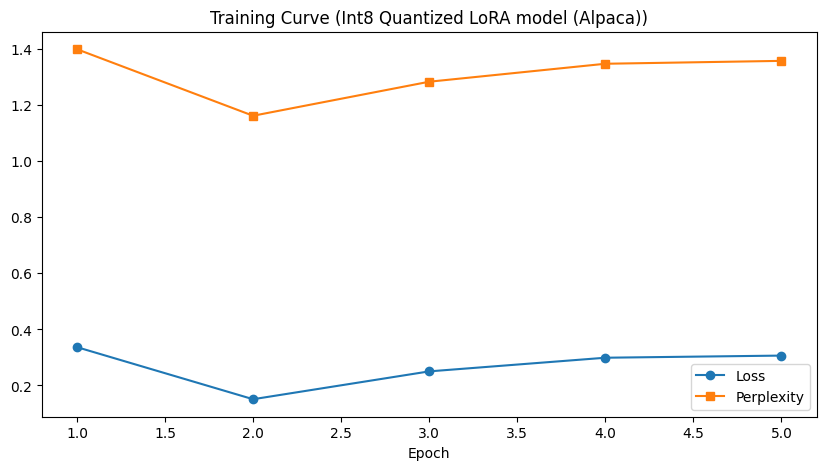

In [ ]:
model_int8_lora = deepcopy(base_model)
print(f"\n Training Int8 Quantized and Lora model on {name} dataset")
quantize_model_weights(model_int8_lora, method="int8")
model_int8_lora = patch_model(model_int8_lora, config={"lora": True})
df_lora_int8, int8_lora_eval   = report(model_int8_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"Int8 Quantized LoRA model ({name})")


 Training NF4 Quantized and Lora model on Alpaca dataset


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.06889230774326355

🚀 Epoch 1/5


Epoch 1: 100%|██████████| 25481/25481 [36:24<00:00, 11.66it/s, loss=2.2015]


✅ Epoch 1 Avg Loss: 0.4844 | Perplexity: 1.62

🚀 Epoch 2/5


Epoch 2: 100%|██████████| 25481/25481 [36:24<00:00, 11.66it/s, loss=8.4911]


✅ Epoch 2 Avg Loss: 6.8072 | Perplexity: 904.29

🚀 Epoch 3/5


Epoch 3: 100%|██████████| 25481/25481 [36:23<00:00, 11.67it/s, loss=8.7320]


✅ Epoch 3 Avg Loss: 8.9961 | Perplexity: 8071.33

🚀 Epoch 4/5


Epoch 4: 100%|██████████| 25481/25481 [36:23<00:00, 11.67it/s, loss=8.8744]


✅ Epoch 4 Avg Loss: 9.0154 | Perplexity: 8228.48

🚀 Epoch 5/5


Epoch 5: 100%|██████████| 25481/25481 [36:22<00:00, 11.68it/s, loss=8.9144]


✅ Epoch 5 Avg Loss: 8.9628 | Perplexity: 7807.45


🔍 Evaluating: 100%|██████████| 521/521 [34:55<00:00,  4.02s/it]


🧪 DEBUG: First Samples

📜 Prompt 1:
### Instruction:
Come up with a headline using the words provided.

### Input:
AI, Interview

### Response:
Tips for Acing Your AI Interview
🔸 Prediction 1:
Tips for Acing Your AI Interview localile either her Buck responsible scene local a do first as her-,,,, first physical Buck from,,,---,:
-  im  first A...,,:
,:
,,-,:
,,,-,,,,ill,,,,,,,-,,-,,-,,,,-,,-,,-,,,,,,:
,-,:
:
,,:
:
,-,,,,,:
:
 us:
,:
,,:
,:
:
:
,:
,,
✅ Reference 1:
Tips for Acing Your AI Interview

📜 Prompt 2:
### Instruction:
How can I prepare my house for a power outage?

### Response:
To prepare your house for a power outage, you should unplug or power down all non-essential electrical items, fill up your vehicle's gasoline tank, make sure you have plenty of supplies on hand, such as flashlights, batteries, food and water, and keep a battery-powered radio handy to get updates on the situation.
🔸 Prediction 2:
To prepare your house for a power outage, you should unplug or power down 

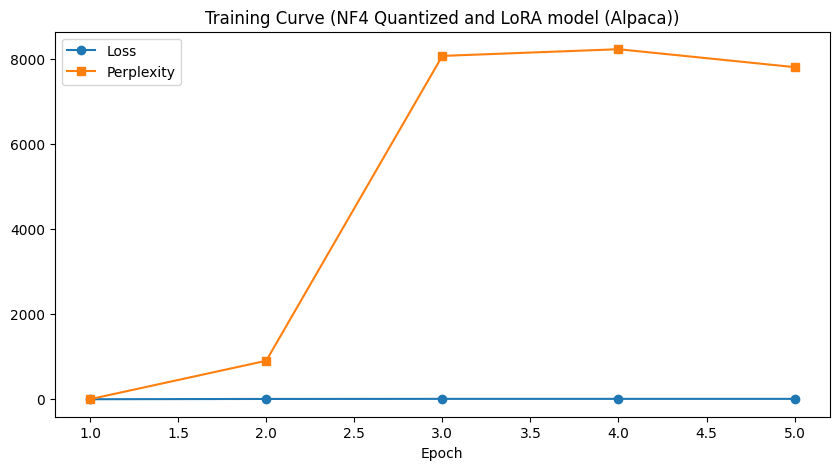

In [ ]:
model_nf4 = deepcopy(base_model)
print(f"\n Training NF4 Quantized and Lora model on {name} dataset")
quantize_model_weights(model_nf4, method="nf4")
model_nf4_lora = patch_model(model_nf4, config={"lora": True})
df_lora_nf4, nf4_lora_eval   = report(model_nf4_lora, train_dl, val_dl, tokenizer, epochs=5, variant_name=f"NF4 Quantized and LoRA model ({name})")

runtime.unassign()